In [26]:
%%time
%cd /gpfs/data/johnsonslab/nlp-genomics/pasolli-2019
import pandas as pd
#pd.set_option('display.max_colwidth', None)
import gzip
import re
import tarfile
import os
import youtokentome as yttm
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
from collections import defaultdict
import operator
import ftplib
from scipy.optimize import curve_fit
from functools import partial
#import pyperclip
import itertools
#import sentencepiece as spm
%matplotlib inline
from tqdm import tqdm
model_path = "metagenomes_8192k.model"
bpe = yttm.BPE(model=model_path)
import jupyter_beeper
beep = jupyter_beeper.Beeper()
beep.beep(secs=1)





/gpfs/data/johnsonslab/nlp-genomics/pasolli-2019


CPU times: user 36.2 s, sys: 2.15 s, total: 38.4 s
Wall time: 38.3 s


In [2]:
import argparse

import sentence piece as spm
spm.SentencePieceTrainer.train(input='/gpfs/data/johnsonslab/nlp-genomics/pasolli-2019/all_genomes_unlabeled_1000bp.txt',
                               model_prefix='sp_1000bp_full', vocab_size=8192, pad_id=3)

SyntaxError: invalid syntax (3487405208.py, line 3)

In [87]:
%%time
model_path = "metagenomes_8192k.model"
bpe = yttm.BPE(model=model_path)
vocab = bpe.vocab()
vocab_seqs = vocab[5:]
vocab_freqs = dict()
vocab_counts = []
for seq in vocab_seqs:
    if len(seq) not in vocab_freqs.keys():
        vocab_freqs[len(seq)] = 1
    else:
        vocab_freqs[len(seq)]+=1
#     vocab_counts.append(len(seq))
log_freqs = [np.log10(x) for x in vocab_freqs.values()]
# print(sum(vocab_counts)/len(vocab_counts))
plt.scatter(np.log10(vocab_freqs.keys()), log_freqs)
plt.xlabel('Sequence length')
plt.ylabel('Log10 count')
plt.show()
# plt.hist(vocab_counts, bins=2000)

TypeError: loop of ufunc does not support argument 0 of type dict_keys which has no callable log10 method

In [88]:
model_path = "metagenomes_8192k.model"
# model_path = 'metagenomes-.01-sample-5k-vocab.model'
bpe = yttm.BPE(model=model_path)
vocab = bpe.vocab()
vocab_seqs = vocab[5:]
vocab_freqs = dict()
# max_seq = ""
max_len = 0
top_seqs = []
limit_seqs = 5
for seq in vocab_seqs:
    if len(seq) not in vocab_freqs.keys():
        vocab_freqs[len(seq)] = 1
    else:
        vocab_freqs[len(seq)]+=1
    if(len(seq)>max_len):
        max_len = len(seq)
        top_seqs.append(seq)
        if(len(top_seqs)>limit_seqs):
            top_seqs.pop(0)

#         max_seq = seq
# plt.scatter(np.log10(vocab_freqs.keys()), log_freqs)
# plt.xlabel('Sequence length')
# plt.ylabel('Log10 count')
# plt.show()
# top_seqs[0]


KeyboardInterrupt: 

### Exploring Uniref 100

In [9]:
lines = []
with gzip.open('/gpfs/data/johnsonslab/nlp-genomics/uniref100/uniref100.fasta.gz') as f:
    for i, line in enumerate(f):
        if i>10:
            break
        lines.append(line)
lines
        

[b'>UniRef100_Q6GZX4 Putative transcription factor 001R n=4 Tax=Ranavirus TaxID=10492 RepID=001R_FRG3G\n',
 b'MAFSAEDVLKEYDRRRRMEALLLSLYYPNDRKLLDYKEWSPPRVQVECPKAPVEWNNPPS\n',
 b'EKGLIVGHFSGIKYKGEKAQASEVDVNKMCCWVSKFKDAMRRYQGIQTCKIPGKVLSDLD\n',
 b'AKIKAYNLTVEGVEGFVRYSRVTKQHVAAFLKELRHSKQYENVNLIHYILTDKRVDIQHL\n',
 b'EKDLVKDFKALVESAHRMRQGHMINVKYILYQLLKKHGHGPDGPDILTVKTGSKGVLYDD\n',
 b'SFRKIYTDLGWKFTPL\n',
 b'>UniRef100_Q6GZX3 Uncharacterized protein 002L n=3 Tax=Frog virus 3 TaxID=10493 RepID=002L_FRG3G\n',
 b'MSIIGATRLQNDKSDTYSAGPCYAGGCSAFTPRGTCGKDWDLGEQTCASGFCTSQPLCAR\n',
 b'IKKTQVCGLRYSSKGKDPLVSAEWDSRGAPYVRCTYDADLIDTQAQVDQFVSMFGESPSL\n',
 b'AERYCMRGVKNTAGELVSRVSSDADPAGGWCRKWYSAHRGPDQDAALGSFCIKNPGAADC\n',
 b'KCINRASDPVYQKVKTLHAYPDQCWYVPCAADVGELKMGTQRDTPTNCPTQVCQIVFNML\n']

# Investigating possible Zipf-like distribution

### Counting token frequencies

In [28]:
%%time
import operator
freqs = {}
lens = {}
threshold = 10
total_len = 0
total_count = 0
with(open('all_genomes_unlabeled_sample-A0.1-1.txt', 'r')) as f:
    for line in f:
        # tokens= bpe.encode(line.strip(), output_type =yttm.OutputType.SUBWORD )
        tokens = tokenize(line.strip(), length_threshold=threshold)
        total_len +=len(tokens)
        total_count +=1
        for token in tokens:
            if token not in freqs.keys():
                freqs[token] = 1
                lens[token] = len(token) if token[0] != "_" else len(token[1:])
            else:
                freqs[token]+=1
sorted_freqs = sorted(freqs.items(), key=operator.itemgetter(1), reverse=True)
print(len(sorted_freqs))
print("Average tokenization length: ", total_len/total_count)
beep.beep(secs=1)


4943127
Average tokenization length:  29.48373878741457
CPU times: user 14min 56s, sys: 25.4 s, total: 15min 22s
Wall time: 15min 24s


### Counting token appearances in documents

In [3]:
# %%time
# import operator
# freqs = {}
# threshold = 0
# with(open('all_genomes_unlabeled_sample-A0.1-1.txt') as f):
#     for line in f:
# #         tokens= bpe.encode(line.strip(), output_type =yttm.OutputType.SUBWORD )
#         tokens = tokenize(line.strip(), length_threshold=threshold)
#         doc_tokens = set()
#         for token in tokens:
#             doc_tokens.add(token)
#         for token in doc_tokens:
#             if token not in freqs.keys():
#                 freqs[token] = 1
#             else:
#                 freqs[token]+=1
# sorted_freqs = sorted(freqs.items(), key=operator.itemgetter(1), reverse=True)


Text(0, 0.5, 'Log10 frequency of token')

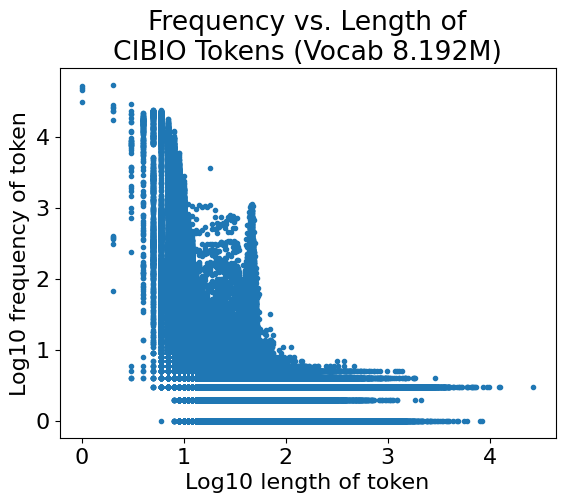

In [18]:
# import matplotlib as mpl
# mpl.rcParams['agg.path.chunksize'] = 1000
len_array = np.log10(list(lens.values()))
freq_array = np.log10(list(freqs.values()))
plt.scatter(len_array, freq_array, marker=".")
plt.rcParams.update({'font.size': 16})
plt.title("Frequency vs. Length of\nCIBIO Tokens (Vocab 8.192M)")
plt.xlabel("Log10 length of token")f
plt.ylabel("Log10 frequency of token")

18
[[0.         1.        ]
 [0.30103    1.        ]
 [0.47712125 1.        ]
 ...
 [6.69400159 1.        ]
 [6.69400168 1.        ]
 [6.69400177 1.        ]] [[3.56643749]
 [3.44466923]
 [3.38542751]
 ...
 [0.        ]
 [0.        ]
 [0.        ]]


Text(0, 0.5, 'Log10 Frequency')

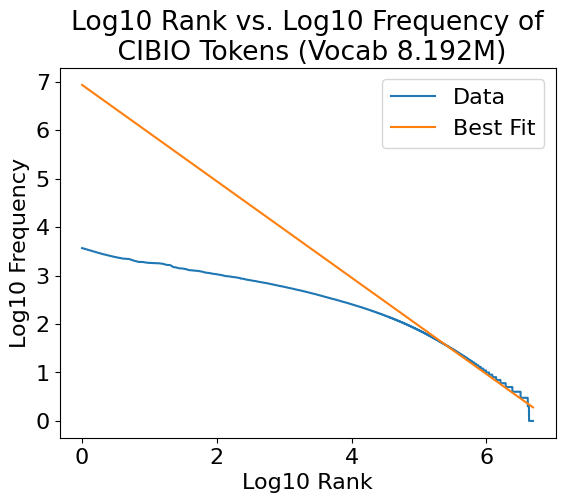

In [32]:
sorted_freq_values = []
sorted_freq_lengths = []
freq_threshold=0
print(len(sorted_freqs[0][0]))
for freq in sorted_freqs:
    sorted_freq_values.append(freq[1])
    if(freq[1]>freq_threshold):
        if(freq[0][0]=="_"):
            sorted_freq_lengths.append(len(freq[0][1:]))
        else:
            sorted_freq_lengths.append(len(freq[0]))

ranks = np.arange(1, len(sorted_freqs) + 1)
x = np.log10(ranks).reshape(len(ranks), 1)
X = np.append(x, np.ones((len(ranks), 1)), axis=1)
y = np.array(np.log10(sorted_freq_values)).reshape(len(sorted_freq_values), 1)
print(X, y)
theta = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
y_line = X.dot(theta)
plt.rcParams.update({'font.size': 16})
plt.plot(np.log10(ranks), np.log10(sorted_freq_values))
plt.plot(x, y_line)
plt.title('Log10 Rank vs. Log10 Frequency of\n CIBIO Tokens (Vocab 8.192M)')
plt.legend(['Data', 'Best Fit'])
plt.xlabel('Log10 Rank')
plt.ylabel('Log10 Frequency')


In [25]:
print((sorted_freq_lengths[:10]))

[2, 1, 1, 1, 1, 3, 2, 2, 2, 6]


In [5]:
total = 0 
for i in range(1, len(sorted_freq_values)):
    total+= sorted_freq_values[i-1]
    if total>=sum(sorted_freq_values)/2:
        break
print("number of types to reach 50%: ", i)
print(i/len(sorted_freq_values) * 100, "% of types make up half of all tokens")

number of types to reach 50%:  23400
0.46047963086063637 % of types make up half of all tokens


In [6]:
sfv_array = np.array(sorted_freq_values)
singles = sfv_array[sfv_array<=1]
print(len(singles), "types only appear once in all tokenizations")
print(len(singles)/len(sorted_freq_values) * 100, "% of all types only appear once")
print("Half of all types appear", sorted_freq_values[int(len(sorted_freq_values)/2)], "times or fewer")


637504 types only appear once in all tokenizations
12.54519686291364 % of all types only appear once
Half of all types appear 5 times or fewer


Text(0.5, 1.0, 'Log10 frequencies of log10 lengths of types (Vocab 8.192M)')

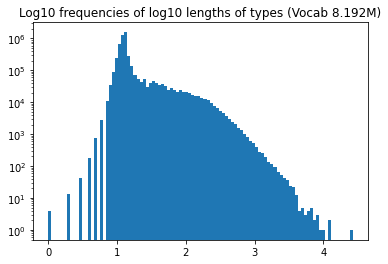

In [7]:
plt.hist(np.log10(sorted_freq_lengths), bins=100, log=True)
plt.title("Log10 frequencies of log10 lengths of types (Vocab 8.192M)")

index of first 1: 4305662
4943127
4943127


Text(0, 0.5, 'Length')

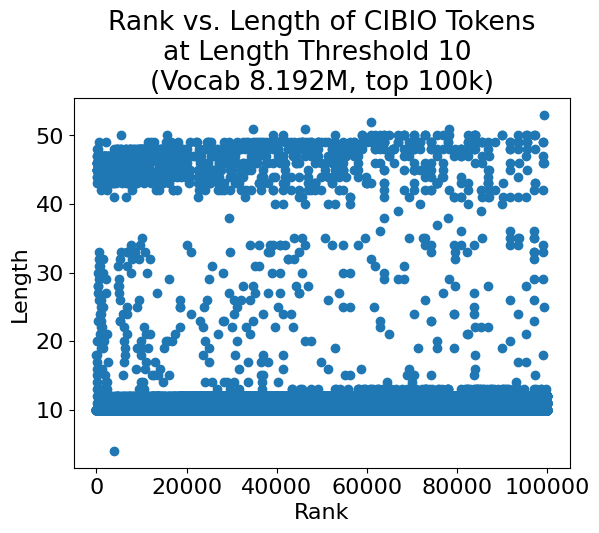

In [36]:
sorted_freq_values = []
sorted_freq_lengths = []
freq_threshold=0
for freq in sorted_freqs:
    sorted_freq_values.append(freq[1])
    if(freq[1]>freq_threshold):
        if(freq[0][0]=="_"):
            sorted_freq_lengths.append(len(freq[0][1:]))
        else:
            sorted_freq_lengths.append(len(freq[0]))
# plt.scatter(np.arange(len(sorted_freqs)), (sorted_freq_values))
# plt.title('Rank vs. Frequency at Threshold=10 (Vocab 8.192M)')
# plt.xlabel('Rank')
# plt.ylabel('Frequency')
for i in range(len(sorted_freq_values)):
    if(sorted_freq_values[i]==1):
        print("index of first 1: " +str(i))
        break

print(len(sorted_freqs))
print(len(sorted_freq_lengths))
sorted_freq_lengths_cut=sorted_freq_lengths[:int(1e5)]
# print(sorted_freqs[:1000])
plt.scatter((np.arange(len(sorted_freq_lengths_cut))), (sorted_freq_lengths_cut))
plt.title('Rank vs. Length of CIBIO Tokens\nat Length Threshold 10 \n(Vocab 8.192M, top 100k)')
plt.xlabel('Rank')
plt.ylabel('Length')


In [253]:
# print(sorted_freqs[100])
print(len(bpe.vocab()))

8192000


In [23]:
sorted_freqs_cut_length_thresholded = []
for freq in sorted_freqs:
    if(len(freq[0])>35):
        sorted_freqs_cut_length_thresholded.append(freq[0])
        
print(len(sorted_freqs_cut_length_thresholded))
print(len(sorted_freqs))
print(len(sorted_freqs_cut_length_thresholded)/len(sorted_freqs))
print(sorted_freqs_cut_length_thresholded[500:600])
#Less than 10% are above the length threshold
#TGTCTCTTATACACATCTCCGAGCCCACGAGACCGTACTAGATCT
#TGTCTCTTATACACATCTGACGCTGCCGACGAAGAGGATAGTGTA
#TGTCTCTTATACACATCTCCGAGCCCACGAGACCGTACTAGATC
total = 0
for freq in sorted_freqs_cut_length_thresholded:
    if('TGTCTCTTATACACATCT' in freq):
        total+=1
print(total/len(sorted_freqs_cut_length_thresholded))

469050
4943127
0.09488932815199771
['TGTCTCTTATACACATCTCCGAGCCCACGAGACAAGAGGCAA', '▁ATTTCTGCCTGTCTCGTGGGCTCGGAGATGTGTATAAGAGACAG', '▁AGATTACTACGCGTCTCGTGGGCTCGGAGATGTGTATAAGAGACAG', '▁TACACAAGGCTATTCGTCGGCAGCGTCAGATGTGTATAAGAGACAG', 'TGTCTCTTATACACATCTCCGAGCCCACGAGACGTAGAGGAA', '▁GAGATTAGCGAGTGTCTCGTGGGCTCGGAGATGTGTATAAGAGACAG', 'TGTCTCTTATACACATCTCCGAGCCCACGAGACGCGTAGTAAT', '▁TCTACACCTATTAAGTCGTCGGCAGCGTCAGATGTGTATAAGAGACAG', 'TGTCTCTTATACACATCTGACGCTGCCGACGAGCGATCTAGTGTAGAT', '▁GAGATTAGCGAGTGTCTCGTGGGCTCGGAGATGTGTATAAGAGAC', '▁CGAGATAGGAGTCCGTCTCGTGGGCTCGGAGATGTGTATAAGAGACAG', 'TGTCTCTTATACACATCTGACGCTGCCGACGAATAGAG', 'TGTCTCTTATACACATCTCTGATGGCGCGAGGGAGGCGTGTAGAT', 'TGTCTCTTATACACATCTCCGAGCCCACGAGACCTCTCTACA', '▁GATTAGCGAGTGTCTCGTGGGCTCGGAGATGTGTATAAGAGAC', '▁AGATGTCTTAGGGTCTCGTGGGCTCGGAGATGTGTATAAGAGACAG', '▁CGAGATACTGATCGGTCTCGTGGGCTCGGAGATGTGTATAAGAGAC', '▁CGAGATGCAGCGTAGTCTCGTGGGCTCGGAGATGTGTATAAGAGAC', '▁CACACTGCATATCGTCGGCAGCGTCAGATGTGTATAAGAGACAG', '▁AGATCTGCGCATGTCTCGTGGGCTC

In [20]:
total = 0
for freq in sorted_freqs:
    if(freq[1]==1):
        total+=1
print(total)
for i in range(100):
    print(i +1, sorted_freqs[i], len(sorted_freqs[i][0]))

637465
1 ('TGTCTCTTATACACATCT', 3685) 18
2 ('TTTTTCTTTT', 2784) 10
3 ('AAAAAGAAAA', 2429) 10
4 ('ATTTTCTTTT', 2243) 10
5 ('AAAGAAAAAT', 2187) 10
6 ('AAAAGAAAAT', 2010) 10
7 ('TTCTTCTTTT', 1907) 10
8 ('TGAAAAATAT', 1900) 10
9 ('AAAAAGAAAT', 1848) 10
10 ('AAAAAAATAT', 1820) 10
11 ('TTTTTTATTT', 1811) 10
12 ('AAAAAATAAT', 1810) 10
13 ('ATTTTTTAAT', 1803) 10
14 ('AAAAGAAGAA', 1786) 10
15 ('GCCGCCGCGC', 1765) 10
16 ('GCCGCCGCCC', 1741) 10
17 ('AAAAAAGAAT', 1698) 10
18 ('TTTTTCTTTC', 1659) 10
19 ('AAGAAAAAAT', 1648) 10
20 ('AGAAAAATAT', 1646) 10
21 ('AGAAGAAAAT', 1601) 10
22 ('AAATAAAAAT', 1530) 10
23 ('ATTTTTATTT', 1484) 10
24 ('TAAAAAAGAA', 1481) 10
25 ('TAAAAAATAT', 1466) 10
26 ('ATTTTTATAT', 1441) 10
27 ('TTTTTCTTCC', 1418) 10
28 ('AAAGAAAAAC', 1413) 10
29 ('AAAATAAAAT', 1406) 10
30 ('AAAAAAAGAT', 1404) 10
31 ('AAAGAAGAAT', 1394) 10
32 ('AGAAGAAGAT', 1388) 10
33 ('GGGCGGCGGC', 1370) 10
34 ('ATTTTTTATC', 1360) 10
35 ('ATTTTCTTTC', 1359) 10
36 ('AAAATATTAT', 1331) 10
37 ('GGAAGAAGAA', 1321

At threshold 25:

    618,524 unique tokens are included in the sum of all tokenizations of the training data
    The most common nucleotide sequence is GACCACCGAGATCTACACTCTTTCCCTACACGACGCTCTTCCGATC
    It appears 1150 times in the training corpus
    It belongs to the mitochondria of various organisms among others
    235,681 tokens only appear once
    
 At threshold 50:
 
     349,161 unique tokens are included in the sum of all tokenizations of the training data
     The most common nucleotide sequence is GGCGACCACCGAGATCTACACTCTTTCCCTACACGACGCTCTTCCGATC, which is the most common >25 nucleotide sequence + GCC
     It appears 324 times in the training corpus
     It belongs to the mitochondria of various organisms among others
     The second most common nucleotide sequence is AGATCGGAAGAGCGTCGTGTAGGGAAAGAGTGTAGATCTCGGTGGTCGCC
     It appears 210 times in the training corpus
     It belongs to a number of species: Heterocephalus glaber, Negativicoccus massiliensis, Plasmodium vivax, and
     113,150 tokens only appear once


In [43]:
thresholds = [0, 25, 50, 100, 500,1000]
included_tokens=[5081657, 618524, 349161, 176388, 9771, 1850]



49

Text(0, 0.5, 'Average tokenization length')

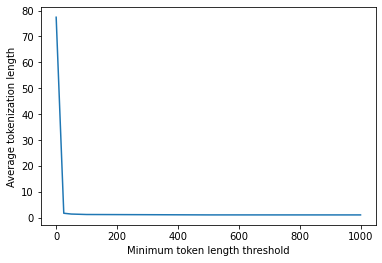

In [77]:
%%time
avgs = []
for threshold in thresholds:
    lengths = []
    with(open('all_genomes_unlabeled_sample-A0.1-1.txt') as f):
        for line in f:

            tokens = tokenize_with_length_threshold(line, length_threshold=threshold)
            lengths.append(len(tokens))
#             print(len(lengths))
        if(len(lengths)==0):
            print(threshold)
    avgs.append(sum(lengths)/len(lengths))
plt.plot(thresholds, avgs)
plt.xlabel("Minimum token length threshold")
plt.ylabel("Average tokenization length")

Text(0, 0.5, 'Average tokenization length')

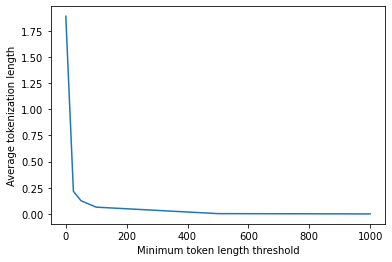

In [78]:
plt.plot(thresholds, np.log10(avgs))
plt.xlabel("Minimum token length threshold")
plt.ylabel("Average tokenization length")

# TF-IDF

In [103]:
%%time
from functools import partial
# with open('all_genomes_unlabeled_sample-A0.1-1.txt') as f:
#     length = sum(1 for line in f)
#     print('length:', length)
def tokenize_with_length_threshold(string, length_threshold=100):
    tokens= bpe.encode(string, output_type =yttm.OutputType.SUBWORD )
    out = []
    for token in tokens:
        if(len(token)>=length_threshold):
            out.append(token)
    if(len(out)==0):
        out.append("none")
        

#     print(len(tokens), len(out))
    return out
threshold = 0
tokenize = partial(tokenize_with_length_threshold, length_threshold = threshold)
# tokenize = partial(bpe.encode, output_type=yttm.OutputType.SUBWORD)



CPU times: user 11 µs, sys: 0 ns, total: 11 µs
Wall time: 15 µs


In [6]:
%%time
import scipy
import sys
from sklearn.feature_extraction.text import TfidfVectorizer

#out of 8,192,000 tokens, 5,081,658 appear in the tokenized BPE training corpus
#thresholding at len>25, 618,525 tokens appear in the tokenized training corpus
#thresholding at len>50, 349,162 tokens appear in the tokenized training corpus
#thresholding at len>100, 176,389 tokens appear in the tokenized training corpus
#thresholding at len>500, 9772 tokens appear in the tokenized training corpus
#thresholding at len>1000, 1851 tokens appear in the tokenized training corpus
with open('all_genomes_unlabeled_sample-A0.1-1.txt') as f:
    vectorizer = TfidfVectorizer(lowercase=False, tokenizer=tokenize)
    X = vectorizer.fit_transform(f)
 
vectorizer_output = vectorizer.get_feature_names_out()
# sorted_output = sorted(vectorizer_output, key=len)
len(vectorizer_output)
# X
scipy.sparse.save_npz('A.1_tf-idf_threshold_1000.npz', X)
# X_ = scipy.sparse.load_npz('A.1_tf-idf_threshold_50.npz')
# print(X_.shape)
# tokenize(['ATTTGTAGTCGTCCGTTGCACCGTTA'])


CPU times: user 17min 45s, sys: 7.92 s, total: 17min 53s
Wall time: 18min 2s


## Latent Dirichlet Allocation from TF-IDF matrix

plotting...
CPU times: user 2h 53min, sys: 1h 45min 14s, total: 4h 38min 15s
Wall time: 1h 33min 25s


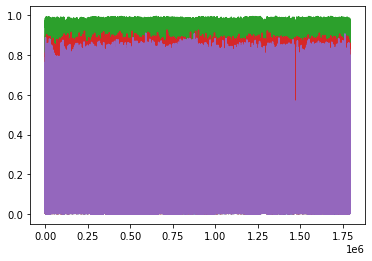

In [22]:
%%time
from sklearn.decomposition import LatentDirichletAllocation
lda = LatentDirichletAllocation(n_components=5,random_state=0)
lda.fit(X)
X_t = lda.transform(X)
print("plotting...")
# np.save('A.1_tf-idf_threshold_0-lda.npy', X_t)

# df = pd.DataFrame(X[3].T.todense(), index=vectorizer.get_feature_names_out(), columns=["TF-IDF"])
# df = df.sort_values('TF-IDF', ascending=False)
# print (df[df['TF-IDF']>0].head(25))
# print(df[df['TF-IDF']>0].tail(25))
# df = pd.DataFrame(data=X)# columns=vectorizer_output)


In [27]:
X_t.shape

array([[0.00708728, 0.07334169, 0.85059172, 0.06180162, 0.00717769],
       [0.00878205, 0.00899372, 0.87505633, 0.09837465, 0.00879324],
       [0.01265258, 0.01303474, 0.90425213, 0.01309033, 0.05697022],
       [0.04169259, 0.0419662 , 0.30592846, 0.04180657, 0.56860617],
       [0.01396325, 0.01402442, 0.94408782, 0.01399791, 0.0139266 ],
       [0.01676049, 0.01751593, 0.92528066, 0.01706962, 0.02337331],
       [0.01777893, 0.09785032, 0.84873597, 0.01782928, 0.0178055 ],
       [0.01997321, 0.02012709, 0.91978046, 0.0200756 , 0.02004363],
       [0.0212833 , 0.02138833, 0.91461894, 0.02138295, 0.02132649],
       [0.02021003, 0.02027979, 0.91892696, 0.02035062, 0.02023261]])

# Truncated SVD on TF-IDF Matrix

In [32]:
%%time
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=2, n_iter=7, random_state=42)
df = svd.fit_transform(X)


CPU times: user 1min 34s, sys: 12.8 s, total: 1min 47s
Wall time: 1min 30s


## K-Means Clustering of Truncated SVD

In [37]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3)
label = kmeans.fit_predict(df)





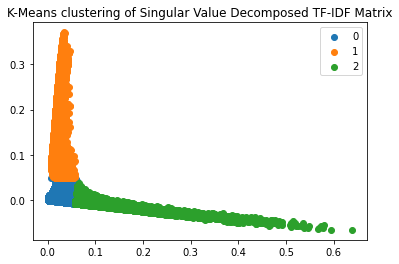

In [40]:
u_labels = np.unique(label)
for i in u_labels:
    plt.scatter(df[label == i , 0] , df[label == i , 1] , label = i)
plt.legend()
plt.title("K-Means clustering of Singular Value Decomposed TF-IDF Matrix")
plt.show()

In [39]:

\ ,x = [0, 25, 50, 100, 500, 1000]
y = [5081658, 618525,349162,176389,9772,1852]
plt.plot(x, np.log10(y))
plt.xlabel("Minimum token length threshold")
plt.ylabel("log10 number of unique tokens\n included in tokenized corpus")
plt.title("TF-IDF Token Inclusion (8.192M vocabulary)")

SyntaxError: unexpected character after line continuation character (1438055123.py, line 1)

In [27]:
%%time
##### files = os.listdir()
# for file in files:
#     if('tar' not in file):
#         continue
#     tar = tarfile.open(file, 'r:bz2')
#     for file_ in tar:
#         try:
#             tar.extract(file_)
#         except PermissionError as p:
#             os.remove(file_.name)
#             tar.extract(file_)
#         finally:
#             os.chmod(file_.name, file_.mode)
#     tar.close()
#     break

import random

import youtokentome as yttm

train_data_path = "train_data.txt"
model_path = "metagenomes_8192k.model"
# model_path = 'metagenomes_8192k_0.1s-001.model'

# Generating random file with training data
# # 10000 lines with 100 characters in each line
# n_lines = 100
# n_characters = 60
# with open(train_data_path, "w") as fout:
#     for _ in range(n_lines):
#         print("".join([random.choice("abcd ") for _ in range(n_characters)]), file=fout)

# # Generating random text
# test_text = "".join([random.choice("abcde ") for _ in range(100)])

# # Training model
# yttm.BPE.train(data=train_data_path, vocab_size=5000, model=model_path)

# Loading model
path = 'SchirmerM_2016/SchirmerM_2016__G88690.fa'
genomes_dict = (retrieve_genomes(path))
genomes = list(genomes_dict.values())
headers = list(genomes_dict.keys())
print(headers[:10])
print(len(headers))
bpe = yttm.BPE(model=model_path)

# Two types of tokenization
test_text = genomes[0]
# print(test_text)
tokens = bpe.encode([test_text], output_type=yttm.OutputType.ID)
subwords = bpe.encode([test_text], output_type=yttm.OutputType.SUBWORD)
maxlen=0
max_token = ""
total_token_lens = []
total_tokenization_lens = []
token_vocab = set()
print(len(subwords[0]))
for genome in genomes:
    tokens = bpe.encode([genome], output_type=yttm.OutputType.SUBWORD)
    total_tokenization_lens.append(len(tokens))
    for subword in tokens[0]:
        total_token_lens.append(len(subword))
        token_vocab.add(subword)

        if(len(subword)>maxlen):
            maxlen = max(len(subword), maxlen)
            max_token = subword
print("Max token length: ",maxlen)
total_tokens_std = np.std(total_token_lens)
print("Average token length from tokenizations: ", sum(total_token_lens)/sum(total_tokenization_lens),
      "\nStandard deviation: ", total_tokens_std)
total_vocab_token_lens = []
for token in list(token_vocab):
    total_vocab_token_lens.append(len(token))

total_vocab_std = np.std(total_vocab_token_lens)
print("Average token length from vocab :", sum(total_vocab_token_lens)/len(token_vocab),
     "\nStandard deviation: ", total_vocab_std)
# print(max_token)



['>NODE_1_length_125355_cov_25.4881', '>NODE_2_length_120586_cov_23.859', '>NODE_3_length_114055_cov_24.2301', '>NODE_4_length_94820_cov_22.5514', '>NODE_5_length_81954_cov_25.7914', '>NODE_6_length_79929_cov_25.217', '>NODE_7_length_78510_cov_9.36004', '>NODE_8_length_77166_cov_25.0314', '>NODE_9_length_76836_cov_27.7737', '>NODE_10_length_76391_cov_25.5694']
380956
13625
Max token length:  12261
Average token length from tokenizations:  429.10275464883085 
Standard deviation:  10.42852050814017
Average token length from vocab : 14.717519787001322 
Standard deviation:  25.927237096160916
CPU times: user 2min 34s, sys: 2.63 s, total: 2min 36s
Wall time: 2min 37s


In [32]:
max_token

'GGTACTCTTTCCCGTTTATAACAAGCCAATGAAACATCTGATACGACATATCATTCTTCTATGCGGGTTGCCGCTGTTGCTGGCGGGCTGCATGGAGTGGGACTACGGAGATGCGGTGGAAGATTTCAACGCTACCGGAGCCGGGTTGTTCATCACCAACGAGGGCAACTTCCAGTACGGCAATGCCACGTTGTCGTACTACGACCCCGAAACCCAACAGGTGCAGAATGAAGTGTTCTTCCGTGCCAACGGCATGAAGCTGGGCGACGTGGCGCAATCGATGTGCATCCACGACAATAAGGGCTGGGTCGTGGTGAACAATTCCCACGTGATTTTCGCCATCGACCTCAATACGTTCAAAGAGGTGGGCCGTATCACGAACCTGACTTCGCCGCGCTATATCCATTTCCTCAGCGACGAGAAAGCCTATGTCACCCAATTGTGGGACAACCGCATCTTCATCATCAACCCCAAGAAATATGAAATCACCGGTTACATCCAGGTGCCGGACATGACGATGGAAAGCGGCTCCACGGAGCAGATGGTGCAGTATGGCAAATATGTCTATTGCAACTGCTGGTCGTACCAAAACCGCATCATCAAGATCGATACCGAAACGGATCAGGTGGTAGAAGAACTGAAAGTCGGCATCCAGCCCACCTCGCTGGTAATGGACAAGAACCACAAGATGTGGACGATCACCGACGGTGGGTACGAGGGTTCGCCCTACGGCTACGAAGCCCCGTCTCTCTACCGCATCGATGCCGAGACGTTCACCGTAGAGAAGCAGTTCAAGTTCAAGATGGGCGACTGGCCTTCGGAGGTGCAGCTCAACGGTACGGGCGACAAGCTCTACTGGATCAACAAGGACATATGGTCGATGGACGTGGATGCGGAACGTGTTCCCGTGCGCCCGTTCCTCGAATACAGCGGTACGATTTATTACGGCCTGACCGTCGACCCCGTGCGTGGCGATGTCTACGTGGCCGATGCCATCGA

Proof of concept:  
Max token length: 12261  
Average token length from tokenizations:  429.10275464883085  
Standard deviation:  10.42852050814017  
Average token length from vocab : 14.717519787001322  
Standard deviation:  25.927237096160916 


Set 0  
Max token length: 5339  
Average token length from tokenizations:  429.10275464883085  
Standard deviation:  9.929362552327742  
Average token length from vocab : 14.68204054835662  
Standard deviation:  24.402540595269116  

Set 1  
Max token length: 4930  
Average token length from tokenizations:  429.10275464883085  
Standard deviation:  9.43531074177898  
Average token length from vocab : 14.73471269178317  
Standard deviation:  22.80845929240418  



130


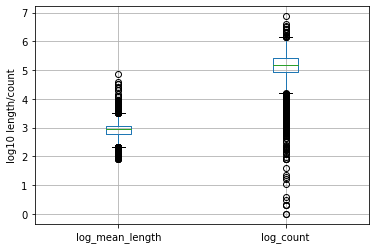

In [5]:
# import numpy as np
# from tqdm import tqdm
# np.random.seed(0)
# # i = 0
# with open('/gpfs/data/johnsonslab/nlp-genomics/pasolli-2019/all_genomes_unlabeled.txt', 'r') as inp:
#     with open('/gpfs/data/johnsonslab/nlp-genomics/pasolli-2019/all_genomes_unlabeled_sample-01.txt', 'w') as out:
#         for line in tqdm(inp):
#             if(np.random.rand()>=0.99):
#                 out.write(line)
# # #                 i+=1
# # #                 if(i>=5):
# # #                     break
            
df = pd.read_csv('passoli-2019-sample_details.csv')
df['count'].min()
# df=df[df['count']>0]
# df['count'].hist(bins=100)
# df['count'].max()
df['log_count']=df['count'].apply(lambda x:np.log10(x))
df['log_mean_length'] = df['mean_length'].apply(lambda x:np.log10(x))

ax = df.boxplot(column=['log_mean_length', 'log_count'])
ax.set(ylabel="log10 length/count")



In [148]:
%%time
import pandas as pd
import numpy as np
from functools import partial
# with open('all_genomes_unlabeled_sample-A0.1-1.txt') as f:
#     length = sum(1 for line in f)
#     print('length:', length)
def tokenize_with_length_threshold(string, length_threshold=100):
    tokens= bpe.encode(string, output_type =yttm.OutputType.SUBWORD )
    out = []
    for token in tokens:
        if(len(token)>=length_threshold):
            out.append(token)
    if(len(out)==0):
        out.append("none")
#     print(len(tokens), len(out))
    return out
threshold = 10
tokenize = partial(tokenize_with_length_threshold, length_threshold = threshold)
# tokenize = partial(bpe.encode, output_type=yttm.OutputType.SUBWORD)


def retrieve_genomes(path, gzipped=False):
    if(gzipped):
        with gzip.open(path, 'r') as f:
            file_content = f.readlines()
            file_content = [content.strip() for content in file_content]
            
    else:
        with open(path, 'r') as f:
            file_content = f.readlines()
            file_content = [content.strip() for content in file_content]
    if isinstance(file_content[0], bytes):
        file_content = [line.decode('utf') for line in file_content]
    genomes = {}
    bases = ""
    header = file_content[0]
    
    for i in range(1, len(file_content)):
        if(">") in file_content[i]:
            genomes[header] = bases
            header = file_content[i]
            bases=""
        else:
            bases+= file_content[i] 
            if(i==len(file_content)-1):
                genomes[header] = bases
                header = file_content[i]
                bases=""
    return genomes

def max_len(path):
    genomes = list(retrieve_genomes(path).values())
    maximum = -np.inf
    for genome in genomes:
        maximum = max(maximum, len(genome))
    return maximum

def min_len(path):
    genomes = list(retrieve_genomes(path).values())
    minimum = np.inf
    for genome in genomes:
        minimum = min(minimum, len(genome))
    return minimum
def mean_len(path):
    genomes = list(retrieve_genomes(path).values())
    total = 0
    for genome in genomes:
        total+= len(genome)
    if(len(genomes)>0):
        return total/len(genomes)
    else:
        return 0

    
def get_counts(path):
    genomes = list(retrieve_genomes(path).values())
    return len(genomes)
def get_ignore_dict(thresholds):
    ignore_dict = {}
    for threshold in thresholds:
        ignore_dict[threshold]=[]
        for vocab in bpe.vocab():
            if(len(vocab)<threshold):
                ignore_dict[threshold].append(vocab)
    return ignore_dict
# def get_quartiles(path):
#     genomes = list(retrieve_genomes(path).values())
#     lengths = [len(genome) for genome in genomes]
#     quartiles = np.quantile(lengths, [i* 0.25 for i in range(5)])
#     return list(quartiles)
def retrieve_tokenizations(files):
    tokenizations = []
    genome_lens = []
    for file in files:
        path = os.path.join(directory, file)
        genome = retrieve_genomes(path, gzipped=False)

        genome = genome[list(genome.keys())[0]]
        genome_lens.append(len(genome))
#         freqs = {}
        threshold = 0
        tokenizations.append(tokenize(genome, length_threshold=threshold))
    return tokenizations, genome_lens

# folders = []
# for file in os.listdir():
#     if("tar" not in file and "txt" not in file and "model" not in file):
#         folders.append(file)
# files =[]
# for folder in folders:
#     for file in os.listdir(folder):
#         #extract genomes from each file
#         files.append(os.path.join(folder, file))
# df = pd.DataFrame(index=np.arange(len(files)))
# df['path'] = files
# df['max_length'] = df['path'].apply(lambda x: max_len(x))
# df['min_length'] = df['path'].apply(lambda x: min_len(x))
# df['mean_length'] = df['path'].apply(lambda x: mean_len(x))
# df['count'] = df['path'].apply(lambda x: get_counts(x))
# df.to_csv('/gpfs/data/johnsonslab/nlp-genomics/pasolli-2019/sample_details.csv', index=None)
# for x in range(10):
#     print(max_len(df['path'][x]))


# path = 'CM_cf/CM_cf__CF_TNFC008IS_t5M16.fa'
path = 'SchirmerM_2016/SchirmerM_2016__G88690.fa'
genomes = retrieve_genomes(path).values()
print(len("".join(list(genomes))))
# path = df['path'][path]
# import sys
# print(sys.version)

163088313
CPU times: user 2.47 s, sys: 275 ms, total: 2.74 s
Wall time: 2.78 s


### Retrieving ATGC frequencies

In [85]:
genomes = list(retrieve_genomes(path).values())
base_nums = {'A':0,'T':0,'G':0, 'C':0}
total = 0
for genome in genomes:
    for base in genome:
        base_nums[base]+=1
    total+=len(genome)
base_freqs = {}
for base in base_nums.keys():
    base_freqs[base] = base_nums[base]/total
print(base_freqs)


{'A': 0.2633059488450285, 'T': 0.2632087009202186, 'G': 0.2369057309459078, 'C': 0.23657961928884505}


### Synthesizing random genomes

In [108]:
%%time
np.random.seed(42)
num_rand = 10
rand_genomes = []
for i in range(num_rand):
    rand_genomes.append("".join(np.random.choice(['A', 'T', 'G', 'C'], 
                                  np.random.randint(1500000, 5000000),
                                  p=[0.2633059488450285,0.2632087009202186,0.2369057309459078,0.23657961928884505])))
print(rand_genomes[0][:100])                        

CACGTATTAGAGCACGGAATTACAAGTCTCGTACGTAAAGGCATAGTAGACTTCGTGTCCGGGCGTTAATTTAAGCGCGCCTATGGGTGTCCGAAAGATA
CPU times: user 12.1 s, sys: 2.32 s, total: 14.4 s
Wall time: 14.4 s


In [110]:
%%time
rand_genome_lens = [len(genome) for genome in rand_genomes]
rand_tokenizations = [tokenize(genome, length_threshold=0) for genome in rand_genomes]
rand_tokenization_lengths = [len(tokenization) for tokenization in rand_tokenizations]

# rand_token_lengths = []
# for i, tokenization in enumerate(rand_tokenizations):
#     rand_token_lengths.append([])
#     for token in tokenization:
#         rand_token_lengths[i].append(len(token))

CPU times: user 36.5 s, sys: 1.04 s, total: 37.5 s
Wall time: 37.5 s


Text(0, 0.5, 'Tokenization Length (num tokens)')

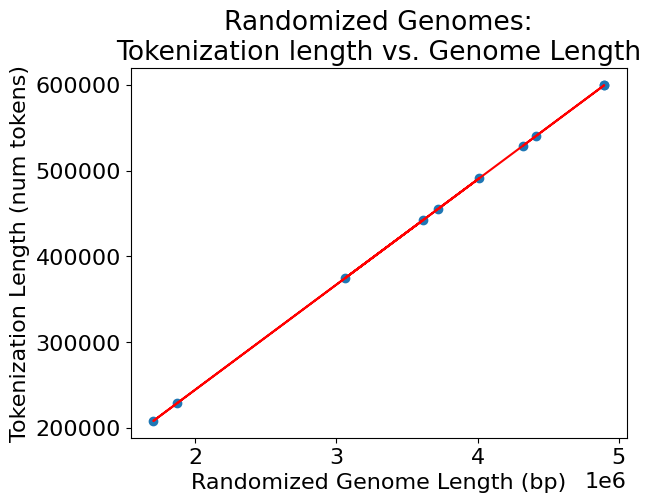

In [111]:
plt.scatter(rand_genome_lens, rand_tokenization_lengths)
x = np.array(rand_genome_lens).reshape(len(rand_genome_lens), 1)
X = np.append(x, np.ones((len(rand_genome_lens), 1)), axis=1)
y = np.array(rand_tokenization_lengths).reshape(len(rand_tokenization_lengths), 1)
theta = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
y_line = X.dot(theta)
plt.rcParams.update({'font.size': 16})
plt.plot(x, y_line, 'r')
plt.title("Randomized Genomes:\nTokenization length vs. Genome Length")
plt.xlabel("Randomized Genome Length (bp)")
plt.ylabel("Tokenization Length (num tokens)")

### Measuring total vocabulary of synthetic genomes

In [112]:
vocab = set()
for tokenization in rand_tokenizations:
    vocab = vocab.union(set(tokenization))
print(len(vocab))



785972


In [113]:
vocabs = {}
rand_vocab_lens = []
for i, tokenization in enumerate(rand_tokenizations):
    vocabs[i] = set(tokenization)
    rand_vocab_lens.append(len(vocabs[i]))

Text(0, 0.5, 'Vocabulary size (num tokens)')

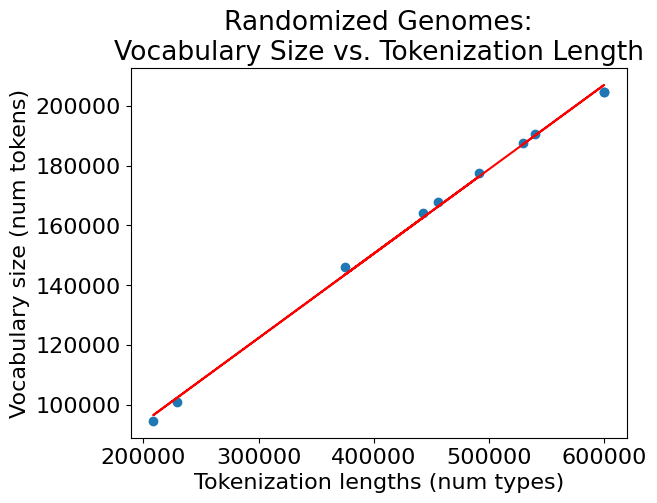

In [114]:
plt.scatter(rand_tokenization_lengths, rand_vocab_lens)
x = np.array(rand_tokenization_lengths).reshape(len(rand_tokenization_lengths), 1)
X = np.append(x, np.ones((len(rand_tokenization_lengths), 1)), axis=1)
y = np.array(rand_vocab_lens).reshape(len(rand_vocab_lens), 1)
theta = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
y_line = X.dot(theta)
plt.plot(x, y_line, 'r')
plt.title("Randomized Genomes:\nVocabulary Size vs. Tokenization Length")
plt.xlabel("Tokenization lengths (num types)")
plt.ylabel("Vocabulary size (num tokens)")

Text(0, 0.5, 'Vocabulary size (num tokens)')

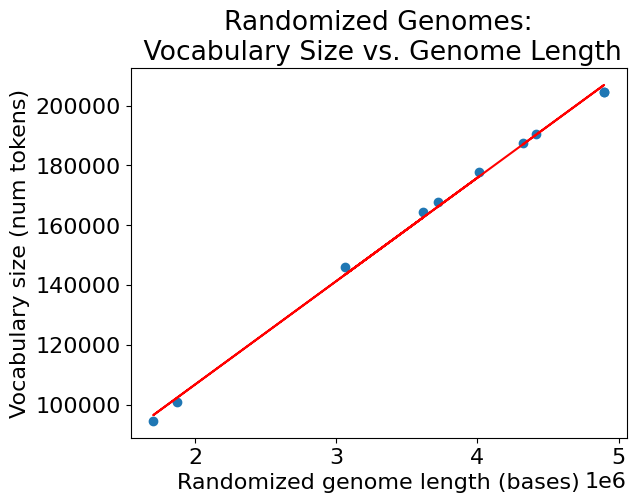

In [115]:
plt.scatter(rand_genome_lens, rand_vocab_lens)
x = np.array(rand_genome_lens).reshape(len(rand_genome_lens), 1)
X = np.append(x, np.ones((len(rand_genome_lens), 1)), axis=1)
y = np.array(rand_vocab_lens).reshape(len(rand_vocab_lens), 1)
theta = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
y_line = X.dot(theta)
plt.plot(x, y_line, 'r')
plt.title("Randomized Genomes:\n Vocabulary Size vs. Genome Length")
plt.xlabel("Randomized genome length (bases)")
plt.ylabel("Vocabulary size (num tokens)")

### Measuring shared vocabulary of synthetic genomes

In [116]:
%%time
token_dict = {token: set() for token in vocab}
for i, tokenization in enumerate(rand_tokenizations):
    #for each tokenization, assign a set of unique values
    token_set = (set(tokenization)) 
    for j, token in enumerate(all_tokens):
        #for each token in the set of all tokens

        if token in token_set:
            token_dict[token].add(i)


NameError: name 'all_tokens' is not defined

In [117]:
universal_tokens = 0
isolated_tokens = 0 ###unique to their families, isolated to avoid confusion with single appearance tokens
for token_family in token_dict.values():
    if(len(token_family)==len(rand_tokenizations)):
        universal_tokens+=1
    elif(len(token_family)==1):
        isolated_tokens +=1

print("{} tokens appear in all tokenizations".format(universal_tokens))
print("{} tokens are unique to one tokenization".format(isolated_tokens))
print("{} tokens are shared between at least two but not all tokenizations".format(len(vocab)-(universal_tokens + isolated_tokens)))

0 tokens appear in all tokenizations
0 tokens are unique to one tokenization
785972 tokens are shared between at least two but not all tokenizations


### Measuring Rank vs. Length in synthetic genomes

In [118]:
%%time
freqs = {}
lens = {}
for tokens in rand_tokenizations:
    for token in tokens:
        if token not in freqs.keys():
            freqs[token] = 1
            lens[token] = len(token) if token[0] != "_" else len(token[1:])
        else:
            freqs[token]+=1
sorted_freqs = sorted(freqs.items(), key=operator.itemgetter(1), reverse=True)

CPU times: user 3.22 s, sys: 37.9 ms, total: 3.26 s
Wall time: 3.26 s


Text(0, 0.5, 'Log10 frequency')

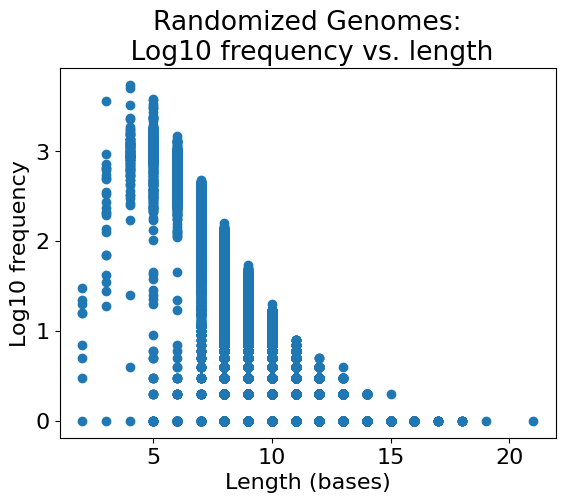

In [119]:
plt.scatter(lens.values(), np.log10(list(freqs.values())))
plt.title('Randomized Genomes:\n Log10 frequency vs. length')
plt.xlabel('Length (bases)')
plt.ylabel('Log10 frequency')

785972
785972
21
309219


Text(0, 0.5, 'Log10 Frequency')

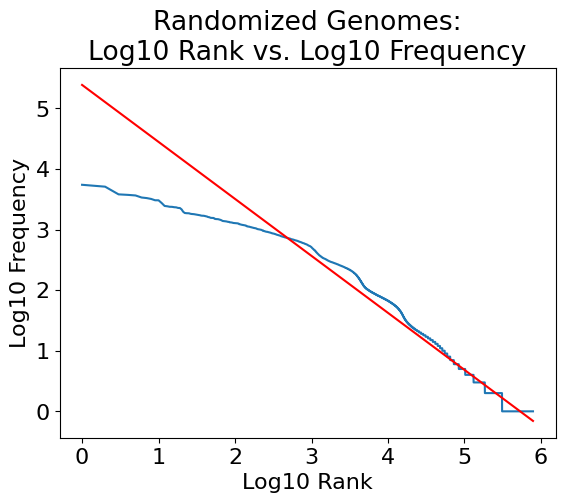

In [121]:
sorted_freq_values = []
sorted_freq_lengths = []
freq_threshold=0
for freq in sorted_freqs:
    sorted_freq_values.append(freq[1])
    if(freq[1]>freq_threshold):
        if(freq[0][0]=="_"):
            sorted_freq_lengths.append(len(freq[0][1:]))
        else:
            sorted_freq_lengths.append(len(freq[0]))
    if(len(freq[0])>21):
        print(freq[0])


print(len(sorted_freqs))
print(len(sorted_freq_lengths))
print(max(sorted_freq_lengths))
for i in range(len(sorted_freq_values)):
    if(sorted_freq_values[i]==1):
        print(i)
        break
sorted_freq_lengths_cut=sorted_freq_lengths
# print(sorted_freqs[:1000])
fig, ax = plt.subplots()
# plt.scatter((sorted_freq_lengths_cut), (np.arange(len(sorted_freq_lengths_cut))))
ax.plot(np.log10(np.arange(1, len(sorted_freq_values)+1)), np.log10(sorted_freq_values))

x = np.array(np.log10(np.arange(1,len(sorted_freq_values)+1)).reshape(len(sorted_freq_values), 1))
X = np.append(x, np.ones((len(sorted_freq_values), 1)), axis=1)
y = np.array(np.log10(sorted_freq_values)).reshape(len(sorted_freq_values), 1)
theta = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
y_line = X.dot(theta)
ax.plot(x, y_line, 'r')
plt.rcParams.update({'font.size': 16})
ax.set_title('Randomized Genomes:\nLog10 Rank vs. Log10 Frequency')
ax.set_xlabel('Log10 Rank')
ax.set_ylabel('Log10 Frequency')

# Tokenizing E. coli genome

In [37]:
%%time

## Retrieving E. coli genome
path ='/gpfs/data/johnsonslab/nlp-genomics/model_genomes/e_coli/ncbi-genomes-2022-08-22/GCF_000005845.2_ASM584v2_genomic.fna.gz'
genome = retrieve_genomes(path, gzipped=True)
genome = genome[list(genome.keys())[0]]
print(len(genome))
freqs = {}
threshold = 0
tokens = tokenize(genome, length_threshold=threshold)
print(len(tokens))
for token in tokens:
    if token not in freqs.keys():
        freqs[token] = 1
    else:
        freqs[token]+=1
sorted_freqs = sorted(freqs.items(), key=operator.itemgetter(1), reverse=True)
# print(sorted_freqs[:100])

# with(open('all_genomes_unlabeled_sample-A0.1-1.txt') as f):
#     for line in f:
# #         tokens= bpe.encode(line.strip(), output_type =yttm.OutputType.SUBWORD )
#         tokens = tokenize(line.strip(), length_threshold=threshold)
#         for token in tokens:
#             if token not in freqs.keys():
#                 freqs[token] = 1
#             else:
#                 freqs[token]+=1
# sorted_freqs = sorted(freqs.items(), key=operator.itemgetter(1), reverse=True)

# with gzip.open(path, 'rb') as f:
#     file_content = f.readlines()
#     print(type(file_content[0]))
#     file_content = [content.decode('utf-8').strip() for content in file_content]
# # print(file_content[0].decode('utf-8'))
# for line in file_content:
#     if ">" in line:
#         print(line)

4641652
509337
CPU times: user 6.73 s, sys: 1.08 s, total: 7.8 s
Wall time: 7.84 s


In [38]:
sorted_freq_values = []
sorted_freq_lengths = []
freq_threshold=0
for freq in sorted_freqs:
    sorted_freq_values.append(freq[1])
    if(freq[1]>freq_threshold):
        if(freq[0][0]=="_"):
            sorted_freq_lengths.append(len(freq[0][1:]))
        else:
            sorted_freq_lengths.append(len(freq[0]))


In [39]:
print(sorted_freq_values[:3])
half_sum = 0
half_total = sum(sorted_freq_values)/2
for i in range(1, len(sorted_freq_values)+1):
    if(half_sum > half_total):
        break
    half_sum += sorted_freq_values[i]
print(i)
print(i/len(sorted_freq_values) *100)


[314, 288, 226]
13825
6.828644248626863


In [40]:
total = 0
for i in range(len(sorted_freq_values)):
    if sorted_freq_values[i]==1:
        total+=1
print(total)
print(total/len(sorted_freq_values) * 100)

149744
73.96372545145611


[[0.         1.        ]
 [0.30103    1.        ]
 [0.47712125 1.        ]
 ...
 [5.30632636 1.        ]
 [5.30632851 1.        ]
 [5.30633065 1.        ]] [[2.49692965]
 [2.45939249]
 [2.35410844]
 ...
 [0.        ]
 [0.        ]
 [0.        ]]
202456
202456


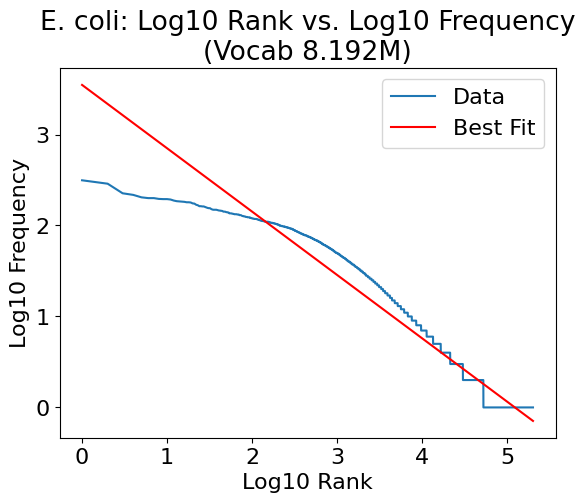

In [45]:

ranks = np.arange(1, len(sorted_freqs)+1)
# plt.scatter(np.log10(ranks), np.log10(sorted_freq_values))
# plt.title('E. coli: Log10 Rank vs. Log10 Frequency at Threshold=0 (Vocab 8.192M)')
# plt.xlabel('Rank')
# plt.ylabel('Frequency')
fig, ax = plt.subplots()
ax.plot(np.log10(ranks), np.log10(sorted_freq_values))
ax.set_title('E. coli: Log10 Rank vs. Log10 Frequency\n(Vocab 8.192M)')
ax.set_xlabel('Log10 Rank')
ax.set_ylabel('Log10 Frequency')


x = np.log10(ranks).reshape(len(ranks), 1)
X = np.append(x, np.ones((len(ranks), 1)), axis=1)
y = np.array(np.log10(sorted_freq_values)).reshape(len(sorted_freq_values), 1)
print(X, y)
theta = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
y_line = X.dot(theta)

ax.plot(x, y_line, 'r')
plt.legend(['Data', 'Best Fit'])
print(len(sorted_freqs))
print(len(sorted_freq_lengths))
sorted_freq_lengths_cut=sorted_freq_lengths#[:1000]
# # print(sorted_freqs[:1000])



Text(0, 0.5, 'Length')

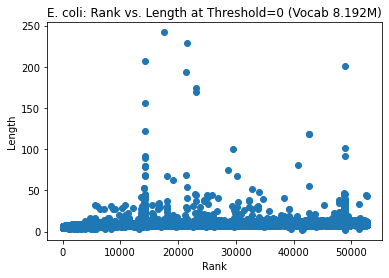

In [50]:
#Vocab vs. length
sorted_freq_lengths_cut=sorted_freq_lengths#[:1000]
# # print(sorted_freqs[:1000])
plt.scatter((np.arange(len(sorted_freq_lengths_cut))), (sorted_freq_lengths_cut))
plt.title('E. coli: Rank vs. Length at Threshold=0 (Vocab 8.192M)')
plt.xlabel('Rank')
plt.ylabel('Length')


(2, 2, 2, 3, 3, 3, 3, 3, 3, 3)
CPU times: user 715 ms, sys: 35.9 ms, total: 751 ms
Wall time: 750 ms


Text(0, 0.5, 'Log10 frequency')

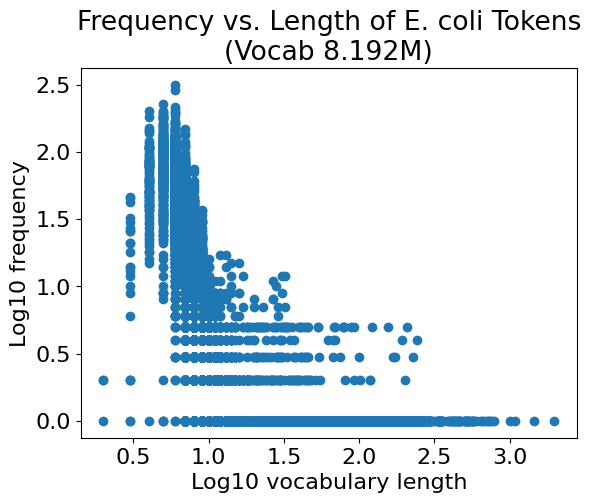

In [46]:
%%time

#vocab length vs frequency
vocab_sorted_vocab_frequency =sorted(zip(sorted_freq_lengths, sorted_freq_values))
vs_vocab_lens, vs_freqs = zip(*vocab_sorted_vocab_frequency)
print(vs_vocab_lens[:10])
plt.scatter(np.log10(vs_vocab_lens), np.log10(vs_freqs))
plt.rcParams.update({'font.size': 16})
plt.title("Frequency vs. Length of E. coli Tokens\n(Vocab 8.192M)")
plt.xlabel("Log10 vocabulary length")
plt.ylabel("Log10 frequency")


# Model Genomes


In [122]:
directory ='/gpfs/data/johnsonslab/nlp-genomics/model_genomes/'

files = ['Bacteroides fragilis strain FDAARGOS_1225 chromosome, complete genome.fasta',
'Bifidobacterium adolescentis strain 1-11 chromosome, complete genome.fasta',
'Clostridioides difficile strain CD9501.fasta',
'Enterobacter cloacae strain GGT036 chromosome, complete genome.fasta',
'Escherichia coli str. K-12 substr. MG1655, complete genome.fasta',
'Fusobacterium nucleatum subsp. polymorphum strain NCTC10562 chromosome 1, complete sequence.fasta',
'Helicobacter pylori strain MT5135 chromosome, complete genome.fasta',
'Lactiplantibacillus plantarum strain SK151 chromosome, complete genome.fasta',
'Phocaeicola vulgatus ATCC 8482, complete sequence.fasta',
'Salmonella enterica subsp. enterica serovar Typhimurium str. LT2, complete genome.fasta']
names = ['B. fragilis', 'B. adolescentis','C. difficile', 'E. cloacae','E. coli', 'F. nucleatum', 
        'H. pylori', 'L. plantarum', 'P. vulgatus', 'S. enterica']
families = ['Bacteroidaceae', 'Bifidobacteriaceae', 'Clostridiaceae', 'Enterobacteriaceae', 'Enterobacteriaceae','Fusobacteriaceae',
           'Helicobacteraceae', 'Lactobacillaceae','Bacteroidaceae', 'Enterobacteriaceae']

## Setting Tokenization Threshold

In [123]:
threshold = 0
tokenize = partial(tokenize_with_length_threshold, length_threshold = threshold)


## TF-IDF on Model Genomes

In [49]:
%%time
from sklearn.feature_extraction.text import TfidfVectorizer

genomes = []
for file in files:
    path = os.path.join(directory, file)
    genome = retrieve_genomes(path, gzipped=False)
    
    genome = genome[list(genome.keys())[0]]
    genomes.append(genome)
vectorizer = TfidfVectorizer(lowercase=False, tokenizer=tokenize)
X = vectorizer.fit_transform(genomes)


/gpfs/home/jic286/.conda/envs/hyena-dna-new/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


CPU times: user 50.8 s, sys: 1.74 s, total: 52.6 s
Wall time: 55.5 s


### SVD on Model Genomes

In [50]:
%%time
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=2, n_iter=10, random_state=42)
df = svd.fit_transform(X)




CPU times: user 13.3 s, sys: 334 ms, total: 13.6 s
Wall time: 6.7 s


### Dendrogram on Truncated SVD of model genome TF-IDF

(10, 2)
[[ 4.          9.          0.03595383  2.        ]
 [ 5.          2.          0.06486465  2.        ]
 [ 8.          0.          0.07086587  2.        ]
 [10.          3.          0.07153019  3.        ]
 [12.          7.          0.0748787   3.        ]
 [ 6.         14.          0.165724    4.        ]
 [13.          1.          0.19673876  4.        ]
 [15.         16.          0.28892499  8.        ]
 [11.         17.          0.37742402 10.        ]]


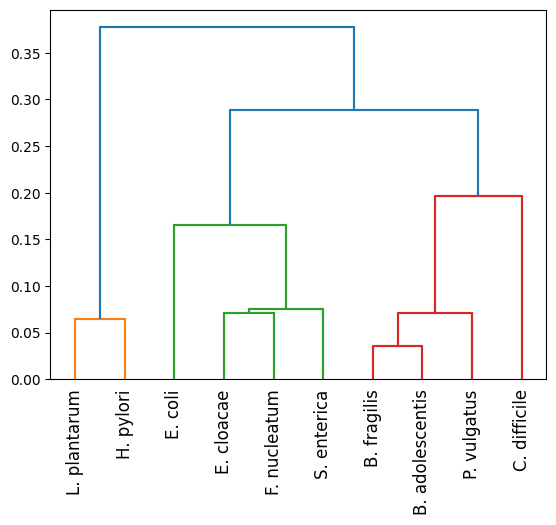

In [24]:
from scipy.cluster.hierarchy import dendrogram, linkage

data = df
print(data.shape)
# data = np.concatenate((data[5:,], data[:5,]), axis=0)
# print(data.shape)
# print(data[0,:10])
linkage_data = linkage(data,method='single', metric='euclidean', optimal_ordering=True)
print(linkage_data)
d = dendrogram(linkage_data)
labels =([names[l] for l in d['leaves']])
dendrogram(linkage_data, labels=labels)
plt.xticks(rotation='vertical')

plt.show()



(10,)
[7 3 0 6 1 0 4 5 2 1]


/gpfs/home/jic286/.conda/envs/hyena-dna-new/lib/python3.8/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


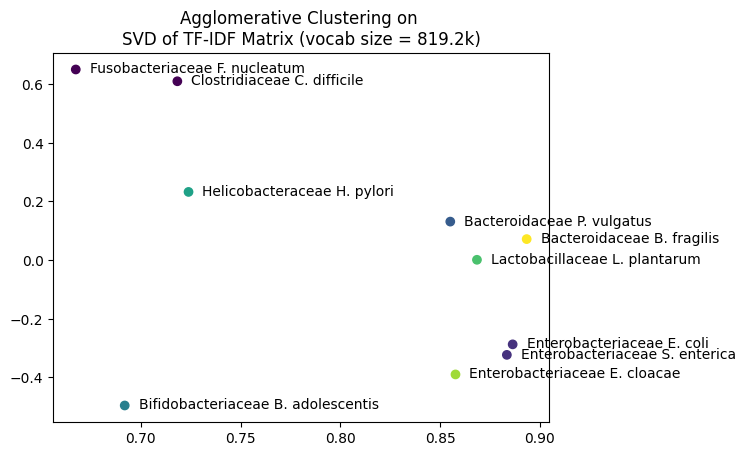

In [32]:
from sklearn.cluster import AgglomerativeClustering
data = df
print(df[:,0].shape)

hierarchical_cluster = AgglomerativeClustering(n_clusters=8, affinity='euclidean', linkage='ward')
labels = hierarchical_cluster.fit_predict(data) 
print(labels)
# for x, y in (df):
#     plt.scatter(x, y)
# plt.legend(names)

plt.scatter(df[:,0], df[:,1], c=labels)
for i, point in enumerate(df):
    plt.annotate(families[i] + " " +names[i], (point), textcoords='offset points', xytext=(10,-2.5))
plt.title("Agglomerative Clustering on \nSVD of TF-IDF Matrix (vocab size = 819.2k)")
plt.show()



# Experiments on Tokenizations of Model Genomes

## Unique and Non-Unique Tokens

### Retrieve Tokenizations

In [62]:
%%time
# tokenizations = []
# genome_lens = []
tokenizations, genome_lens= retrieve_tokenizations(files)

CPU times: user 44.1 s, sys: 2.5 s, total: 46.6 s
Wall time: 47 s


### Count tokens

In [63]:
token_dicts = []
for i, tokenization in enumerate(tokenizations):
    token_dicts.append({})
    for token in tokenization:
        if token in token_dicts[i].keys():
            token_dicts[i][token]+=1
        else:
            token_dicts[i][token] = 1


### Sort by GENOME length

In [77]:
sorted_genomes_names_dicts =sorted(zip( genome_lens, 
                                        names,
                                       families,
                                        token_dicts,
                                       tokenizations))
#gls = genome length-sorted
gls_genomes, gls_names, gls_families, gls_token_dicts, gls_tokenizations = zip(*sorted_genomes_names_dicts)


### Plot genome lengths

Text(0.5, 1.0, 'Genome Lengths')

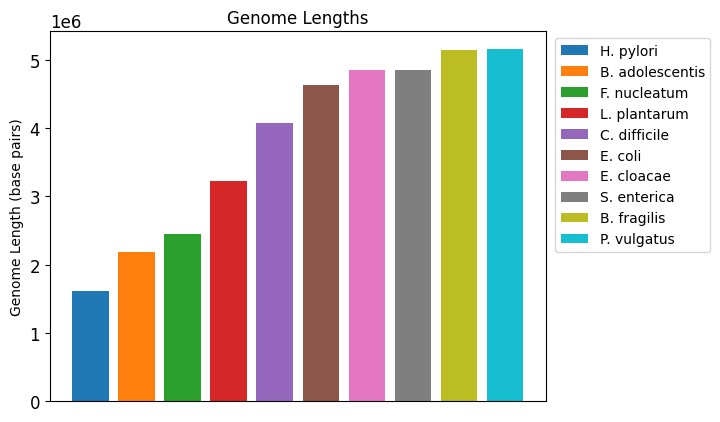

In [133]:
fig, ax = plt.subplots()
for i in range(len(gls_names)):
    ax.bar(i,gls_genomes[i])
# ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) #
plt.ylabel("Genome Length (base pairs)")
plt.legend(gls_names,bbox_to_anchor=(1.175,1),
          ncol=1, fancybox=True,  loc='upper center')
plt.title("Genome Lengths")


### Separate unique and non-unique tokens

In [80]:
tkns_unique = []
tkns_non_unique = []
unique_lens = []
non_unique_lens = []
tokenization_lens = []
for i, tokenization in enumerate(gls_tokenizations):
    tkns_unique.append([])
    tkns_non_unique.append([])
    for token in tokenization:
        if(gls_token_dicts[i][token]>1):
            tkns_non_unique[i].append(token)
        elif(gls_token_dicts[i][token]==1):
            tkns_unique[i].append(token)
    print("{}: {} unique tokens".format(gls_names[i], len(tkns_unique[i])))
    unique_lens.append(len(tkns_unique[i]))
    print("{}: {} non-unique tokens".format(gls_names[i], len(tkns_non_unique[i])))
    non_unique_lens.append(len(tkns_non_unique[i]))
    tokenization_lens.append(len(tokenization))


H. pylori: 56787 unique tokens
H. pylori: 134368 non-unique tokens
B. adolescentis: 82601 unique tokens
B. adolescentis: 148896 non-unique tokens
F. nucleatum: 73531 unique tokens
F. nucleatum: 200909 non-unique tokens
L. plantarum: 106138 unique tokens
L. plantarum: 280624 non-unique tokens
C. difficile: 106738 unique tokens
C. difficile: 358346 non-unique tokens
E. coli: 149744 unique tokens
E. coli: 359593 non-unique tokens
E. cloacae: 143963 unique tokens
E. cloacae: 423331 non-unique tokens
S. enterica: 145285 unique tokens
S. enterica: 424303 non-unique tokens
B. fragilis: 165400 unique tokens
B. fragilis: 405197 non-unique tokens
P. vulgatus: 147414 unique tokens
P. vulgatus: 261626 non-unique tokens


### Plotting tokenization length in tokens vs. genome length


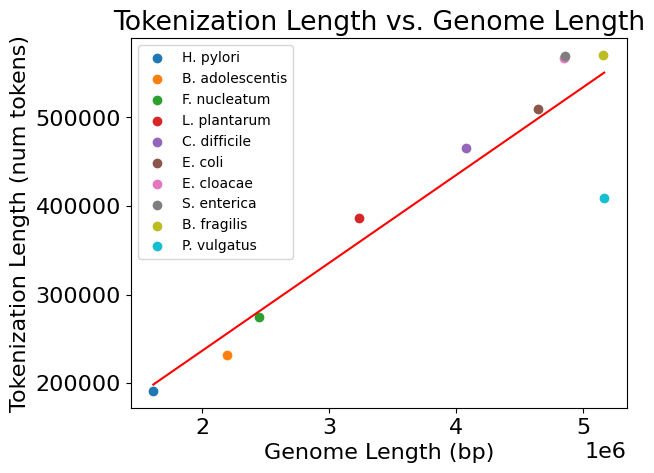

In [81]:
fig, ax = plt.subplots()
for i, genome_len in enumerate(gls_genomes):
    ax.scatter(genome_len, tokenization_lens[i])
    
#best fit line
x = np.array(gls_genomes).reshape(len(gls_genomes), 1)
X = np.append(x, np.ones((len(gls_genomes), 1)), axis=1)
y = np.array(tokenization_lens).reshape(len(tokenization_lens), 1)
theta = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
y_line = X.dot(theta)
ax.plot(x, y_line, 'r')
ax.set_ylabel("Tokenization Length (num tokens)")
ax.set_xlabel('Genome Length (bp)')
ax.set_title("Tokenization Length vs. Genome Length")


ax.legend(gls_names, fontsize="10")
plt.show()

### Plotting genome length vs. ratios of unique to non-unique 

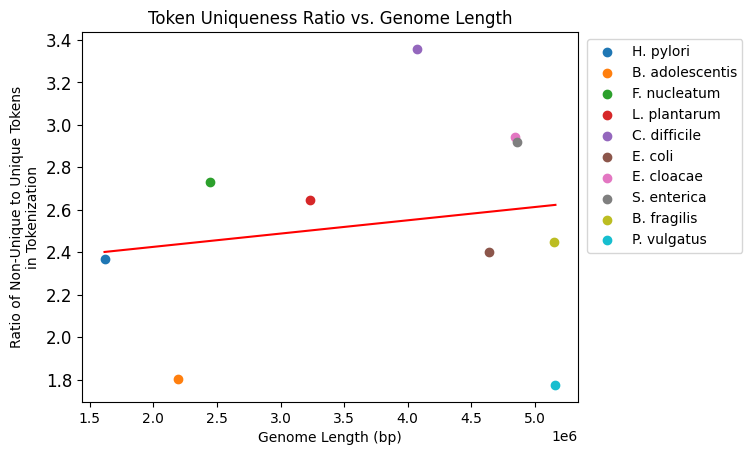

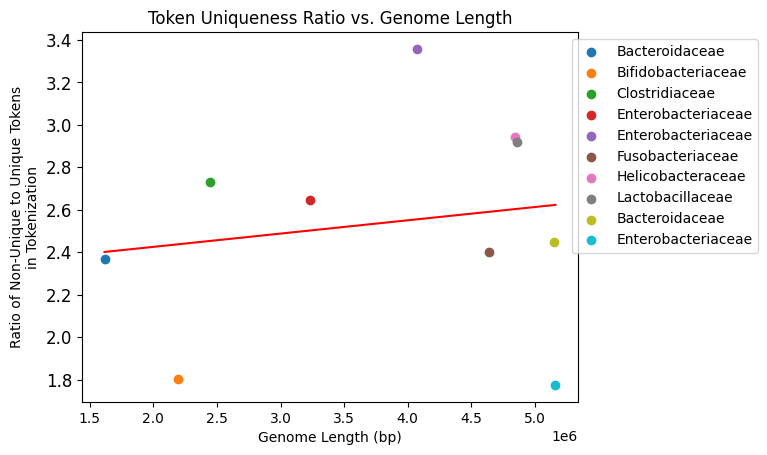

In [136]:
fig, ax = plt.subplots()
tkn_ratios = [len(tkns_non_unique[i])/len(tkns_unique[i]) for i in range(len(tkns_unique))]
for i, genome_len in enumerate(gls_genomes):
    ax.scatter(genome_len, tkn_ratios[i])
#best fit line
x = np.array(gls_genomes).reshape(len(gls_genomes), 1)
X = np.append(x, np.ones((len(gls_genomes), 1)), axis=1)
y = np.array(tkn_ratios).reshape(len(tkn_ratios), 1)
theta = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
y_line = X.dot(theta)
ax.plot(x, y_line, 'r')
ax.set_ylabel("Ratio of Non-Unique to Unique Tokens\nin Tokenization")
ax.set_xlabel('Genome Length (bp)')
ax.set_title("Token Uniqueness Ratio vs. Genome Length")


ax.legend(gls_names, bbox_to_anchor=(1.175,1),
          ncol=1, fancybox=True,  loc='upper center')
plt.show()

fig, ax = plt.subplots()
tkn_ratios = [len(tkns_non_unique[i])/len(tkns_unique[i]) for i in range(len(tkns_unique))]
for i, genome_len in enumerate(gls_genomes):
    ax.scatter(genome_len, tkn_ratios[i])
    
#combining families plus names
gls_fams_names = ["{} {}".format(gls_families[i], gls_names[i]) for i in range(len(gls_families))]
#best fit line
x = np.array(gls_genomes).reshape(len(gls_genomes), 1)
X = np.append(x, np.ones((len(gls_genomes), 1)), axis=1)
y = np.array(tkn_ratios).reshape(len(tkn_ratios), 1)
theta = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
y_line = X.dot(theta)
ax.plot(x, y_line, 'r')
ax.set_ylabel("Ratio of Non-Unique to Unique Tokens\nin Tokenization")
ax.set_xlabel('Genome Length (bp)')
ax.set_title("Token Uniqueness Ratio vs. Genome Length")


ax.legend(families, bbox_to_anchor=(1.175,1),
          ncol=1, fancybox=True,  loc='upper center')
plt.show()




In [140]:
from scipy.stats import linregress
slope, intercept, r_value, p_value, std_err = linregress(gls_genomes, tkn_ratios)
print("R: ", r_value, '\nR squared: ', r_value**2)

R:  0.16932960219178092 
R squared:  0.028672514178426776


## Measuring Shared Tokens

### Retrieve Tokenizations

In [9]:
%%time
tokenizations = []
genome_lens = []
for file in files:
    path = os.path.join(directory, file)
    genome = retrieve_genomes(path, gzipped=False)
    
    genome = genome[list(genome.keys())[0]]
    genome_lens.append(len(genome))
    freqs = {}
    threshold = 0
    tokenizations.append(tokenize(genome, length_threshold=threshold))


CPU times: user 32.6 s, sys: 692 ms, total: 33.3 s
Wall time: 33.7 s


### Get total vocabulary

In [10]:
import itertools
for i, tokenization in enumerate(tokenizations):
    print('Vocabulary size of {}: {}'.format(names[i], len(set(tokenization))))
all_tokens = list(itertools.chain(*tokenizations))
all_tokens = set(all_tokens)
print("Total vocabulary size: ", len(all_tokens))

Vocabulary size of B. fragilis: 222863
Vocabulary size of B. adolescentis: 109204
Vocabulary size of C. difficile: 153547
Vocabulary size of E. cloacae: 200527
Vocabulary size of E. coli: 202456
Vocabulary size of F. nucleatum: 103504
Vocabulary size of H. pylori: 78774
Vocabulary size of L. plantarum: 146916
Vocabulary size of P. vulgatus: 191263
Vocabulary size of S. enterica: 202281
Total vocabulary size:  883827


## Rank vs. Length

In [11]:
%%time
token_dict = {token: set() for token in all_tokens}
for i, tokenization in enumerate(tokenizations):
    #for each tokenization, assign a set of unique values
#     print(len(tokenization), len(set(tokenization)))
    token_set = (set(tokenization))
#     special_token = ""
#     print(type(tokenization), type(token_set))
    print(token_dict['GTGCGGATAGTTTTCTGCGTAAT'])

    for j, token in enumerate(all_tokens):
        #for each token, check if the unique value exists in the tokenization

        if token in token_set:
            if(token =='GTGCGGATAGTTTTCTGCGTAAT'):
                print(i, 'GTGCGGATAGTTTTCTGCGTAAT' in token_set)
            token_dict[token].add(i)
            
        else:
            
        
#             token_dict[token].remove(i)
            if(token=='GTGCGGATAGTTTTCTGCGTAAT'):
                print(i, 'GTGCGGATAGTTTTCTGCGTAAT' in token_set)
# #            if(token not in token_set)
#         if(token=='GTGCGGATAGTTTTCTGCGTAAT'):
#             print(token_dict['GTGCGGATAGTTTTCTGCGTAAT'])
#         if(token not in token_set):
#             if(i in token_dict[token]):
#                 token_dict[token].remove(i)
        if(token=='GTGCGGATAGTTTTCTGCGTAAT'):
            print(token_dict['GTGCGGATAGTTTTCTGCGTAAT'])
    
#         else:
#             print(i, token)
# for token in all_tokens:
#     token_dict[token]=[]
#     for i, tokenization in enumerate(tokenizations):
#         if token in set(tokenization):
#             token_dict[token].append(i)
# print(len(token_dict[list(all_tokens)[i]]))

set()
0 False
set()
set()
1 False
set()
set()
2 False
set()
set()
3 False
set()
set()
4 True
{4}
{4}
5 False
{4}
{4}
6 False
{4}
{4}
7 False
{4}
{4}
8 False
{4}
{4}
9 False
{4}
CPU times: user 7.63 s, sys: 145 ms, total: 7.78 s
Wall time: 7.78 s


In [39]:
np.random.seed(42)
all_tokens = ['a', 'b', 'c', 'd', 'e', 'f', 'g']
print(tokenizations)
tokenizations = [[all_tokens[np.random.randint(0, len(all_tokens))] for i in range(4)] for i in range(10)]
token_dict = dict.fromkeys(all_tokens, set())
for i, tokenization in enumerate(tokenizations):
    token_set = ((tokenization))
    for token in all_tokens:
        #for each token in the total vocabulary, check if the unique value exists in the tokenization
        if token in token_set:
            token_dict[token].add(i)
        if(token=='g'):
            print(token in token_set)

print(token)
print(token_dict[token])

[['g', 'd', 'e', 'g'], ['c', 'e', 'e', 'g'], ['b', 'c', 'g', 'c'], ['c', 'e', 'd', 'c'], ['f', 'e', 'b', 'd'], ['f', 'f', 'b', 'd'], ['e', 'a', 'd', 'b'], ['f', 'e', 'd', 'a'], ['a', 'c', 'c', 'g'], ['b', 'd', 'd', 'g']]
True
True
True
False
False
False
False
False
True
True
g
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}


In [40]:
import numpy as np
np.random.seed(42)

all_tokens = ['a', 'b', 'c', 'd', 'e', 'f', 'g']

tokenizations = [[all_tokens[np.random.randint(0, len(all_tokens))] for i in range(4)] for i in range(10)]
token_dict = dict.fromkeys(all_tokens, set())
for i, tokenization in enumerate(tokenizations):
    token_set = set(tokenization)
    for token in all_tokens:
        #for each token in the total vocabulary, check if the unique value exists in the tokenization
        if token in token_set:
            token_dict[token].add(i)
        if(token=='g'):
            print(token in token_set)


print(token)
print(token_dict[token])



True
True
True
False
False
False
False
False
True
True
g
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}


In [12]:
universal_tokens = 0
isolated_tokens = 0 ###unique to their families, isolated to avoid confusion with single appearance tokens
for token_family in token_dict.values():
    if(len(token_family)==len(names)):
        universal_tokens+=1
    elif(len(token_family)==1):f 
        isolated_tokens +=1
print('GTGCGGATAGTTTTCTGCGTAAT' in tokenizations[0])
print(token_dict['GTGCGGATAGTTTTCTGCGTAAT'])
print(len(token_family), len(names))
print("{} tokens appear in all tokenizations".format(universal_tokens))
print("{} tokens are unique to one tokenization".format(isolated_tokens))
print("{} tokens are shared between at least two tokenizations".format(len(all_tokens)-(universal_tokens + isolated_tokens)))

False
{4}
1 10
7242 tokens appear in all tokenizations
592927 tokens are unique to one tokenization
283658 tokens are shared between at least two tokenizations


### Getting token lengths per uniqueness category

In [24]:
universal_token_list = []
isolated_token_list = []
shared_token_list = []

for token_family in token_dict.items():
    if(len(token_family[1])==len(names)):
        universal_token_list.append(token_family[0])
    elif(len(token_family[1])==1):
        isolated_token_list.append(token_family[0])
    else:
        shared_token_list.append(token_family[0])

universal_token_list = sorted(universal_token_list, key=len, reverse=True)
isolated_token_list = sorted(isolated_token_list, key=len, reverse=True)
shared_token_list = sorted(shared_token_list, key=len, reverse=True)
univ_max_len = len(universal_token_list[0])
iso_max_len = len(isolated_token_list[0])
share_max_len = len(shared_token_list[0])
univ_min_len = len(universal_token_list[-1])
iso_min_len = len(isolated_token_list[-1])
share_min_len = len(shared_token_list[-1])

print("Length of longest universal token:", univ_max_len)
print("Length of longest isolated token:", iso_max_len)
print('Length of longest shared token:', share_max_len)
print("Length of shortest universal token:", univ_min_len)
print("Length of shortest isolated token:", iso_min_len)
print("Length of shortest shared token:", share_min_len)


Length of longest universal token: 10
Length of longest isolated token: 3583
Length of longest shared token: 242
Length of shortest universal token: 3
Length of shortest isolated token: 1
Length of shortest shared token: 2


In [25]:
print(shared_token_list[0])

AGGTCATAGTGATCCGGTGGTTCTGAATGGAAGGGCCATCGCTCAACGGATAAAAGGTACTCCGGGGATAACAGGCTGATACCGCCCAAGAGTTCATATCGACGGCGGTGTTTGGCACCTCGATGTCGGCTCATCACATCCTGGGGCTGAAGTAGGTCCCAAGGGTATGGCTGTTCGCCATTTAAAGTGGTACGCGAGCTGGGTTTAGAACGTCGTGAGACAGTTCGGTCCCTATCTGCCGT


Text(0.5, 1.0, 'Length of Longest Token in Each Group')

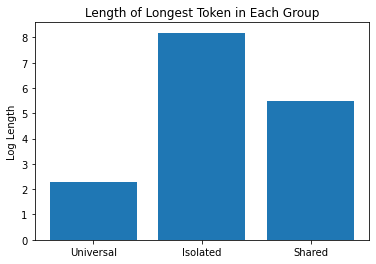

In [34]:
plt.bar(['Universal', 'Isolated', "Shared"],np.log([univ_max_len, iso_max_len, share_max_len]))
plt.ylabel('Log Length')
plt.title('Length of Longest Token in Each Group')

### Counting token categories in tokenizations

In [ ]:
%%time
univ_count = 0
iso_count = 0
share_count = 0
for tokenization in tokenizations:
    for token in tokenization:
        if(token in universal_token_list):
            univ_count += 1
        elif(token in isolated_token_list):
            iso_count += 1
        else:
            share_count +=1
print(univ_count)
print(iso_count)
print(share_count)

In [33]:
univ_count= 1391258
iso_count = 632365
share_count = 2151171
print(sum((univ_count, iso_count, share_count)))

4174794


Text(0.5, 1.0, 'Sharedness of Tokens by Appearance in Tokenization')

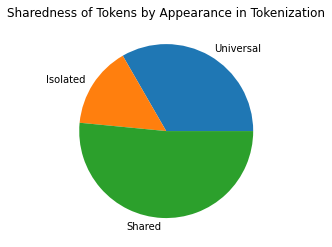

In [31]:
fig, ax = plt.subplots()
ax.pie([univ_count, iso_count, share_count], labels=["Universal", "Isolated", "Shared"])
ax.set_title("Sharedness of Tokens by Appearance in Tokenization")

# Rank/Frequency Experiments on Model Genomes

### Retrieve tokenizations for each genome

In [124]:
tokenizations, genome_lens = retrieve_tokenizations(files)


## Measuring Rank vs. Length across all genomes

In [125]:
freqs = {}
tokenization_lengths = []
for tokens in tokenizations:
    tokenization_lengths.append(len(tokens))
    for token in tokens:
        if token not in freqs.keys():
            freqs[token] = 1
        else:
            freqs[token]+=1
sorted_freqs = (sorted(freqs.items(), key=operator.itemgetter(1), reverse=True))
print(len(sorted_freqs))
print(sum(tokenization_lengths)/len(tokenization_lengths))

883827
417479.4


883827
3583
322270
CPU times: user 3.74 s, sys: 180 ms, total: 3.92 s
Wall time: 3.93 s


Text(0, 0.5, 'Length')

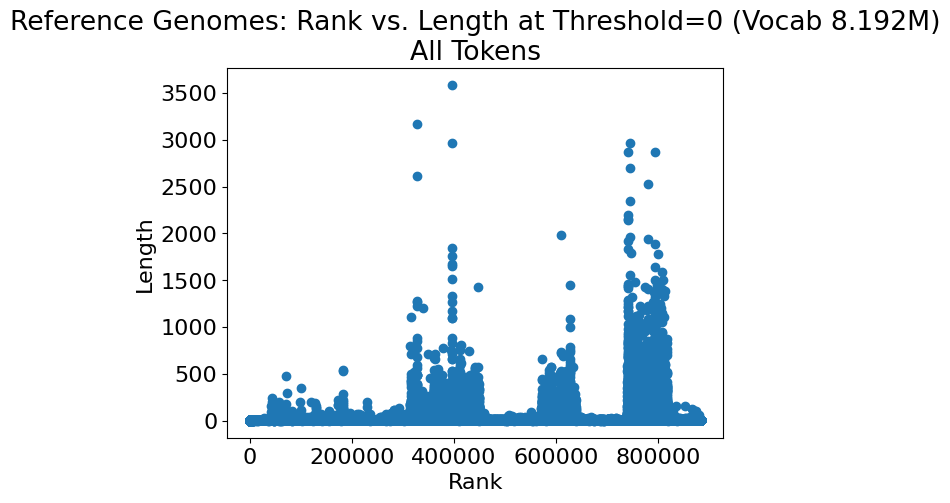

In [126]:
%%time
freq_threshold=0
sorted_freq_values = []
sorted_freq_lengths = []
length_threshold = 0
for freq in sorted_freqs:
    sorted_freq_values.append(freq[1])
    if(freq[1]>freq_threshold):
        if(len(freq[0])>length_threshold):
            if(freq[0][0]=="_"):
                sorted_freq_lengths.append(len(freq[0][1:]))
            else:
                sorted_freq_lengths.append(len(freq[0]))

print(len(sorted_freq_lengths))
print(max(sorted_freq_lengths))
for i in range(len(sorted_freq_values)):
    if(sorted_freq_values[i]==1):
        print(i-1)
        break
    
sorted_freq_lengths_cut=sorted_freq_lengths[:]
# print(sorted_freqs[:1000])
plt.scatter((np.arange(len(sorted_freq_lengths_cut))), (sorted_freq_lengths_cut))
plt.title('Reference Genomes: Rank vs. Length at Threshold=0 (Vocab 8.192M)\nAll Tokens')
plt.xlabel('Rank')
plt.ylabel('Length')

## Length quartiles

{'bodies': [<matplotlib.collections.PolyCollection at 0x1554fed10670>],
 'cmaxes': <matplotlib.collections.LineCollection at 0x1554fed10580>,
 'cmins': <matplotlib.collections.LineCollection at 0x1554fed10c10>,
 'cbars': <matplotlib.collections.LineCollection at 0x1554fed10f70>}

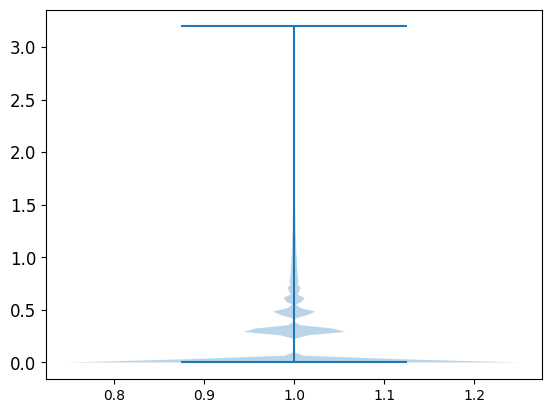

In [204]:
from scipy.stats import iqr
plt.violinplot(np.log10(sorted_freq_values) )

## Measuring top 50% and hapax legomena

In [184]:
total = 0
half_threshold = sum(sorted_freq_values)/2
for i, val in enumerate(sorted_freq_values):
    total+=val
    if total>= half_threshold:
        break
top_50_token_num = i + 1
print("50% of tokens made up of {} types ({:2f}% of types)".format(top_50_token_num, 100.0 * top_50_token_num/len(sorted_freq_values)))

50% of tokens made up of 15196 types (1.719341% of types)


In [189]:
for i in range(len(sorted_freq_values) - 1, 0, -1):
    if sorted_freq_values[i] >1:
        break
print("Number of hapax legomena: {} ({:2f}% of types)".format(len(sorted_freq_values)-i-1, 100.0 * (len(sorted_freq_values)-i-1)/len(sorted_freq_values)))

Number of hapax legomena: 561556 (63.536869% of types)


In [64]:
%%time
# tokenizations = []
# genome_lens = []
# for file in files:
#     path = os.path.join(directory, file)
#     genome = retrieve_genomes(path, gzipped=False)
    
#     genome = genome[list(genome.keys())[0]]
#     genome_lens.append(len(genome))
#     freqs = {}
#     threshold = 0
#     tokenizations.append(tokenize(genome, length_threshold=threshold))
#retrieve token frequencies for each tokenization
sorted_freqs = []

for tokens in tokenizations:
    freqs = {}
    for token in tokens:
        if token not in freqs.keys():
            freqs[token] = 1
        else:
            freqs[token]+=1
    sorted_freqs.append(sorted(freqs.items(), key=operator.itemgetter(1), reverse=True))
print(len(sorted_freqs))

10
CPU times: user 2.61 s, sys: 69.8 ms, total: 2.68 s
Wall time: 2.68 s


### Inspecting top tokens for each genome

In [61]:
print(len(sorted_freq_values))
for i, tokens in enumerate(sorted_freq_values):
    print(names[i])
    for j in range(10):
        print(tokens[j][0])

883827
B. fragilis


TypeError: 'int' object is not subscriptable

## Extracting sorted frequencies and lengths and ordering the samples by vocabulary size (frequency threshold 0)

In [66]:
%%time
freq_threshold=0
sorted_freq_values = []
sorted_freq_lengths = []

for i, freqs in enumerate(sorted_freqs):
    sorted_freq_values.append([])
    sorted_freq_lengths.append([])
    for freq in freqs:
        sorted_freq_values[i].append(freq[1])
        if(freq[1]>freq_threshold):
            if(freq[0][0]=="_"):
                sorted_freq_lengths[i].append(len(freq[0][1:]))
            else:
                sorted_freq_lengths[i].append(len(freq[0]))
for i, vals in enumerate(sorted_freq_values):
    print(names[i], len(vals), vals[0])
#log10 rank vs. frequency
print("-"*20)
#sort groups by length of vocabulary
sorted_freq_vals_names_lens =sorted(zip( [len(val) for val in sorted_freq_values],
                                        names,
                                        families,
                                        sorted_freq_values, 
                                        sorted_freq_lengths, 
                                        genome_lens,
                                        [len(tokenization) for tokenization in tokenizations]))
#ls = len-sorted
for item in sorted_freq_vals_names_lens:
    print( item[2],item[1],item[0], item[3][0], str(item[5]) + "bp")
ls_vocab_lens, ls_names, ls_families, ls_freq_vals, ls_token_lens, ls_genome_lens, ls_tkz_lens = zip(*sorted_freq_vals_names_lens)



B. fragilis 222863 169
B. adolescentis 109204 142
C. difficile 153547 381
E. cloacae 200527 416
E. coli 202456 314
F. nucleatum 103504 262
H. pylori 78774 255
L. plantarum 146916 437
P. vulgatus 191263 105
S. enterica 202281 414
--------------------
Helicobacteraceae H. pylori 78774 255 1615199bp
Fusobacteriaceae F. nucleatum 103504 262 2443126bp
Bifidobacteriaceae B. adolescentis 109204 142 2192428bp
Lactobacillaceae L. plantarum 146916 437 3231249bp
Clostridiaceae C. difficile 153547 381 4077288bp
Bacteroidaceae P. vulgatus 191263 105 5163189bp
Enterobacteriaceae E. cloacae 200527 416 4848754bp
Enterobacteriaceae S. enterica 202281 414 4857450bp
Enterobacteriaceae E. coli 202456 314 4641652bp
Bacteroidaceae B. fragilis 222863 169 5150703bp
CPU times: user 988 ms, sys: 7.01 ms, total: 995 ms
Wall time: 997 ms


/gpfs/home/jic286/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


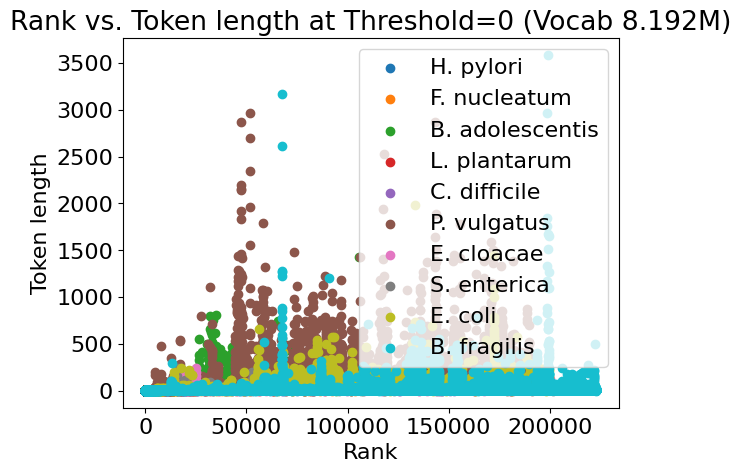

In [67]:
# figure(figsize=(8, 7), dpi=80)
for i, freqs in enumerate(ls_token_lens):
    plt.scatter((np.arange(len(freqs))), (freqs))
    plt.xlabel('Rank')
    plt.ylabel('Token length')
plt.title('Rank vs. Token length at Threshold=0 (Vocab 8.192M)')

plt.legend(ls_names)
plt.show()

In [ ]:
### Vocabulary sizes by species

In [ ]:
fig, ax = plt.subplots()
for i in range(len(ls_names)):
    ax.bar(i,ls_vocab_lens[i])
# ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) #
plt.ylabel("Vocabulary Size")
plt.legend(ls_names,bbox_to_anchor=(1.175,1),
          ncol=1, fancybox=True,  loc='upper center')
plt.title("Vocabulary Sizes at Threshold=0 (Vocab 8.192M)")


### Plotting mean/median token lengths

Text(0.5, 1.0, 'Mean Token Lengths (bases)\n(Vocab size 8.192M)')

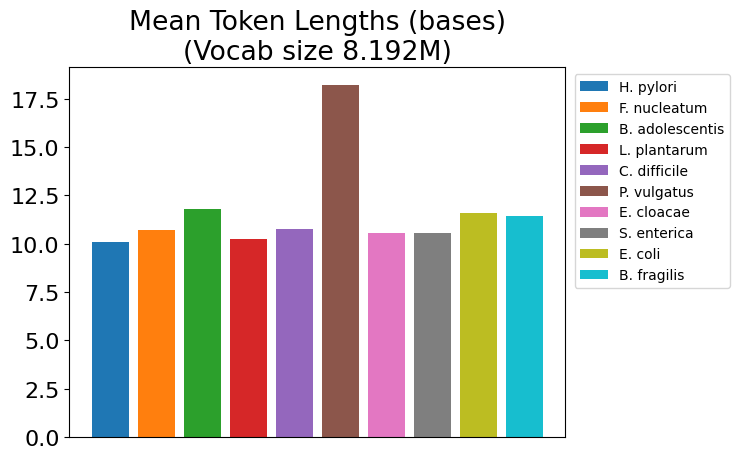

In [130]:
from matplotlib.pyplot import figure
# figure(figsize_8, 8), dpi=80)
plt.rcParams.update({'font.size': 16})
for i in range(len(ls_names)):
    plt.bar(i,np.mean(ls_token_lens[i]))#/(ls_vocab_lens[i]))
    
plt.legend(ls_names,bbox_to_anchor=(1.175,1),
          ncol=1, fancybox=True,  loc='upper center', fontsize="10")
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) #
plt.title("Mean Token Lengths (bases)\n(Vocab size 8.192M)")


Text(0.5, 1.0, 'Median Token Lengths (bases)\n(Vocab Size 8.192M)')

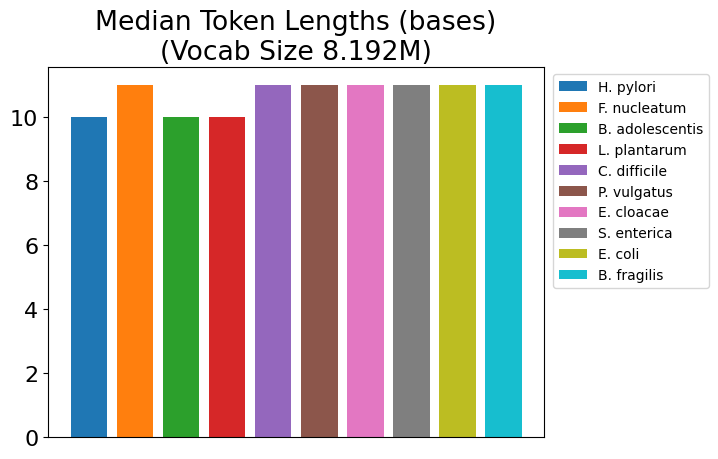

In [131]:
from matplotlib.pyplot import figure
# figure(figsize_8, 8), dpi=80)
plt.rcParams.update({'font.size': 16})

for i in range(len(ls_names)):
    plt.bar(i,np.median(ls_token_lens[i]))#/(ls_vocab_lens[i]))
    
plt.legend(ls_names,bbox_to_anchor=(1.175,1),
          ncol=1, fancybox=True,  loc='upper center', fontsize="10")
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) #
plt.title("Median Token Lengths (bases)\n(Vocab Size 8.192M)")


### Plotting Mean token length vs. Number of tokens

In [ ]:
# figure(figsize=(8, 7), dpi=80)
for i, lens in enumerate(ls_token_lens):
    plt.scatter(ls_genome_lens[i],np.mean(lens))
plt.legend(ls_names)
plt.title('Genome length vs. Mean Token Length')
plt.xlabel("Genome length (Mbp)")
plt.ylabel("Mean token length (bbp)")

### Plotting Mean Token Length vs Vocabulary Size

In [ ]:
# figure(figsize=(8, 7), dpi=80)
for i, lens in enumerate(ls_token_lens):
    plt.scatter(ls_vocab_lens[i],np.mean(lens))
plt.legend(ls_names)
plt.title('Vocabulary Size vs. Mean Token Length')
plt.xlabel("Vocabulary Size")
plt.ylabel("Mean token length (bp)")

### Plotting Mean Token Length vs. Tokenization Length

In [ ]:
# figure(figsize=(8, 7), dpi=80)
for i, lens in enumerate(ls_token_lens):
    plt.scatter(ls_tkz_lens[i],np.mean(lens))
plt.legend(ls_names)
plt.title('Tokenization Length vs. Mean Token Length')
plt.xlabel("Tokenization Length")
plt.ylabel("Mean token length (bp)")

### Plotting Token Vocabulary vs. Tokenization Length

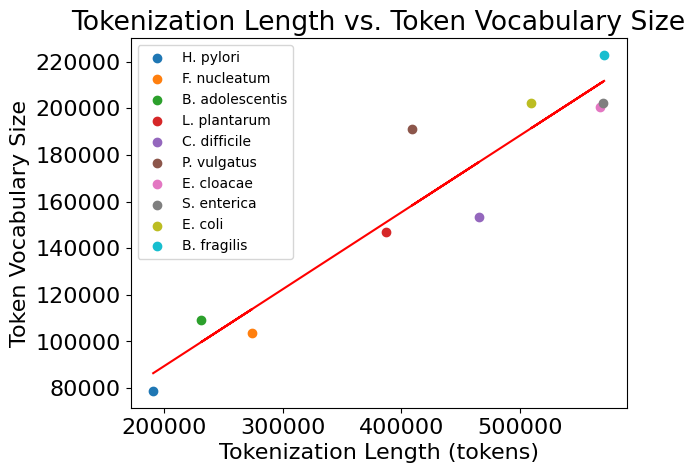

In [83]:
plt.rcParams.update({'font.size': 16})
for i, name in enumerate(ls_names):
    plt.scatter(ls_tkz_lens[i], ls_vocab_lens[i])
plt.legend(ls_names, fontsize="10")
plt.xlabel("Tokenization Length (tokens)")
plt.ylabel("Token Vocabulary Size")
plt.title("Tokenization Length vs. Token Vocabulary Size")
x = np.array(ls_tkz_lens).reshape(len(ls_tkz_lens), 1)
X = np.append(x,np.ones((len(ls_tkz_lens), 1)), axis=1)
y = np.array(ls_vocab_lens).reshape(len(ls_vocab_lens), 1)
theta = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
y_line = X.dot(theta)
plt.plot(x, y_line, 'r')



### Plotting token frequencies vs. log10 rank for each genome


In [ ]:
%%time
#Fitting curve

def objective(x, a, b):
    return (a * x**b)
x = (np.arange(1, len(freqs)+1))
popt, _ = curve_fit(objective,x[:500], ls_freq_vals[:500])
a, b = popt
print(a, b)
plt.plot(np.log10(x[:500]), objective(x[:500], a, b))


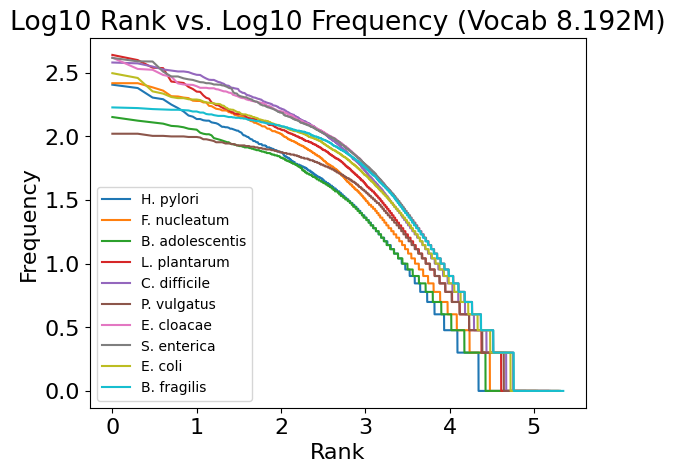

In [73]:
from matplotlib.pyplot import figure

# figure(figsize=(8, 8), dpi=80)
plt.rcParams.update({'font.size': 16})
for i, freqs in enumerate(ls_freq_vals):
    plt.plot(np.log10(np.arange(1,len(freqs)+1)), np.log10(freqs))
    plt.xlabel('Rank')
    plt.ylabel('Frequency')
# plt.plot(np.log10(x[:500]), objective(x[:500], a, b))

plt.title('Log10 Rank vs. Log10 Frequency (Vocab 8.192M)')
#ls_families[i] + " " + 
# plt.legend([ls_families[i] + " "+ls_names[i] for i in range(len(ls_names))], loc='upper right', fontsize="10")
plt.legend(ls_names, fontsize="10")
plt.show()

### Plotting Token Rank vs. Length

In [ ]:
for i, lens in enumerate(ls_token_lens):
    plt.plot(np.log10(np.arange(1, len(lens)+1))[:1000], np.log10(lens)[:1000])#, marker='o', alpha=0.5)
    plt.xlabel('Rank')
    plt.ylabel('Token length')
plt.title('Log10 Rank vs. Log10 Token length at Threshold=0 (Vocab 8.192M)')
plt.rcParams.update({'font.size': 16})

plt.legend(ls_names)
plt.show()

### Plotting Length vs. Frequency

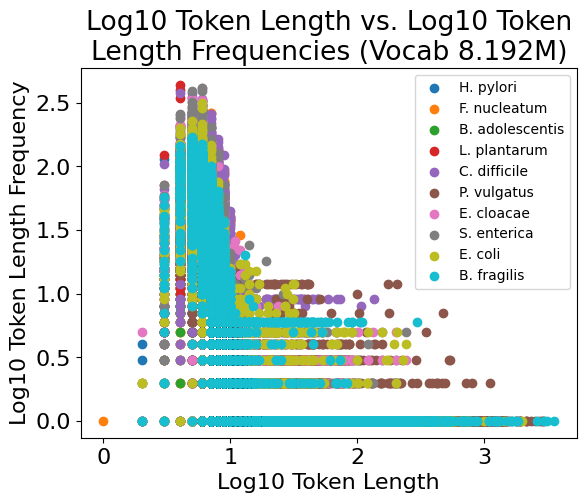

CPU times: user 12.6 s, sys: 985 ms, total: 13.6 s
Wall time: 13.6 s


In [69]:
%%time
plt.rcParams.update({'font.size': 16})

for i, lens in enumerate(ls_token_lens):
    plt.scatter( np.log10(lens), np.log10(ls_freq_vals[i]))
    plt.xlabel('Log10 Token Length')
    plt.ylabel('Log10 Token Length Frequency')
   
plt.title('Log10 Token Length vs. Log10 Token\nLength Frequencies (Vocab 8.192M)')

plt.legend(ls_names, fontsize="10")
plt.show()

## Plotting vocab size vs. genome

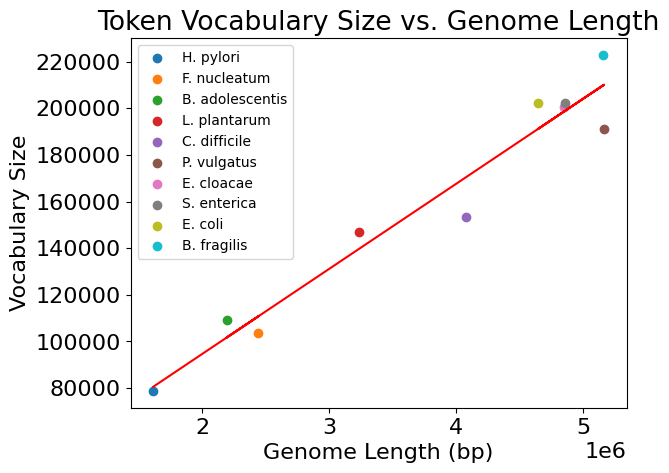

In [75]:
fig, ax = plt.subplots()
for i in range(len(ls_names)):
    ax.scatter(ls_genome_lens[i],ls_vocab_lens[i] )
ax.legend(ls_names, fontsize="10")    
plt.rcParams.update({'font.size': 16})
ax.set_ylabel("Vocabulary Size")
ax.set_xlabel('Genome Length (bp)')
ax.set_title("Token Vocabulary Size vs. Genome Length")

#best fit line
x = np.array(ls_genome_lens).reshape(len(ls_genome_lens), 1)
X = np.append(x,np.ones((len(ls_genome_lens), 1)), axis=1)
y = np.array(ls_vocab_lens).reshape(len(ls_vocab_lens), 1)
theta = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
y_line = X.dot(theta)
ax.plot(x, y_line, 'r')

# for i, txt in enumerate(ls_names):
#     plt.annotate(txt, (ls_vocab_lens[i], ls_genome_lens[i]))
plt.show()


## Investigating vocabulary sizes while removing single appearance tokens

In [147]:
%%time
freq_length_threshold=0
freq_threshold=1
sorted_freq_values = []
sorted_freq_lengths = []
sorted_freq_lengths_unique = []
sorted_freq_values_thresholded =[]

for i, freqs in enumerate(sorted_freqs):
    sorted_freq_values.append([])
    sorted_freq_lengths.append([])
    sorted_freq_values_thresholded.append([])
    sorted_freq_lengths_unique.append({})

    for freq in freqs:
        if(freq[1]>freq_threshold):
            sorted_freq_values_thresholded[i].append(freq[1])
        else:
            if(freq[0][0]=="_"):
                #count frequencies of lengths from unique tokens
                if(len(freq[0]) not in sorted_freq_lengths_unique[i].keys()):
                    sorted_freq_lengths_unique[i][(len(freq[0][1:]))] =1
                else:
                    sorted_freq_lengths_unique[i][(len(freq[0][1:]))] +=1
            else:
                if(len(freq[0]) not in sorted_freq_lengths_unique[i].keys()):
                    
                    sorted_freq_lengths_unique[i][len(freq[0])] =1
                else:
                    
                    sorted_freq_lengths_unique[i][len(freq[0])] +=1

        sorted_freq_values[i].append(freq[1])
        if(freq[1]>freq_length_threshold):
            if(freq[0][0]=="_"):
                sorted_freq_lengths[i].append(len(freq[0][1:]))
            else:
                sorted_freq_lengths[i].append(len(freq[0]))
# for i, vals in enumerate(sorted_freq_values):
    
#     print(names[i], len(vals), vals[0])
#log10 rank vs. frequency
print("-"*20)
sorted_freq_vals_names_lens =sorted(zip( [len(val) for val in sorted_freq_values], 
                                        names,
                                        sorted_freq_values, 
                                        [len(item) for item in sorted_freq_values_thresholded],
                                        sorted_freq_lengths_unique,
                                        sorted_freq_lengths, 
                                        genome_lens))
#ls = length-sorted
for i, item in enumerate(sorted_freq_vals_names_lens):
    print(item[1], "total vocabulary:", str(item[0])+",","non-unique vocabulary:", item[3])
ls_vocab_lens, ls_names, ls_freq_vals, ls_vocab_lens_thresholded, \
ls_unique_len_freqs, ls_token_lens, ls_genome_lens = zip(*sorted_freq_vals_names_lens)




--------------------
H. pylori total vocabulary: 78774, non-unique vocabulary: 21987
F. nucleatum total vocabulary: 103504, non-unique vocabulary: 29973
B. adolescentis total vocabulary: 109204, non-unique vocabulary: 26603
L. plantarum total vocabulary: 146916, non-unique vocabulary: 40778
C. difficile total vocabulary: 153547, non-unique vocabulary: 46809
P. vulgatus total vocabulary: 191263, non-unique vocabulary: 43849
E. cloacae total vocabulary: 200527, non-unique vocabulary: 56564
S. enterica total vocabulary: 202281, non-unique vocabulary: 56996
E. coli total vocabulary: 202456, non-unique vocabulary: 52712
B. fragilis total vocabulary: 222863, non-unique vocabulary: 57463
CPU times: user 1.1 s, sys: 1.8 ms, total: 1.1 s
Wall time: 1.11 s


### Plotting reduced vocabulary sizes vs. genomes

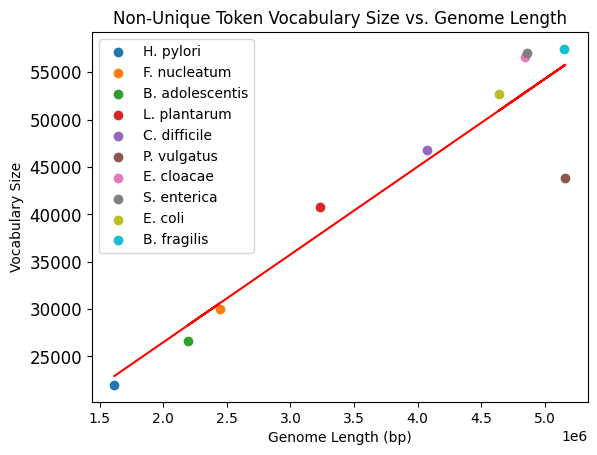

In [148]:
fig, ax = plt.subplots()
for i in range(len(ls_names)):
    ax.scatter(ls_genome_lens[i],ls_vocab_lens_thresholded[i] )
ax.legend(ls_names)    
ax.set_ylabel("Vocabulary Size")
ax.set_xlabel('Genome Length (bp)')
ax.set_title("Non-Unique Token Vocabulary Size vs. Genome Length")

#best fit line
x = np.array(ls_genome_lens).reshape(len(ls_genome_lens), 1)
X = np.append(x, np.ones((len(ls_genome_lens), 1)), axis=1)
y = np.array(ls_vocab_lens_thresholded).reshape(len(ls_vocab_lens_thresholded), 1)
theta = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
y_line = X.dot(theta)
ax.plot(x, y_line, 'r')

# for i, txt in enumerate(ls_names):
#     plt.annotate(txt, (ls_vocab_lens[i], ls_genome_lens[i]))
plt.show()


### Plotting reduction in vocab size by removal of unique tokens

Text(0.5, 1.0, 'Proportion of Tokens with \n Greater Than 1 Occurrence in Vocabulary')

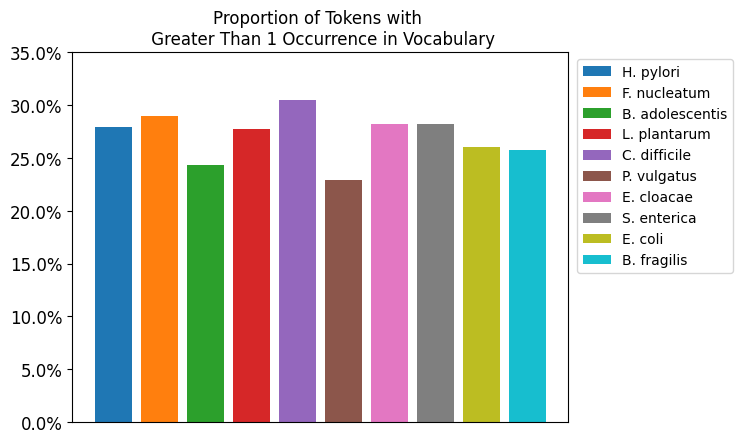

In [150]:
import matplotlib.ticker as mtick


fig, ax = plt.subplots()
for i in range(len(ls_names)):
    ax.bar(i,ls_vocab_lens_thresholded[i]/ls_vocab_lens[i])
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))

plt.legend(ls_names,bbox_to_anchor=(1.175,1),
          ncol=1, fancybox=True,  loc='upper center')
# plt.ylim(0, .5)
# ax.relim()
plt.yticks(np.linspace(0, .35, 8))
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) #
plt.rcParams['ytick.labelsize'] = 'large'
plt.title("Proportion of Tokens with \n Greater Than 1 Occurrence in Vocabulary")

### Plotting Length Frequencies of Unique Tokens

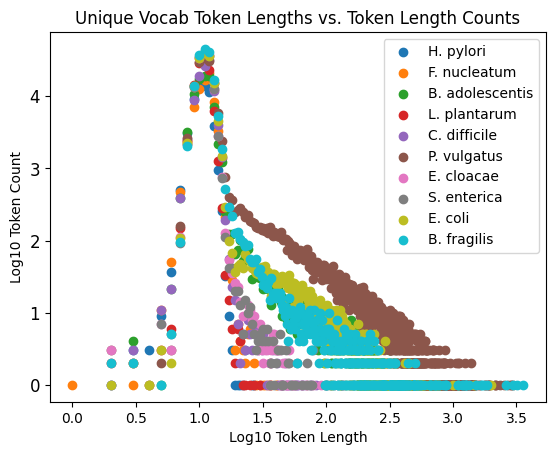

In [151]:
fig, ax = plt.subplots()
for i, pair in enumerate(ls_unique_len_freqs):
    #keys = lengths = x
    #values = counts = y
    ax.scatter(np.log10(list(pair.keys())), np.log10(list(pair.values())))
ax.legend(ls_names)
ax.set_xlabel('Log10 Token Length')
ax.set_ylabel('Log10 Token Count')
ax.set_title("Unique Vocab Token Lengths vs. Token Length Counts")
plt.show()


### Plotting individual length vs. frequency distributions

/tmp/ipykernel_2766434/2896744104.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10')


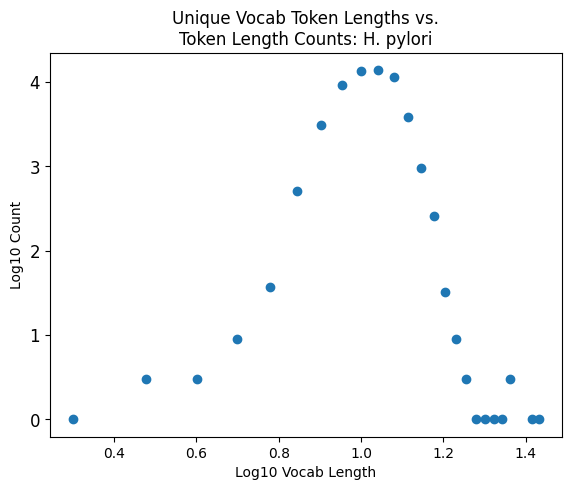

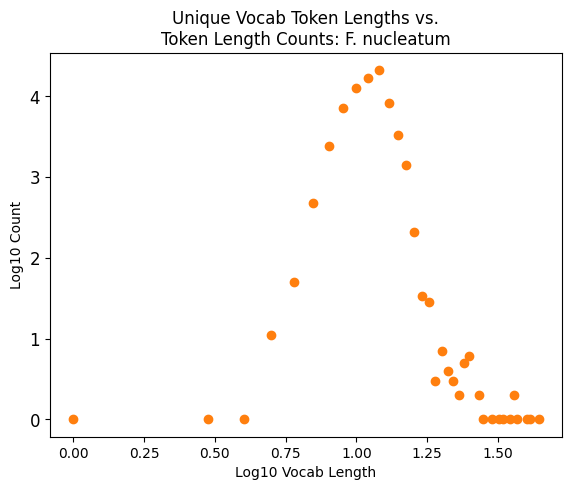

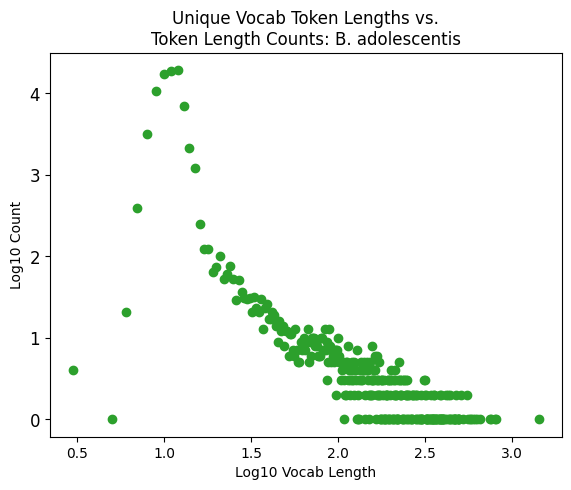

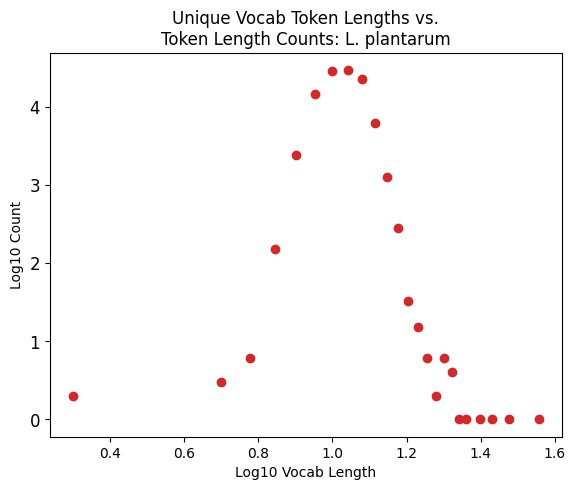

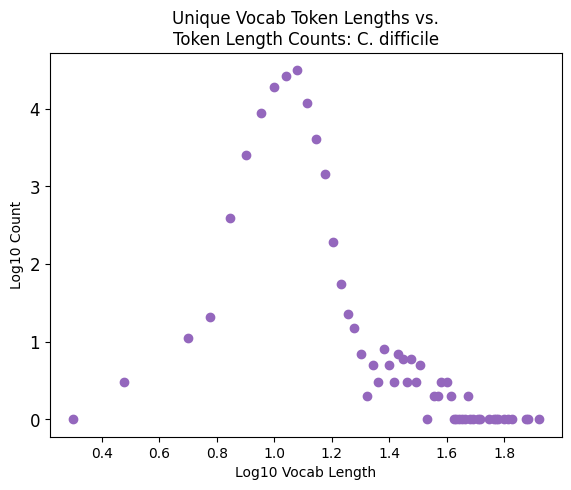

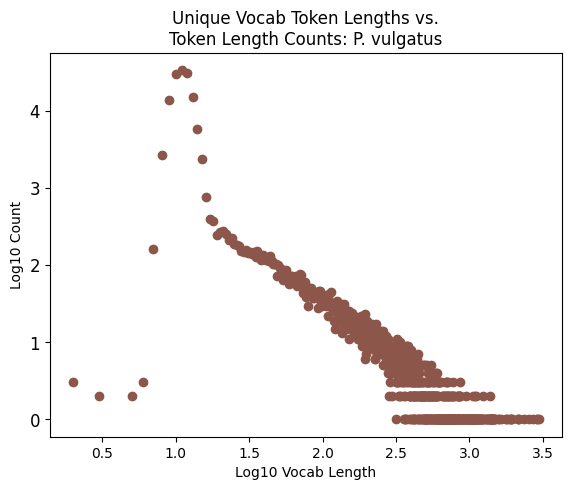

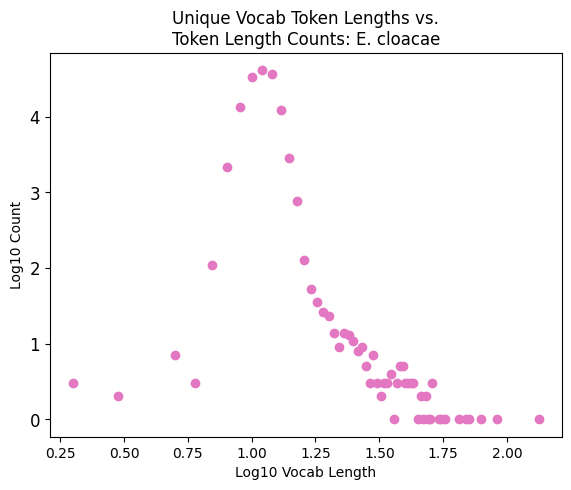

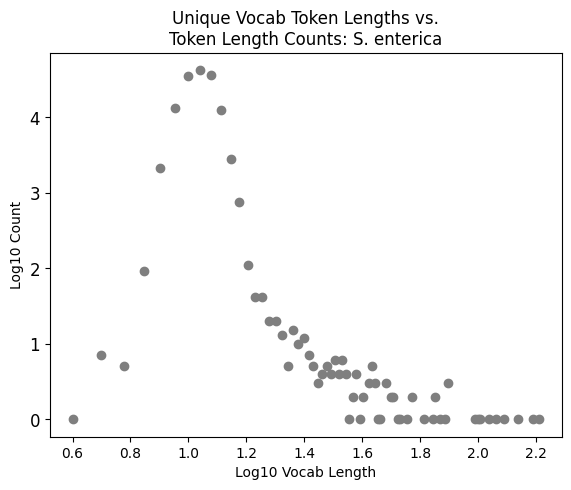

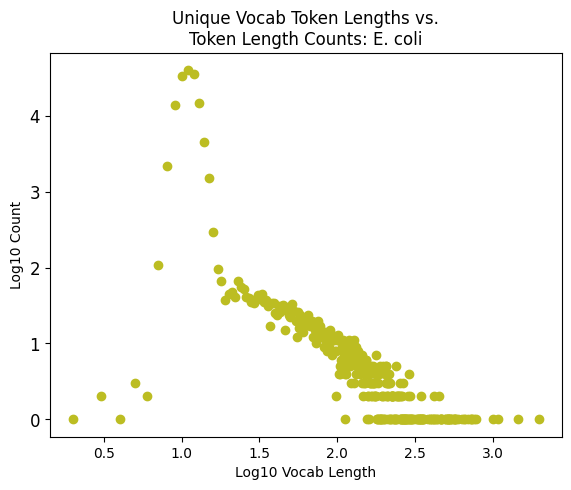

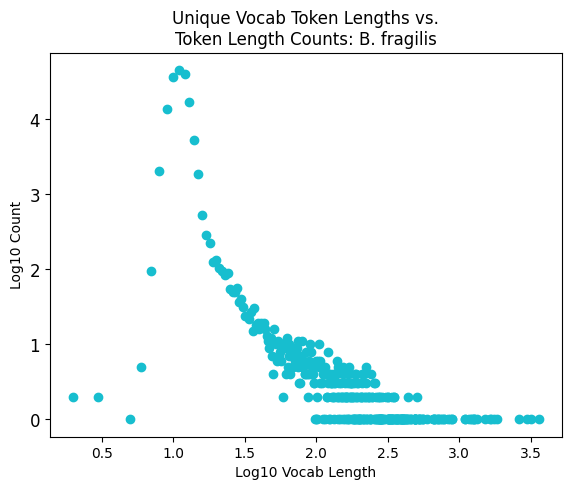

In [152]:
from matplotlib import cm
cmap = cm.get_cmap('tab10')

#fig, ax = plt.subplots(2, 5)
for i, pair in enumerate(ls_unique_len_freqs):
    #keys = lengths = x
    #values = counts = y
    if(i<5):
        idx_x = 0
        idx_y = i
    else:
        idx_x=1
        idx_y= i-0
    f = plt.figure()
    ax = f.add_axes([0.1,0.1,0.8,0.8])
    ax.scatter(np.log10(list(pair.keys())), np.log10(list(pair.values())), color=cmap(i))
    ax.set_xlabel('Log10 Vocab Length')
    ax.set_ylabel('Log10 Count')
    ax.set_title("Unique Vocab Token Lengths vs.\nToken Length Counts: " + ls_names[i])

#     ax[idx_x][idx_y].scatter((pair.keys()), np.log10(list(pair.values())))
#     ax[idx_x][idx_y].set_xlabel('Vocab Length')
#     ax[idx_x][idx_y].set_ylabel('Log10 Count')
#     ax[idx_x][idx_y].set_title("Vocab Token Lengths vs. Token Length Counts:\n" + ls_names[i])

#     print(pair)
plt.show()


## Effects of Tokmenization Threshold on Various Statistics

### Retrieve tokenizations with different thresholds

In [267]:
# %time
# import time
# start_time = time.time()
# thresholds = np.arange(0, 22, 2)
# ignore_dict = get_ignore_dict(thresholds)
# print('elapsed: {} seconds'.format(time.time()-start_time))
# print(ignore_dict[10][:10])

['<PAD>', '<UNK>', '<BOS>', '<EOS>', '▁', 'A', 'T', 'C', 'G', 'AT']


In [302]:
%%time
genome_lens = []
genomes = []
# thresholds = [0, 10, 50, 100, 1000]

thresholds = np.arange(0, 32)

token_threshold_dict = {}
for file in files:
    path = os.path.join(directory, file)
    genome = retrieve_genomes(path, gzipped=False)
    genome = genome[list(genome.keys())[0]]
    genomes.append(genome)
    genome_lens.append(len(genome))
    freqs = {}
#     threshold = 0

for threshold in thresholds:
    token_threshold_dict[threshold]={}

    tokenizations = []
    for genome in genomes:
        tokenizations.append(tokenize(genome, length_threshold=threshold))
    sorted_freqs = []
    for tokens in tokenizations:
        freqs = {}
        for token in tokens:
            if token not in freqs.keys():
                freqs[token] = 1
            else:
                freqs[token]+=1
        sorted_freqs.append(sorted(freqs.items(), key=operator.itemgetter(1), reverse=True))
    token_threshold_dict[threshold]['sorted_freqs'] = sorted_freqs
    token_threshold_dict[threshold]['tokenizations'] = tokenizations
#retrieve token frequencies for each tokenization for each threshold


CPU times: user 19min 37s, sys: 11 s, total: 19min 48s
Wall time: 19min 54s


## Extracting sorted frequencies and lengths and ordering the samples by vocabulary size (frequency threshold 0, length threshold varied)

In [303]:
%%time
freq_threshold=0
for threshold in thresholds:
    sorted_freq_values = []
    sorted_freq_lengths = []

    for i, freqs in enumerate(token_threshold_dict[threshold]['sorted_freqs']):
        sorted_freq_values.append([])
        sorted_freq_lengths.append([])
        for freq in freqs:
            sorted_freq_values[i].append(freq[1])
            if(freq[1]>freq_threshold):
                if(freq[0][0]=="_"):
                    sorted_freq_lengths[i].append(len(freq[0][1:]))
                else:
                    sorted_freq_lengths[i].append(len(freq[0]))
        token_threshold_dict[threshold]['sorted_freqs_lengths'] = sorted_freq_lengths
        token_threshold_dict[threshold]['sorted_freqs_values'] = sorted_freq_values
    
            
# for i, vals in enumerate(sorted_freq_values):
    
#     print(names[i], len(vals), vals[0])
# #log10 rank vs. frequency
print("-"*20)
#sort groups by length of vocabulary
print(token_threshold_dict[0].keys())
for threshold in thresholds:
    sorted_freq_vals_names_lens=sorted(zip( [len(val) for val in token_threshold_dict[threshold]['sorted_freqs_values']], 
                                        names,
                                        families,
                                        token_threshold_dict[threshold]['sorted_freqs_values'],
                                        token_threshold_dict[threshold]['sorted_freqs_lengths'], 
                                        token_threshold_dict[threshold]['tokenizations'],

                                        genome_lens))
    token_threshold_dict[threshold]['ls_vocab_lens'], token_threshold_dict[threshold]['ls_names'],\
    token_threshold_dict[threshold]['ls_families'], token_threshold_dict[threshold]['ls_freq_vals'], \
    token_threshold_dict[threshold]['ls_token_lens'],token_threshold_dict[threshold]['ls_tokenizations'],\
    token_threshold_dict[threshold]['ls_genome_lens'] = zip(*sorted_freq_vals_names_lens)
    sorted_genomes_names_dicts =sorted(zip( genome_lens, 
                                        names,
                                       families,
                                       token_threshold_dict[threshold]['tokenizations']))
#gls = genome length-sorted
#     token_threshold_dict[threshold]['test']=zip(*sorted_genomes_names_dicts)
    (token_threshold_dict[threshold]['gls_genomes'],
    token_threshold_dict[threshold]['gls_names'],
    token_threshold_dict[threshold]['gls_families'],
    token_threshold_dict[threshold]['gls_tokenizations']) = zip(*sorted_genomes_names_dicts)
#ls = len-sorted
# for item in sorted_freq_vals_names_lens:
#     print( item[2],item[1],item[0], item[3][0], str(item[5]) + "bp")
# ls_vocab_lens, ls_names, ls_families, ls_freq_vals, ls_token_lens, ls_genome_lens = zip(*sorted_freq_vals_names_lens)



--------------------
dict_keys(['sorted_freqs', 'tokenizations', 'sorted_freqs_lengths', 'sorted_freqs_values'])
CPU times: user 11.4 s, sys: 956 ms, total: 12.4 s
Wall time: 12.5 s


In [304]:
#sanity check - checking if tokenizations are in proper order
for i, name in enumerate(token_threshold_dict[0]['ls_names']):
    print(name, (token_threshold_dict[0]['ls_vocab_lens'][i]))
print(20*'-')
for i, name in enumerate(token_threshold_dict[0]['gls_names']):
    print(name, token_threshold_dict[0]['gls_genomes'][i])

H. pylori 78774
F. nucleatum 103504
B. adolescentis 109204
L. plantarum 146916
C. difficile 153547
P. vulgatus 191263
E. cloacae 200527
S. enterica 202281
E. coli 202456
B. fragilis 222863
--------------------
H. pylori 1615199
B. adolescentis 2192428
F. nucleatum 2443126
L. plantarum 3231249
C. difficile 4077288
E. coli 4641652
E. cloacae 4848754
S. enterica 4857450
B. fragilis 5150703
P. vulgatus 5163189


### Retrieving vocab lens by threshold

In [305]:

print(token_threshold_dict[0]['ls_vocab_lens'])
vocab_lens_array = []
for threshold in thresholds:
    vocab_lens_array.append(token_threshold_dict[threshold]['ls_vocab_lens'])
#     for i, tokenization in enumerate(token_threshold_dict[threshold]['tokenizations']):
#         print(token_threshold_dict[threshold]['ls_names'][i], len(tokenization))
#     print('-'*20)
vocab_lens_array = np.array(vocab_lens_array)



(78774, 103504, 109204, 146916, 153547, 191263, 200527, 202281, 202456, 222863)


### Plotting thresholds vs. Vocab lens

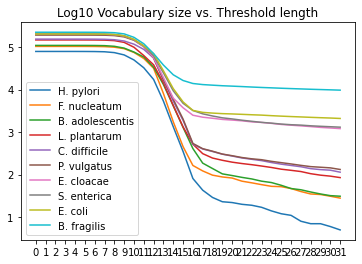

In [306]:
cmap = cm.get_cmap('tab10')
for i, name in enumerate(token_threshold_dict[0]['ls_names']):
    plt.plot(np.log10(vocab_lens_array[:, i]), color=cmap(i))
plt.title('Log10 Vocabulary size vs. Threshold length')
plt.xticks(ticks = np.arange(len(thresholds)), labels=[str(threshold) for threshold in thresholds])
plt.legend(token_threshold_dict[0]['ls_names'])

### Plotting thresholds vs. Tokenization Lengths

In [307]:
tokenization_lens = []
for threshold in thresholds:
    tokenization_lens.append([len(tokenization) for tokenization in token_threshold_dict[threshold]['gls_tokenizations']])
#     for i, tokenization in enumerate(token_threshold_dict[threshold]['tokenizations']):
#         print(token_threshold_dict[threshold]['ls_names'][i], len(tokenization))
#     print('-'*20)
tokenization_lens = np.array(tokenization_lens)
print(tokenization_lens)


[[191155 231497 274440 386762 465084 509337 567294 569588 570597 409040]
 [191155 231497 274440 386762 465084 509337 567294 569588 570597 409040]
 [191155 231497 274439 386762 465084 509337 567294 569588 570597 409040]
 [191147 231497 274439 386760 465083 509332 567286 569584 570595 409037]
 [190815 231309 274159 386151 464551 508912 566715 568925 570114 408791]
 [187237 228775 271297 379181 459087 502818 558664 560930 563060 404712]
 [176815 218528 260851 356041 438663 479363 528886 530459 536904 388966]
 [153883 192919 229876 306298 383731 422699 461167 462190 475055 349623]
 [123412 159156 192609 241346 316555 341850 367444 366149 383399 290694]
 [ 90187 124065 151522 176503 243831 259599 273100 271894 288794 227213]
 [ 58083  82724 100244 111525 159078 176812 180163 179296 196712 162451]
 [ 35200  56784  69106  66740 106990 115100 112471 111437 127775 113514]
 [ 18142  34930  43485  32893  64119  65608  59413  58356  72394  73040]
 [  5577  13412  15622   8409  21392  26033  17973 

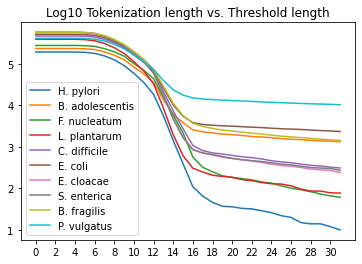

In [314]:
cmap = cm.get_cmap('tab10')
for i, name in enumerate(token_threshold_dict[0]['gls_names']):
    plt.plot(np.log10(tokenization_lens[:, i]), color=cmap(i))
plt.title('Log10 Tokenization length vs. Threshold length')
plt.xticks(ticks = np.arange(0, len(thresholds), 2), labels=np.arange(0, len(thresholds), 2))
plt.legend(token_threshold_dict[0]['gls_names'])

## TF-IDF on Model Genomes With Different Tokenization Thresholds

In [309]:
%%time
from sklearn.feature_extraction.text import TfidfVectorizer
# print(token_threshold_dict.keys())

# genomes = []
# for file in files:
#     path = os.path.join(directory, file)
#     genome = retrieve_genomes(path, gzipped=False)
    
#     genome = genome[list(genome.keys())[0]]
#     genomes.append(genome)
def dummy_tokenizer(doc):
    return doc
threshold = 16
vectorizer = TfidfVectorizer(lowercase=False, tokenizer=dummy_tokenizer)
X = vectorizer.fit_transform(token_threshold_dict[threshold]['tokenizations'])


CPU times: user 75.3 ms, sys: 13.9 ms, total: 89.2 ms
Wall time: 192 ms


### SVD on Model Genomes

In [310]:
%%time
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=2, n_iter=10, random_state=42)
df = svd.fit_transform(X)



CPU times: user 178 ms, sys: 204 ms, total: 382 ms
Wall time: 165 ms


### Elbow method

/gpfs/home/jic286/.conda/envs/hyena-dna-new/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/gpfs/home/jic286/.conda/envs/hyena-dna-new/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/gpfs/home/jic286/.conda/envs/hyena-dna-new/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/gpfs/home/jic286/.conda/envs/hyena-dna-new/lib/python3.8/site-packages/sklearn/cluster/

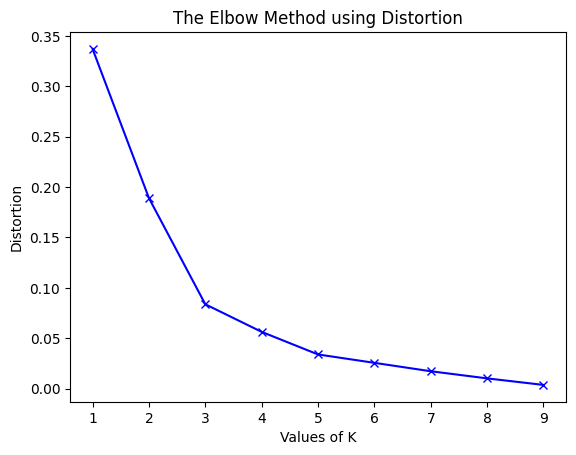

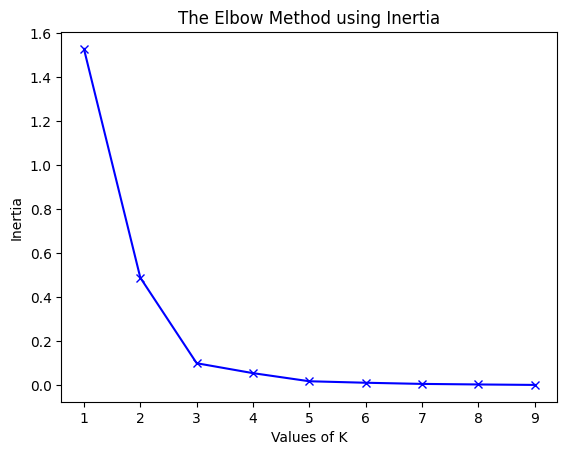

In [33]:
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.pyplot as plt
distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 10)
X = df
for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k).fit(X)
    kmeanModel.fit(X)
 
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_,
                                        'euclidean'), axis=1)) / X.shape[0])
    inertias.append(kmeanModel.inertia_)
 
    mapping1[k] = sum(np.min(cdist(X, kmeanModel.cluster_centers_,
                                   'euclidean'), axis=1)) / X.shape[0]
    mapping2[k] = kmeanModel.inertia_
plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()
plt.plot(K, inertias, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.show()


### Dendrogram on Truncated SVD of model genome TF-IDF

(10, 2)


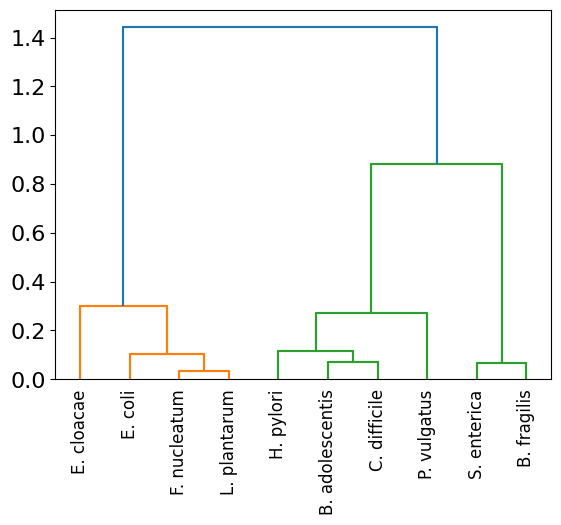

In [133]:
from scipy.cluster.hierarchy import dendrogram, linkage

plt.rcParams.update({'font.size': 16})
data = df
print(data.shape)
# data = np.concatenate((data[5:,], data[:5,]), axis=0)
# print(data.shape)
# print(data[0,:10])
linkage_data = linkage(data,method='ward', metric='euclidean', optimal_ordering=True)
d = dendrogram(linkage_data)
labels =([names[l] for l in d['leaves']])
dendrogram(linkage_data, labels=labels)
plt.xticks(rotation='vertical')

plt.show()



(10,)
[1 3 2 0 0 2 4 5 1 0]


/gpfs/home/jic286/.conda/envs/hyena-dna-new/lib/python3.8/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


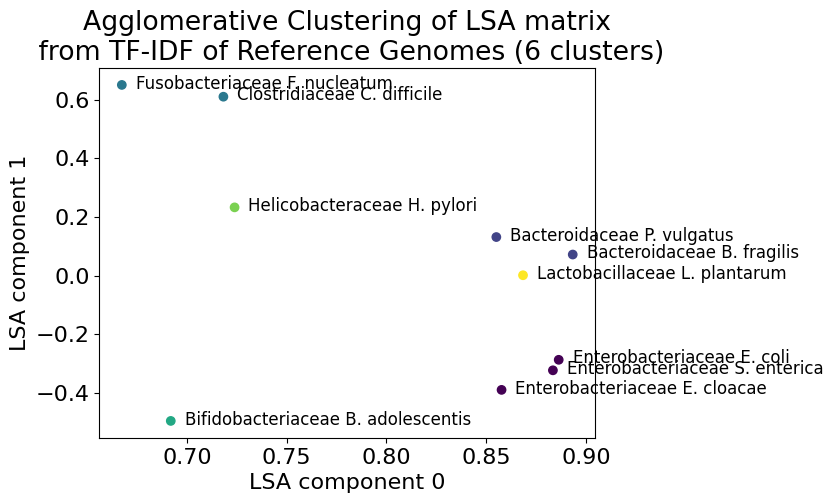

In [142]:
from sklearn.cluster import AgglomerativeClustering

print(df[:,0].shape)
plt.rcParams.update({'font.size': 16})
n_clust = 6
hierarchical_cluster = AgglomerativeClustering(n_clusters=n_clust, affinity='euclidean', linkage='ward')
labels = hierarchical_cluster.fit_predict(data) 
print(labels)
# for x, y in (df):
#     plt.scatter(x, y)
# plt.legend(names)

plt.scatter(df[:,0], df[:,1], c=labels)
for i, point in enumerate(df):
    plt.annotate(families[i] + " " + names[i], (point), textcoords='offset points', xytext=(10,-2.5), fontsize="12")
# plt.title("Agglomerative Clustering on LSA of TF-IDF Matrix")
plt.title(f"Agglomerative Clustering of LSA matrix\n from TF-IDF of Reference Genomes ({n_clust} clusters)")
plt.xlabel("LSA component 0")
plt.ylabel("LSA component 1")
plt.show()



# Repeating Vocab Size Experiments with Different BPE Models

In [40]:
model_path = 'metagenomes_8192k_0.1s-000.model'

In [65]:
model_path = 'metagenomes_8192k_0.1s-001.model'

In [63]:
model_path = 'metagenomes_8192k_0.1s-002.model'

In [64]:
model_path = 'metagenomes_8192k_0.1s-003.model'

In [102]:
model_path = 'metagenomes_8192k_0.1s-004.model'

In [103]:
model_path = 'metagenomes_8192k_0.1s-005.model'

In [104]:
model_path = 'metagenomes_8192k_0.1s-006.model'

In [105]:
model_path = 'metagenomes_8192k_0.1s-007.model'

In [106]:
model_path = 'metagenomes_8192k_0.1s-008.model'

In [107]:
model_path = 'metagenomes_8192k_0.1s-009.model'

In [78]:
set_number = model_path[model_path.find("-")+1:model_path.rfind(".")]
while True:
    if set_number !="000":
        if set_number[0]=="0":
            set_number = set_number[1:]
        else:
            break
    else:
        set_number = '0'
        break
print(set_number)

1


In [42]:
# idx = model_path.rfind('.')
# num = str(int(model_path[idx-3:idx]))
# print(num)

In [66]:
%%time
bpe = yttm.BPE(model=model_path)

CPU times: user 20.6 s, sys: 1.77 s, total: 22.4 s
Wall time: 22.6 s


In [67]:
%%time
#retrieve tokenizations for each genome
# tokenizations = []
# genome_lens = []
# for file in files:
#     path = os.path.join(directory, file)
#     genome = retrieve_genomes(path, gzipped=False)
    
#     genome = genome[list(genome.keys())[0]]
#     genome_lens.append(len(genome))
#     freqs = {}
#     threshold = 0
#     tokenizations.append(tokenize(genome, length_threshold=threshold))
tokenizations, genome_lens = retrieve_tokenizations(files)
#retrieve token frequencies for each tokenization
sorted_freqs = []

for tokens in tokenizations:
    freqs = {}
    for token in tokens:
        if token not in freqs.keys():
            freqs[token] = 1
        else:
            freqs[token]+=1
    sorted_freqs.append(sorted(freqs.items(), key=operator.itemgetter(1), reverse=True))


CPU times: user 27.7 s, sys: 568 ms, total: 28.2 s
Wall time: 28.8 s


## Extracting sorted frequencies and lengths and ordering the samples by vocabulary size (frequency threshold 0) (set 0)

In [68]:
%%time
freq_threshold=0
sorted_freq_values = []
sorted_freq_lengths = []

for i, freqs in enumerate(sorted_freqs):
    sorted_freq_values.append([])
    sorted_freq_lengths.append([])
    for freq in freqs:
        sorted_freq_values[i].append(freq[1])
        if(freq[1]>freq_threshold):
            if(freq[0][0]=="_"):
                sorted_freq_lengths[i].append(len(freq[0][1:]))
            else:
                sorted_freq_lengths[i].append(len(freq[0]))
for i, vals in enumerate(sorted_freq_values):
    
    print(names[i], len(vals), vals[0])
#log10 rank vs. frequency
print("-"*20)
sorted_freq_vals_names_lens =sorted(zip( [len(val) for val in sorted_freq_values], 
                                        names,
                                        sorted_freq_values, 
                                        sorted_freq_lengths, 
                                        genome_lens))
#ls = len-sorted
for item in sorted_freq_vals_names_lens:
    print(item[1], item[0], item[2][0], str(item[4]) + "bp")
ls_vocab_lens, ls_names, ls_freq_vals, ls_token_lens, ls_genome_lens = zip(*sorted_freq_vals_names_lens)



B. fragilis 224316 199
B. adolescentis 110137 147
C. difficile 153657 391
E. cloacae 200284 403
E. coli 202119 299
F. nucleatum 103409 248
H. pylori 78802 243
L. plantarum 147087 454
P. vulgatus 187103 107
S. enterica 201827 424
--------------------
H. pylori 78802 243 1615199bp
F. nucleatum 103409 248 2443126bp
B. adolescentis 110137 147 2192428bp
L. plantarum 147087 454 3231249bp
C. difficile 153657 391 4077288bp
P. vulgatus 187103 107 5163189bp
E. cloacae 200284 403 4848754bp
S. enterica 201827 424 4857450bp
E. coli 202119 299 4641652bp
B. fragilis 224316 199 5150703bp
CPU times: user 600 ms, sys: 2.92 ms, total: 603 ms
Wall time: 604 ms


### Plotting token frequencies vs. log10 rank for each genome (Set 0)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 3.81 µs


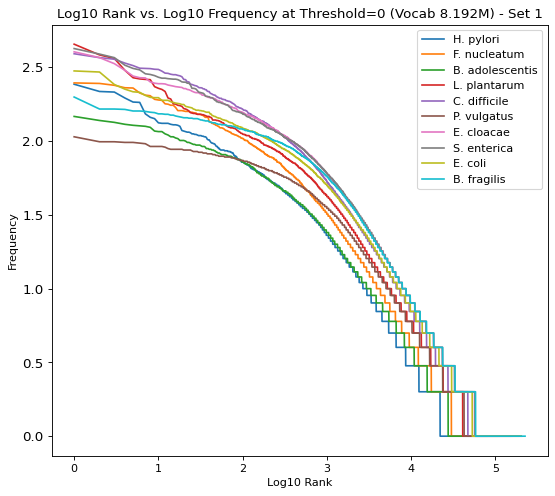

In [79]:
%time
from matplotlib.pyplot import figure

figure(figsize=(8, 7), dpi=80)

for i, freqs in enumerate(ls_freq_vals):
    plt.plot(np.log10(np.arange(1, len(freqs)+1)), np.log10(freqs))
    plt.xlabel('Log10 Rank')
    plt.ylabel('Frequency')
plt.title('Log10 Rank vs. Log10 Frequency at Threshold=0 (Vocab 8.192M) - Set {}'.format(set_number))

plt.legend(ls_names)
plt.show()

### Plotting Rank vs. Length (Set 0)

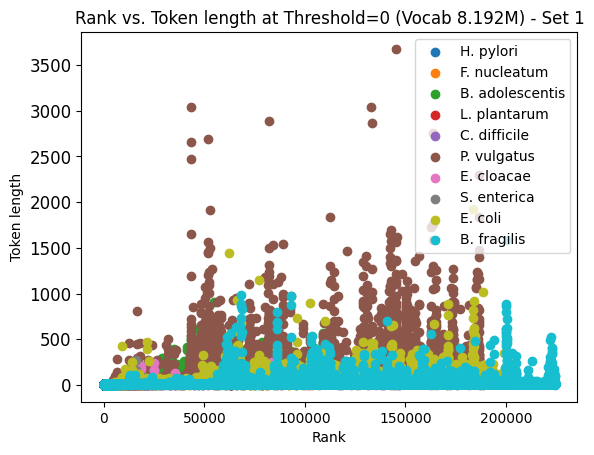

In [80]:
# figure(figsize=(8, 7), dpi=80)
for i, freqs in enumerate(ls_token_lens):
    plt.scatter((np.arange(len(freqs))), (freqs))
    plt.xlabel('Rank')
    plt.ylabel('Token length')
plt.title('Rank vs. Token length at Threshold=0 (Vocab 8.192M) - Set {}'.format(set_number))

plt.legend(ls_names)
plt.show()

In [81]:
##Exploring long tokens from sample 1

### Plotting Vocab Size vs. Genome Length (Set 0)

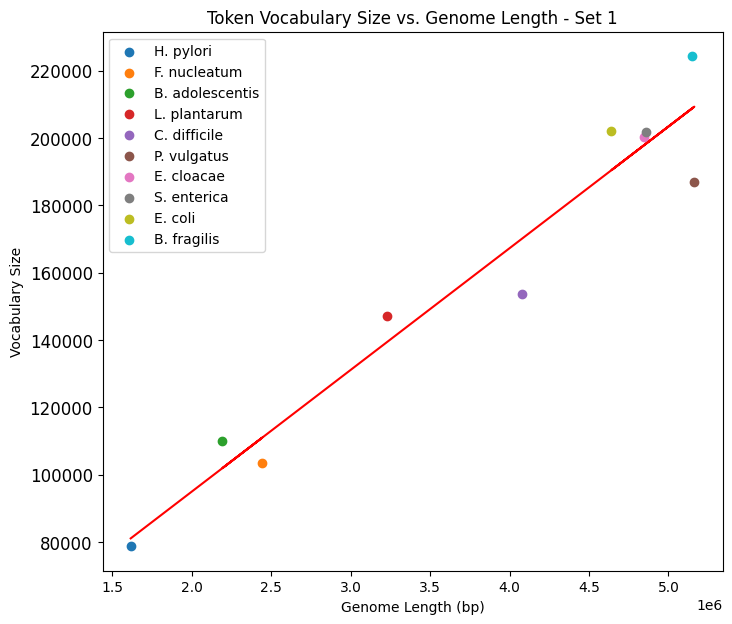

In [82]:

fig, ax = plt.subplots(figsize = (8, 7))
for i in range(len(ls_names)):
    ax.scatter(ls_genome_lens[i],ls_vocab_lens[i] )
ax.legend(ls_names)    
ax.set_ylabel("Vocabulary Size")
ax.set_xlabel('Genome Length (bp)')
ax.set_title("Token Vocabulary Size vs. Genome Length - Set {}".format(set_number))

#best fit line
x = np.array(ls_genome_lens).reshape(len(ls_genome_lens), 1)
X = np.append(x, np.ones((len(ls_genome_lens), 1)), axis=1)
y = np.array(ls_vocab_lens).reshape(len(ls_vocab_lens), 1)
theta = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
y_line = X.dot(theta)
ax.plot(x, y_line, 'r')

# for i, txt in enumerate(ls_names):
#     plt.annotate(txt, (ls_vocab_lens[i], ls_genome_lens[i]))
plt.show()


## Vocabulary size

Text(0.5, 1.0, 'Vocabulary Sizes at Threshold=0 (Vocab 8.192M) - Set 1')

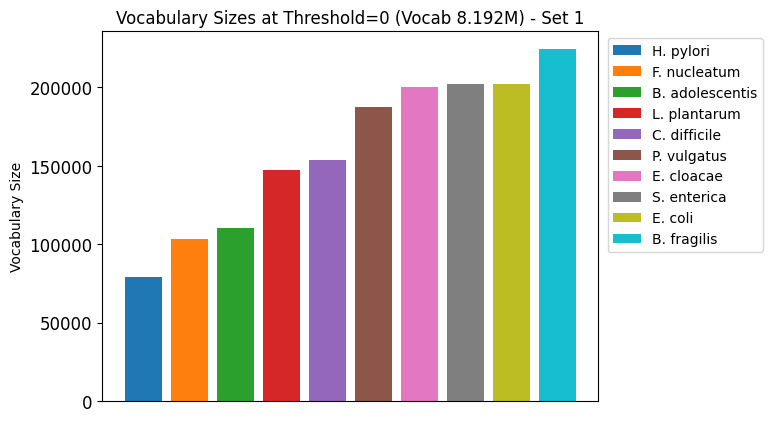

In [83]:
fig, ax = plt.subplots()
for i in range(len(ls_names)):
    ax.bar(i,ls_vocab_lens[i])
# ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) #
plt.ylabel("Vocabulary Size")
plt.legend(ls_names,bbox_to_anchor=(1.175,1),
          ncol=1, fancybox=True,  loc='upper center')
plt.title("Vocabulary Sizes at Threshold=0 (Vocab 8.192M) - Set {}".format(set_number))


## Mean token lengths

Text(0.5, 1.0, 'Mean Token Lengths (Vocab size 8.192M) - Set 1')

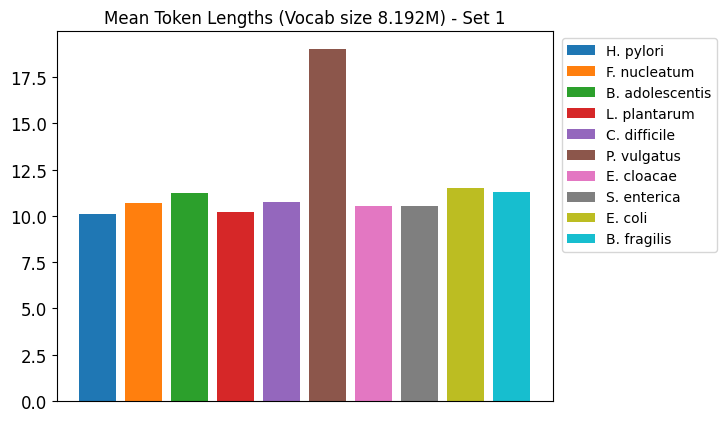

In [85]:
from matplotlib.pyplot import figure
# figure(figsize_8, 8), dpi=80)

for i in range(len(ls_names)):
    plt.bar(i,np.mean(ls_token_lens[i]))#/(ls_vocab_lens[i]))
    
plt.legend(ls_names,bbox_to_anchor=(1.175,1),
          ncol=1, fancybox=True,  loc='upper center')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) #
plt.title("Mean Token Lengths (Vocab size 8.192M) - Set {}".format(set_number))


## Investigating vocabulary sizes while removing single appearance tokens - Set 0

In [76]:
%%time
freq_length_threshold=0
freq_threshold=1
sorted_freq_values = []
sorted_freq_lengths = []
sorted_freq_values_thresholded =[]

for i, freqs in enumerate(sorted_freqs):
    sorted_freq_values.append([])
    sorted_freq_lengths.append([])
    sorted_freq_values_thresholded.append([])
    for freq in freqs:
        if(freq[1]>freq_threshold):
            sorted_freq_values_thresholded[i].append(freq[1])
        sorted_freq_values[i].append(freq[1])
        if(freq[1]>freq_length_threshold):
            if(freq[0][0]=="_"):
                sorted_freq_lengths[i].append(len(freq[0][1:]))
            else:
                sorted_freq_lengths[i].append(len(freq[0]))
# for i, vals in enumerate(sorted_freq_values):
    
#     print(names[i], len(vals), vals[0])
#log10 rank vs. frequency
print("-"*20)
sorted_freq_vals_names_lens =sorted(zip( [len(val) for val in sorted_freq_values], 
                                        names,
                                        sorted_freq_values, 
                                        [len(item) for item in sorted_freq_values_thresholded],
                                        sorted_freq_lengths, 
                                        genome_lens))
#ls = length-sorted
for i, item in enumerate(sorted_freq_vals_names_lens):
    print(item[1], "total vocabulary:", str(item[0])+",","non-unique vocabulary:", item[3])
ls_vocab_lens, ls_names, ls_freq_vals, ls_vocab_lens_thresholded, ls_token_lens, ls_genome_lens = zip(*sorted_freq_vals_names_lens)




--------------------
H. pylori total vocabulary: 78802, non-unique vocabulary: 21975
F. nucleatum total vocabulary: 103409, non-unique vocabulary: 29903
B. adolescentis total vocabulary: 110137, non-unique vocabulary: 27372
L. plantarum total vocabulary: 147087, non-unique vocabulary: 40760
C. difficile total vocabulary: 153657, non-unique vocabulary: 46904
P. vulgatus total vocabulary: 187103, non-unique vocabulary: 42314
E. cloacae total vocabulary: 200284, non-unique vocabulary: 56420
S. enterica total vocabulary: 201827, non-unique vocabulary: 57046
E. coli total vocabulary: 202119, non-unique vocabulary: 52900
B. fragilis total vocabulary: 224316, non-unique vocabulary: 57947
CPU times: user 728 ms, sys: 60.8 ms, total: 789 ms
Wall time: 791 ms


### Plotting reduced vocabulary sizes vs. genomes  - Set 0

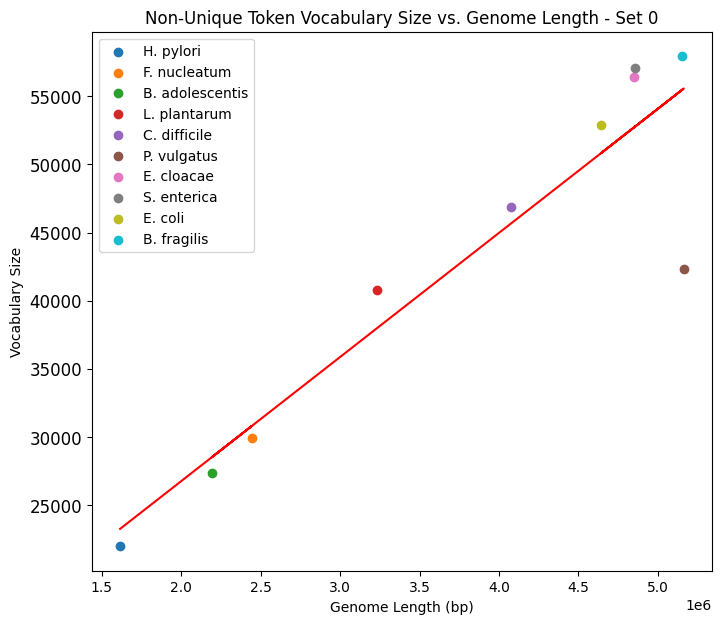

In [77]:
fig, ax = plt.subplots(figsize=(8, 7))
for i in range(len(ls_names)):
    ax.scatter(ls_genome_lens[i],ls_vocab_lens_thresholded[i] )
ax.legend(ls_names)    
ax.set_ylabel("Vocabulary Size")
ax.set_xlabel('Genome Length (bp)')
ax.set_title("Non-Unique Token Vocabulary Size vs. Genome Length - Set {}".format(set_number))

#best fit line
x = np.array(ls_genome_lens).reshape(len(ls_genome_lens), 1)
X = np.append(x, np.ones((len(ls_genome_lens), 1)), axis=1)
y = np.array(ls_vocab_lens_thresholded).reshape(len(ls_vocab_lens_thresholded), 1)
theta = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
y_line = X.dot(theta)
ax.plot(x, y_line, 'r')

# for i, txt in enumerate(ls_names):
#     plt.annotate(txt, (ls_vocab_lens[i], ls_genome_lens[i]))
plt.show()


### Plotting reduction in vocab size by removal of unique tokens

Text(0.5, 1.0, 'Proportion of Tokens with \n Greater Than 1 Occurrence in Vocabulary - Set 0')

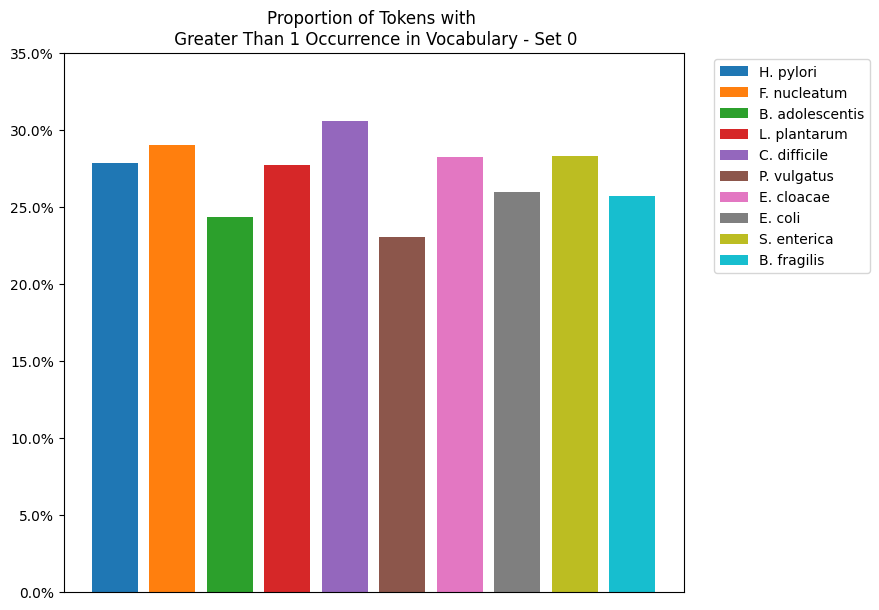

In [53]:
import matplotlib.ticker as mtick
fig, ax = plt.subplots(figsize=(8, 7))
for i in range(len(ls_names)):
    ax.bar(i,ls_vocab_lens_thresholded[i]/ls_vocab_lens[i])
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))

plt.legend(ls_names,bbox_to_anchor=(1.175,1),
          ncol=1, fancybox=True,  loc='upper center')
# plt.ylim(0, .5)
# ax.relim()
plt.yticks(np.linspace(0, .35, 8))
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) #
plt.rcParams['ytick.labelsize'] = 'large'
plt.title("Proportion of Tokens with \n Greater Than 1 Occurrence in Vocabulary - Set {}".format(set_number))

### Plotting genome length vs. ratios of unique to non-unique 

In [54]:
token_dicts = []
for i, tokenization in enumerate(tokenizations):
    token_dicts.append({})
    for token in tokenization:
        if token in token_dicts[i].keys():
            token_dicts[i][token]+=1
        else:
            token_dicts[i][token] = 1


In [55]:
sorted_genomes_names_dicts =sorted(zip( genome_lens, 
                                        names,
                                       families,
                                        token_dicts,
                                       tokenizations))
#gls = genome length-sorted
gls_genomes, gls_names, gls_families, gls_token_dicts, gls_tokenizations = zip(*sorted_genomes_names_dicts)


In [56]:
tkns_unique = []
tkns_non_unique = []
unique_lens = []
non_unique_lens = []
tokenization_lens = []
for i, tokenization in enumerate(gls_tokenizations):
    tkns_unique.append([])
    tkns_non_unique.append([])
    for token in tokenization:
        if(gls_token_dicts[i][token]>1):
            tkns_non_unique[i].append(token)
        elif(gls_token_dicts[i][token]==1):
            tkns_unique[i].append(token)
    print("{}: {} unique tokens".format(gls_names[i], len(tkns_unique[i])))
    unique_lens.append(len(tkns_unique[i]))
    print("{}: {} non-unique tokens".format(gls_names[i], len(tkns_non_unique[i])))
    non_unique_lens.append(len(tkns_non_unique[i]))
    tokenization_lens.append(len(tokenization))


H. pylori: 56980 unique tokens
H. pylori: 134090 non-unique tokens
B. adolescentis: 83437 unique tokens
B. adolescentis: 150698 non-unique tokens
F. nucleatum: 73367 unique tokens
F. nucleatum: 201259 non-unique tokens
L. plantarum: 106254 unique tokens
L. plantarum: 280526 non-unique tokens
C. difficile: 106528 unique tokens
C. difficile: 358203 non-unique tokens
E. coli: 149308 unique tokens
E. coli: 351370 non-unique tokens
E. cloacae: 144001 unique tokens
E. cloacae: 423507 non-unique tokens
S. enterica: 145097 unique tokens
S. enterica: 424461 non-unique tokens
B. fragilis: 166179 unique tokens
B. fragilis: 401654 non-unique tokens
P. vulgatus: 150923 unique tokens
P. vulgatus: 270971 non-unique tokens


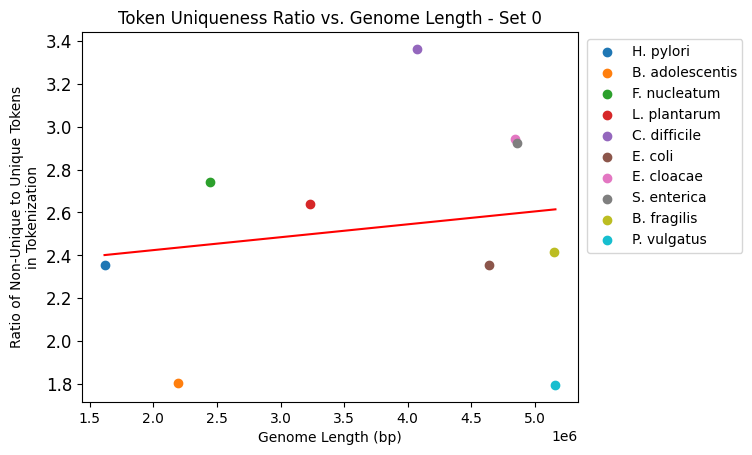

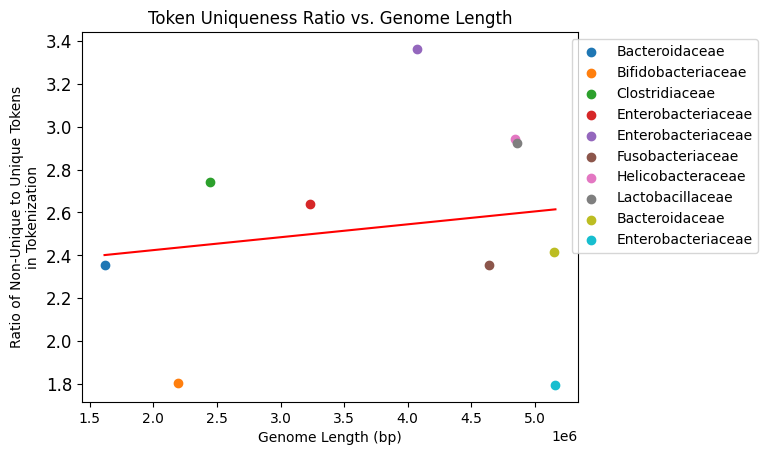

In [57]:
fig, ax = plt.subplots()
tkn_ratios = [len(tkns_non_unique[i])/len(tkns_unique[i]) for i in range(len(tkns_unique))]
for i, genome_len in enumerate(gls_genomes):
    ax.scatter(genome_len, tkn_ratios[i])
#best fit line
x = np.array(gls_genomes).reshape(len(gls_genomes), 1)
X = np.append(x, np.ones((len(gls_genomes), 1)), axis=1)
y = np.array(tkn_ratios).reshape(len(tkn_ratios), 1)
theta = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
y_line = X.dot(theta)
ax.plot(x, y_line, 'r')
ax.set_ylabel("Ratio of Non-Unique to Unique Tokens\nin Tokenization")
ax.set_xlabel('Genome Length (bp)')
ax.set_title("Token Uniqueness Ratio vs. Genome Length - Set {}".format(set_number))


ax.legend(gls_names, bbox_to_anchor=(1.175,1),
          ncol=1, fancybox=True,  loc='upper center')
plt.show()

fig, ax = plt.subplots()
tkn_ratios = [len(tkns_non_unique[i])/len(tkns_unique[i]) for i in range(len(tkns_unique))]
for i, genome_len in enumerate(gls_genomes):
    ax.scatter(genome_len, tkn_ratios[i])
    
#combining families plus names
gls_fams_names = ["{} {}".format(gls_families[i], gls_names[i]) for i in range(len(gls_families))]
#best fit line
x = np.array(gls_genomes).reshape(len(gls_genomes), 1)
X = np.append(x, np.ones((len(gls_genomes), 1)), axis=1)
y = np.array(tkn_ratios).reshape(len(tkn_ratios), 1)
theta = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
y_line = X.dot(theta)
ax.plot(x, y_line, 'r')
ax.set_ylabel("Ratio of Non-Unique to Unique Tokens\nin Tokenization")
ax.set_xlabel('Genome Length (bp)')
ax.set_title("Token Uniqueness Ratio vs. Genome Length")


ax.legend(families, bbox_to_anchor=(1.175,1),
          ncol=1, fancybox=True,  loc='upper center')
plt.show()




### Plotting Length Frequencies of Unique Tokens

NameError: name 'ls_unique_len_freqs' is not defined

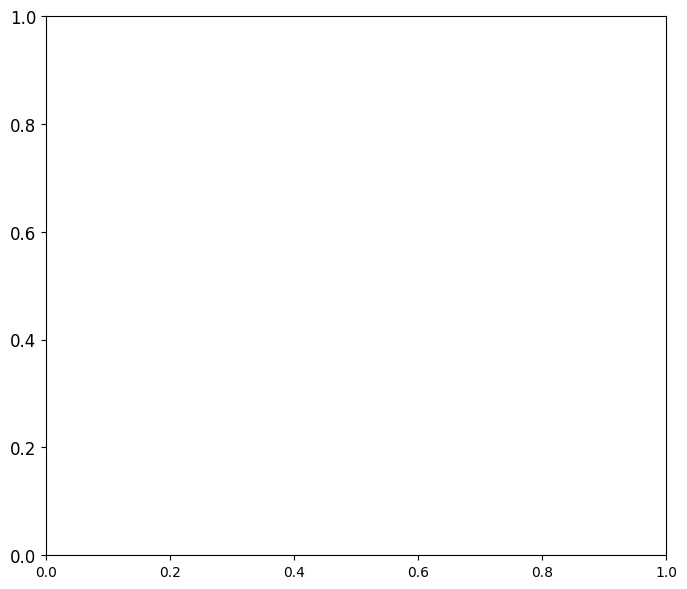

In [58]:
fig, ax = plt.subplots(figsize=(8, 7))
for i, pair in enumerate(ls_unique_len_freqs):
    #keys = lengths = x
    #values = counts = y
    ax.scatter(np.log(list(pair.keys())), np.log10(list(pair.values())))
ax.legend(ls_names)
ax.set_xlabel('Vocab Length')
ax.set_ylabel('Log10 Count')
ax.set_title("Log10 Unique Token Lengths vs. Log10 Unique Token Length Counts - Set {}".format(set_number))
plt.show()


### Plotting individual length vs. frequency distributions

In [ ]:
from matplotlib import cm
cmap = cm.get_cmap('tab10')

#fig, ax = plt.subplots(2, 5)
for i, pair in enumerate(ls_unique_len_freqs):
    #keys = lengths = x
    #values = counts = y
    if(i<5):
        idx_x = 0
        idx_y = i
    else:
        idx_x=1
        idx_y= i-0
    f = plt.figure(figsize=(8, 7))
    ax = f.add_axes([0.1,0.1,0.8,0.8])
    ax.scatter(np.log10(list(pair.keys())), np.log10(list(pair.values())), color=cmap(i))
    ax.set_xlabel('Log10 Vocab Length')
    ax.set_ylabel('Log10 Count')
    ax.set_title("Unique Token Lengths vs.\nToken Length Counts: " + ls_names[i] + " Set number".format(num))

#     ax[idx_x][idx_y].scatter((pair.keys()), np.log10(list(pair.values())))
#     ax[idx_x][idx_y].set_xlabel('Vocab Length')
#     ax[idx_x][idx_y].set_ylabel('Log10 Count')
#     ax[idx_x][idx_y].set_title("Vocab Token Lengths vs. Token Length Counts:\n" + ls_names[i])

#     print(pair)
plt.show()


## Extracting long tokens in Set 0

In [243]:
long_tokens = []
for i, freqs in enumerate(sorted_freqs):
    for freq in freqs:
        if(len(freq[0])>40):
            print(names[i], freq, len(freq[0]))
            long_tokens.append(freq)
            break
print(len(long_tokens))

B. fragilis ('AATACTTTTACAATGAAGAGTTTGATCCTGGCTCAGGATGAACGCTAGCTAC', 6) 52
B. adolescentis ('TGACCCTCTCCATGCCATGGAGATGCGCTACCAGCTGCGCCAT', 2) 43
C. difficile ('AGGGACCGAACTGTCTCACGACGTTCTGAACCCAGCTCGCGT', 9) 42
E. cloacae ('AGCCTGTTATCCCCGGAGTACCTTTTATCCGTTGAGCGATGGCCC', 5) 45
E. coli ('TGATTGCCTTTCTTGGTCTGATGCATCTCCGGATCGCGTTGCTGCTCTTTGTTCTT', 8) 56
F. nucleatum ('TACACCATTCGTGCAGGTCGGAACTTACCCGACAAGGAATTTCGCTACCTTAGGACCGTTATAGTTACGGCCGCC', 3) 75
H. pylori ('AGGGACCGAACTGTCTCACGACGTTCTGAACCCAGCTCGCGTACCGCTT', 2) 49
L. plantarum ('AGGGACCGAACTGTCTCACGACGTTCTGAACCCAGCTCGCGTACCGCTTTAATGGGCGAACAGCCCAACCCTTGGGACC', 3) 79
P. vulgatus ('ATTTTCGGGGGAATACCTAAAGATACAAAAAAGCCAACTAATTCGCAATACTTTGTGTATGAATTAGTTGGCTGATTTTGTAATATTTAATGAATGTCCC', 10) 100
S. enterica ('TGGAACTGAGACACGGTCCAGACTCCTACGGGAGGCAGCAGT', 5) 42
10


# Exploring All Genomes

In [207]:
%%time
max_genome = ""
max_len = -np.inf
min_genome = ""
min_len = np.inf

with open('all_genomes_unlabeled.txt', 'r') as f:
    for line in tqdm(f):
        if(len(line)>max_len):
            max_genome = line
            max_len = len(line)
        if(len(line)<min_len):
            min_genome = line
            min_len =len(line)
#max sequence length = 2196995

#min seq length = 2
#max token in max sequence: 131


1792397201it [25:58, 1149998.52it/s]

CPU times: user 19min 1s, sys: 6min 50s, total: 25min 52s
Wall time: 25min 58s


895116
57
698
ATCAATAACGATGAAGCCTTCGCCATCGCCTTCTGCGCGTTTCAGCACTTTAAGCTCGCGCTGGTTGTCGTGATCGTAGCTGGAAATACAAACGGTATCGACATGACGAATACCCAGTTCACGCGCCAGTAACGCACCCGGTACCAGACCGCCACGGCTTACGGCAATAATGCCTTTCCATTGTTCAGAAGGCATCAGTCGGCTTGCGAGTTTACGTGCATGGATCTGCAACATGTCCCAGGTGACGATGTATTTTTCGCTCATGTGAAGTGTCCCAGCCTGTTTATCTACGGCTTAAAAAGTGTTCGAGGGGAAAATAGGTTGCGCGAGATTATAGAGATCTGGCGCACTAAAAACCAGTATTTCACATGAGTCCGCGTCTTTTTACGCACTGCCTCTCCCTGACGCGGGATAAAGTGGTATTCTCAAACATATCTCGCAAGCCTGTCTTGTGTTGACAACATTTTCTGCTAACCCTGTGACCTGCAATACTGTTTTGCGGGTGATCGACAAGGAGACTTAACGTGTCTGAACTGTCTCAATTATCTCCACAGCCGCTGTGGGATATTTTTGCCAAAATCTGTTCTATTCCTCACCCGTCCTATCATGAAGAGCAACTCGCTGAATACATTGTTGGTTGGGCAAAAGAGAAAGGTTTCCATGTCGAACGCGATCAGGTAGGTAATATCCTGATTCGT
8.963439912680371
9.0


<AxesSubplot:>

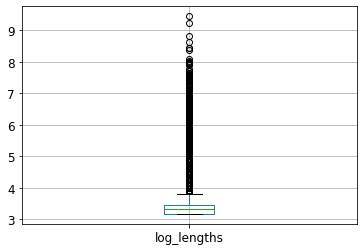

In [97]:
print(max_len)
print(min_len)
subwords = bpe.encode([max_genome, min_genome], output_type=yttm.OutputType.SUBWORD)
max_tok =""
max_tok_len = -np.inf
total_len = []
for token in subwords[0]:
    if(len(token)>max_tok_len):
        max_tok_len = len(token)
        max_tok = token
    total_len += [len(token)]
print(max_tok_len)
print(max_tok)
print(sum(total_len)/len(subwords[0]))
print(np.median(total_len))
lengths_df = pd.DataFrame({"lengths":total_len, 'log_lengths':np.log2(total_len)})
# lengths_df.boxplot(['log_lengths'])
lengths_df_long = lengths_df[lengths_df['lengths']>8]
lengths_df_long.boxplot(['log_lengths'])

In [5]:
#Byte pair encoding
from array import array

# Convert string to array of integers
# Initial tokens are single characters
def string2array(s) :
    tokens = list(set(s))
    a = [tokens.index(i) for i in s]
#     for i in range(len(s)) :
#         if not s[i] in tokens :
#             tokens += s[i]
#         a.append(tokens.index(s[i]))
    return tokens, a

def strings2arrays(strings):
    tokens = []
    arrays = []
    for s in strings:
        tokens_, a = string2array(s)
        tokens = list(set(tokens + tokens_))
        arrays.append(a)
#         arrays.append(array('i', a))
    return tokens, arrays

# Find most frequent pair of characters in string        
def bestPair(arrays) :
    count = dict()
    m = 0
    b = (-1, -1)
    for a in arrays:
        for i in range(len(a)-1) :
            p = (a[i],a[i+1])
            if p in count :
                count[p] += 1
            else :
                count[p] = 1   
            if count[p] > m :
                m = count[p]
                b = p 
    return m, b

# Replace pair with new integer throughout string
def replacePair(arrays,b,v) : #array version
    v = array('i', [v])
    us = []
    for a in arrays:

        u= array('i', a)
        i = 0
        while i < len(a)-1 :
            p = (a[i],a[i+1])
            if p == b :
                u[i:i+2] = v
                i += 1
#             else :
#                 u.append(a[i])
            i += 1
        us.append(u)
    return us


# def replacePair(arrays,b,v) : #v substitution list version
#     us = []
#     for a in arrays:

#         u = a
#         i = 0
#         while i < len(a)-1 :
#             p = (a[i],a[i+1])
#             if p == b :
#                 u[i:i+2]=[v]
#                 i += 1
# #             else :
# #                 u.append(a[i])
#             i += 1
# #         if i == len(a)-1 :
# #             u.append(a[i])
#         us.append(u)
#     return us

# def replacePair(arrays,b,v) :#original multi-list version
#     us = []
#     for a in arrays:

#         u = []
#         i = 0
#         while i < len(a)-1 :
#             p = (a[i],a[i+1])
#             if p == b :
#                 u.append(v)
#                 i += 1
#             else :
#                 u.append(a[i])
#             i += 1
#         if i == len(a)-1 :
#             u.append(a[i])
#         us.append(u)
#     return us

# Find tokens by repeatedly looking for common pairs
def findTokens(n,tokens,arrays):
    for i in range(n) :
        # Find the most common pair
        m, b = bestPair(arrays)
        if m == 1 : # Stop if no repeating pairs
            break
        # Replace the pair with the next token number
        u = replacePair(arrays,b,len(tokens))
        # The new token is the concatenation of the pair
        t = tokens[b[0]] + tokens[b[1]]
        tokens.append(t)
        arrays = u
    return tokens



0.5065350720282183

In [4]:
%%time
path = 'SchirmerM_2016/SchirmerM_2016__G88690.fa'
#previously checked with SCPN01.1.fsa_nt.gz


def write_genomes(folder, filename):
    with open(os.path.join(folder, filename), 'w') as f:
        for subfolder in os.listdir(folder):
            if('tar' in subfolder or 'txt' in subfolder):
                continue
            folder_path = os.path.join(folder, subfolder)
            for file in os.listdir(folder_path):
                path = os.path.join(folder_path, file)
                genomes = list(retrieve_genomes(path).values())
                for genome in genomes:
                    f.write(genome + '\n')
            
    
print("retrieving genomes")
genomes = list(retrieve_genomes(path).values())
print(len(genomes))
# max_seq_len = 0
# for genome in genomes:
#     max_seq_len = max(max_seq_len, len(genome))
# write_genomes('.', 'all_genomes_unlabeled.txt')   
iterations = 5000
print("converting string to array")
tokens, arrays = strings2arrays(genomes[0])
# tokens, a = string2array(list(genomes.values())[0])
# tokens, a = string2array("".join(list(genomes.values())))
# print(len("".join(genomes[:10])))
print("beginning BPE")
# tokens = findTokens(iterations, tokens, arrays)
# max_token_length = 0
# max_token = ""
# for token in tokens:
#     if len(token)>max_token_length:
#         max_token_length = len(token)
#         max_token = token
# print(len(tokens))
# print(max_token_length)
# print(max_token)

retrieving genomes
380956
converting string to array


NameError: name 'strings2arrays' is not defined

In [140]:
#Byte pair encoding - ORIGINAL CODE
# Convert string to array of integers
# Initial tokens are single characters
def string2array(s) :
    tokens = []
    a = []
    for i in range(len(s)) :
        if not s[i] in tokens :
            tokens += s[i]
        a.append(tokens.index(s[i]))
    return tokens, a

# Find most frequent pair of characters in string        
def bestPair(a) :
    count = dict()
    m = 0
    b = (-1, -1)
    for i in range(len(a)-1) :
        p = (a[i],a[i+1])
        if p in count :
            count[p] += 1
        else :
            count[p] = 1   
        if count[p] > m :
            m = count[p]
            b = p 
    return m, b

# Replace pair with new integer throughout string
def replacePair(a,b,v) :
    u = []
    i = 0
    while i < len(a)-1 :
        p = (a[i],a[i+1])
        if p == b :
            u.append(v)
            i += 1
        else :
            u.append(a[i])
        i += 1
    if i == len(a)-1 :
        u.append(a[i])
    return u

# Find tokens by repeatedly looking for common pairs
def findTokens(n,tokens,a):
    for i in range(n) :
        # Find the most common pair
        m, b = bestPair(a)
        if m == 1 : # Stop if no repeating pairs
            break
        # Replace the pair with the next token number
        u = replacePair(a,b,len(tokens))
        # The new token is the concatenation of the pair
        t = tokens[b[0]] + tokens[b[1]]
        tokens.append(t)
        a = u
    return tokens
    


In [141]:
#previously checked with SCPN01.1.fsa_nt.gz
with gzip.open('VOFL01.1.fsa_nt.gz', 'rb') as f:
    file_content = f.read()
printout = ""
for i in range(10000):
    printout+= chr(file_content[i]) 
    if(chr(file_content[i])=='\n' or chr(file_content[i])==" "):
#         print(i)
        continue
file_content = file_content.decode('utf-8')
idx1 = file_content.find("\n")
idx2 = file_content[1:].find(">")
print(idx1, idx2)
print(idx2-idx1)
genomes = {}
done = False
current_string = file_content
i=0

while not done:
    #get header
    idx_start = current_string.find('\n')
    header = current_string[:idx_start]

    idx_end = current_string[1:].find('>')
    if(idx_end==-1):#no more headers
        done=True
    genome = current_string[idx_start:idx_end]
    genome = genome.replace("\n", "")
#     idx_comma = header.find(',')
#     header 
    genomes[header]=genome
#     print(genome[:100])
#     print('genome length: ', len(re.sub('[ATGC]', "", genome)))
#     print(repr(re.sub('[ATGC]', "", genome)))
    current_string = current_string[idx_end+2:]
    print('remaining string length:', len(current_string))
    print(repr(header))
file = 'VOFL01.1.fsa_nt.gz'
df = pd.DataFrame(genomes, index=[0])
#         print(df.columns)
df.columns=[df.columns[0][1:]] + list(df.columns[1:])
df.to_csv(file[:file.rfind('nt') + 2]+'.csv.gz', compression='gzip', index=False)


FileNotFoundError: [Errno 2] No such file or directory: 'VOFL01.1.fsa_nt.gz'

In [231]:
def separate_contigs(filename, verbose=False):
    if '.gz' in filename:
        with gzip.open(filename, 'rb') as f:
            file_content = f.read()
            
    else:
        with open(filename, 'rb') as f:
            file_content = f.read()
    f.close()
    file_content = file_content.decode('utf-8')
    current_string = file_content
    done = False
    genomes = {}
    while not done:
        idx_start = current_string.find('\n')
        header = current_string[:idx_start]

        idx_end = current_string[1:].find('>')
        if(idx_end==-1):#no more headers
            done=True
        genome = current_string[idx_start:idx_end]
        genome = genome.replace("\n", "")
        genomes[header]=genome
        current_string = current_string[idx_end+2:]
        if verbose:
            print('remaining string length:', len(current_string))
            print(repr(header))
    return genomes


remaining string length: 7233

'SCPN01001665.1 Human gut metagenome tig00705639, whole genome shotgun sequence'


In [232]:
import os
import pandas as pd
total_len = 0
min_len = 1000000000
min_key = 99999
# for i in range(len((genomes.items()))):
#     genome_len = len(list(genomes.items())[i][1])
#     total_len+= genome_len
#     min_len = min(genome_len, min_len)
#     min_key = list(genomes.items())[i][0]

# print(len(genomes.items()))
# print(min_len)
# print(genomes[min_key])


for file in os.listdir():
    if 'fsa_nt' in file and '.csv' not in file:
#         if file == 'VOFL01.1.fsa_nt.gz':
#             continue
        print("Beginning file:", file)

        genomes = separate_contigs(file, verbose=False)
        df = pd.DataFrame(genomes, index=[0])
#         print(df.columns)
        df.columns=[df.columns[0][1:]] + list(df.columns[1:])
        df.to_csv(file[:file.rfind('nt') + 2]+'.csv.gz', compression='gzip', index=False)


Beginning file: VOFL01.1.fsa_nt.gz
Beginning file: VOFC01.1.fsa_nt.gz
Beginning file: VOFI01.1.fsa_nt.gz
Beginning file: VOFD01.1.fsa_nt.gz
Beginning file: VOFE01.1.fsa_nt
Beginning file: VOFK01.1.fsa_nt.gz
Beginning file: SCPP01.1.fsa_nt.gz
Beginning file: VOFG01.1.fsa_nt.gz
Beginning file: VOFF01.1.fsa_nt.gz
Beginning file: SCPN01.1.fsa_nt.gz
Beginning file: VOFH01.1.fsa_nt.gz
Beginning file: VOFB01.1.fsa_nt.gz
Beginning file: SCPO01.1.fsa_nt.gz


In [153]:
# print(genomes.iloc['SCPN01001665.1 Human gut metagenome tig00705639, whole genome shotgun sequence'][-100:])
# print(file_content.replace('\n', '')[-100:])

TCCGTCTTTCAGTCTGCTGAAAATCCCTTTTTCACTCATATTCACTCTCCATGTTATTCTTTTTATGCACCCATCTTACTATATTACCTGTTTTACTGCT


In [9]:
# df.columns=[df.columns[0][1:]] + list(df.columns[1:])
# df[df.columns[0]].values[0]
print(os.chdir('')

None
/


In [242]:

# test_df = pd.read_csv('SCPO01.1.fsa_nt.csv.gz', compression='gzip')

# test_df2 = pd.read_csv( 'VOFC01.1.fsa_nt.csv.gz',compression='gzip')
test_0 = test_df.T.iloc[0]
test_0
test_1 = test_df2.T.iloc[0]
test_0 == test_1
test_df2.iloc[0, -1]

'ATAACAGTCTATATGGAGTCATGATACTATGGAAGAAAATGTTATCTTTATTGGTAGTAAACCAGTAATGAACTATGTTCTAGCAGTAGTGACACAATTT'

2345472

In [212]:
with gzip.open('SCPO01.1.fsa_nt.gz', 'r') as f:
    file_content = f.read()
print(file_content[:100])

b'>SCPO01000001.1 Human gut metagenome tig00000031, whole genome shotgun sequence\nAAACCACGAAGCTTCATCAG'


# Training the vocabulary

In [264]:
%%time
##Training BPE 
import numpy as np
from collections import defaultdict
train_df = test_df2
corpus = train_df.iloc[0, 1] 
# string = 'VOFL01.1.fsa_nt.gz'
# string[:string.rfind('nt') + 2]+'.csv.gz'

tokens = [ord(x) for x in list(corpus)]
init_vocab = np.unique(np.array(tokens))
print("starter vocab tokens: ", *[i for i in init_vocab])
init_len = len(tokens)
k = 100 #number of iterations
chars2tokens = {}
tokens2chars={}
#initialize the tokens2chars vocabulary with initial code points to avoid overlap
for token in init_vocab:
    tokens2chars[token] = token
    chars2tokens[token] = token
for i in range(k):
    if(i in init_vocab):
        continue
#pairing pass
    vocab = defaultdict()

    for j in range(len(tokens)-1):
        if((tokens[j], tokens[j+1]) in vocab.keys()):
            vocab[(tokens[j], tokens[j+1])] +=1
        else:
            vocab[(tokens[j], tokens[j+1])] =1
      
 #replacemenet pass
    max_pair = max(vocab)
    chars2tokens[max_pair] = i
    tokens2chars[i] = max_pair
   
    for j in range(len(tokens)-1):
        if(j+1>=len(tokens)):
            break
        if((tokens[j], tokens[j+1])==max_pair):
            tokens[j] = int(i)
            del(tokens[j+1])
  #edit corpus
final_len = len(tokens)

print('initial length:', init_len)
print('final length:', final_len)
print('compression ratio:', init_len/final_len)
print('compression factor:', final_len/init_len)

len(test_df.T.iloc[1, 0])

starter vocab tokens:  65 67 71 84
initial length: 49058
final length: 20388
compression ratio: 2.406219344712576
compression factor: 0.41558971013901913
CPU times: user 2.7 s, sys: 990 µs, total: 2.7 s
Wall time: 2.7 s


2345472

# Explicitly greedy version

In [287]:
%%time
#Vocabulary editing

#for each pair, expand to its text code and store the value as a key

def decode(tokens, tokens2chars, verbose=False):
    ''' 
    for each token, check its corresponding pair
    if it retrieves a pair of characters, redo the string
    '''
    j = 0
    done = False
    while not done:
        j+=10

        done = True
        for i in range(len(tokens)):
            if(isinstance(tokens2chars[tokens[i]], tuple)):
                done = False
                pair = list(tokens2chars[tokens[i]])
                tokens = tokens[:i] + pair + tokens[i:]
                del(tokens[i+2])
    if(verbose):
        print(f"Detokenization took {j} iterations")
    return tokens
def get_vocab(tokens2chars):
    new_chars2tokens, new_tokens2chars= {}, {}
    for i, key in enumerate(tokens2chars.keys()):
        text_key = "".join([chr(o) for o in decode([key], tokens2chars)])
        new_chars2tokens[text_key] = i
        new_tokens2chars[i] = text_key
    return new_chars2tokens, new_tokens2chars

#Vocabulary editing

#for each pair, expand to its text code and store the value as a key

def get_vocab(tokens2chars):
    new_chars2tokens, new_tokens2chars= {}, {}
    for i, key in enumerate(tokens2chars.keys()):
        text_key = "".join([chr(o) for o in decode([key], tokens2chars)])
        new_chars2tokens[text_key] = i
        new_tokens2chars[i] = text_key
    return new_chars2tokens, new_tokens2chars

def tokenize(string, chars2tokens, unk=1000, verbose=False):
    max_token_len = 0
    tokens = []
#   chars2tokens['<unk>']= unk
    for key in chars2tokens.keys():
        max_token_len = max(max_token_len, len(key))
    done = False
    j=0
    while not done:
        j+=1
        done = True
        for i in range(max_token_len):
            substring = string[:max_token_len-i]
            if substring in chars2tokens.keys():
                tokens.append(chars2tokens[substring])
                done = False
                string = string[max_token_len-i:]
                break
      # elif(i==max_len-1):
      #   done=False
      #   tokens.append(unk)
      #   s=string[1:]
    if(verbose):
        print(f'Tokenization took {j} iterations')
    return tokens
# def tokenize(string, chars2tokens, verbose=False):
#     string = [ord(c) for c in string]
#     done = False
#     j=0
#     while not done:
#         j+=1
#         done = True
#         #loop over the string, finding matches to pairs in vocab and replacing them with new integers
#         for i in range(len(string)-1):
#             if i+1>=len(string):
#                 done=False
#                 break
        
#         if(string[i], string[i+1]) in chars2tokens.keys():
#             string[i] = chars2tokens[(string[i], string[i+1])]
#             del[string[i+1]]
#             done = False #if there are any remaining pairs in the string, continue the tokenization process
#     if(verbose):
#         print(f'Tokenization took {j} iterations')
#     return string

def detokenize(tokens, tokens2chars):
    chars= []
    for token in tokens:
        chars.append(tokens2chars[token])
    return chars

test_corpus = test_df.T.iloc[1, 0]
init_len = len(test_corpus)
final_chars2tokens, final_tokens2chars = get_vocab(tokens2chars)
tokens = tokenize(test_corpus, final_chars2tokens, verbose=True)
tokenized_len = len(tokens)
chars = "".join(detokenize(tokens, final_tokens2chars))
print("Initial length:", init_len)
print("Compressed length:", tokenized_len)
print("Detokenized length", len(chars))
print("Compression ratio:", init_len/tokenized_len)
print("Compression factor:", tokenized_len/init_len)
print("Detokenizer outputs same as tokenizer input:", chars==test_corpus)
# "".join(detokenize( tokens[0:10], final_tokens2chars))

Tokenization took 976303 iterations
Initial length: 2345472
Compressed length: 976302
Detokenized length 2345472
Compression ratio: 2.4024041741182542
Compression factor: 0.41624969302554027
Detokenizer outputs same as tokenizer input: True
CPU times: user 3min 51s, sys: 28.8 ms, total: 3min 51s
Wall time: 3min 51s


# Fewest Tokens method

In [288]:
%%time
def maxToken(tokens) :
    m = 0
    for t in tokens :
        if len(t) > m :
            m = len(t)
    return m

# Find tokens that occur in string at given position 
def nextTok(string,tokens,pos,maxtoken) :
    # The next chacter is always a potential token
    tok = [string[pos]]
    for i in range(1,maxtoken+1) :
        u = string[pos:pos+i]
        if u in tokens :
            tok.append(u)
    return tok

# Find the shortest path from the first character to the last (fewest tokens)
def bfs(string,tokens,maxtoken) :
    # Maintain a queue of positions in the string, starting with position zero
    queue = [0] 
    n = len(string)
    
    # Keep track of the positions we have already visited
    visited = [False for i in range(0,n+1) ] 
    visited[0] = True
    
    # For each postion, keep track of the position that preceded it 
    pred = [-1 for i in range(0,n+1) ]

    # Perform a breadth first search to get from the first to last character
    while queue != [] : 
        i = queue.pop(0)
        # Find the tokens that can occur at this position
        tok = nextTok(string,tokens,i,maxtoken)
        for t in tok : 
            # Find the new position this token skips to
            j = i + len(t)
            # If we have not already visited this position, 
            if not visited[j] :
                # Mark the position as visited
                visited[j] = True
                # Record that the old position precedes the new one
                pred[j] = i
                # Add the new position to the queue
                queue.append(j)
                # Stope if we are at the end of the string
                if j == n :
                    return pred
    return pred

# tokenize a string from right to left given the predecessor of each token
def tokenize(string,pred) :
    toks = []
    i = len(string)
    while i > 0 :
        j = pred[i]
        t = string[j:i]
        toks = [t] + toks
        i = j
    return toks

# string to be tokenized        
# string = "abcbabcbaabbcbcaabbc"

# # Two different sets of tokens
# tokens1 = {"abc" : 1, "bcba": 1, "abb": 1, "cbca" : 1}
# tokens2 = {"abc" : 1, "bcba": 1, "abbc": 1, "cbca" : 1}

# # Find the maximum length of tokens
# maxtoken = maxToken(tokens1)
string = test_corpus
tokens1 = final_chars2tokens
maxtoken = maxToken(final_chars2tokens)
# # Find the shortest path through the string using the tokens
pred = bfs(string,tokens1,maxtoken)

# Tokenize the string using the predecessor table
toks = tokenize(string,pred)

# print(string)
print(toks)
print(float(init_len)/len(toks)-2.4024041741182542
)
# # Find the maximum length of tokens
# maxtoken = maxToken(tokens2)

# # Find the shortest path through the string using the tokens
# pred = bfs(string,tokens2,maxtoken)

# # Tokenize the string using the predecessor table
# toks = tokenize(string,pred)

# print(toks)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



# Old Version (Implicitly greedy)

In [284]:
%%time
def tokenize(string, chars2tokens, verbose=False):
    string = [ord(c) for c in string]
    done = False
    j=0
    while not done:
        j+=1
        done = True
        #loop over the string, finding matches to pairs in vocab and replacing them with new integers
        for i in range(len(string)-1):
            if i+1>=len(string):
                done=False
                break

            if(string[i], string[i+1]) in chars2tokens.keys():
                string[i] = chars2tokens[(string[i], string[i+1])]
                del[string[i+1]]
                done = False #if there are any remaining pairs in the string, continue the tokenization process
    if(verbose):
        print(f'Tokenization took {j} iterations')
    return string

def detokenize(tokens, tokens2chars, verbose=False):
    ''' 
    for each token, check its corresponding pair
    if it retrieves a pair of characters, redo the string
    '''
    j = 0
    done = False
    while not done:
        j+=1

        done = True
        for i in range(len(tokens)):
            if(isinstance(tokens2chars[tokens[i]], tuple)):
                done = False
                pair = list(tokens2chars[tokens[i]])
                tokens = tokens[:i] + pair + tokens[i:]
                del(tokens[i+2])
    if(verbose):
        print(f"Detokenization took {j} iterations")
    return tokens
test_corpus = test_df.T.iloc[1, 0][:int(1e5)]

init_len= len(test_corpus)
tokens = tokenize(test_corpus, chars2tokens)
tokenized_len = len(tokens)
chars = "".join([chr(o) for o in detokenize(tokens, tokens2chars, verbose=True)])
final_len = len(chars)
print("Initial length:", init_len)
print("Compressed length:", tokenized_len)
print("Compression ratio:", init_len/tokenized_len)
print("Compression factor:", tokenized_len/init_len)
print("Detokenizer outputs same as tokenizer:", chars==test_corpus)


Detokenization took 21 iterations
Initial length: 100000
Compressed length: 41506
Compression ratio: 2.4092902231002746
Compression factor: 0.41506
Detokenizer outputs same as tokenizer: True
CPU times: user 33.7 s, sys: 7.71 ms, total: 33.7 s
Wall time: 33.7 s


In [3]:
### Writing 1000-bp lengths to new file
# with open('/gpfs/data/johnsonslab/nlp-genomics/pasolli-2019/all_genomes_unlabeled_sample-A0.1-1.txt', 'r') as f:
#     with open('/gpfs/data/johnsonslab/nlp-genomics/pasolli-2019/all_genomes_unlabeled_sample-A0.1-1_1000bp.txt', 'w') as g:
#         for line in f:
#             genome = line.strip()
#             for i in range(0, len(genome), 1000):
#                 stretch = genome[i:i+1000]
#                 g.write(stretch + '\n')


            

In [218]:
os.getcwd()

'/gpfs/data/johnsonslab/nlp-genomics/pasolli-2019'

In [219]:
key_df

,run_accession,sample_title,disease_state
0,SRR17648445,11680,1
1,SRR20677920,16564,0
2,SRR17648444,16644,0
3,SRR17648433,22647,0
4,SRR20677919,24238,1
...,...,...,...
159,SRR20677882,69158,0
160,SRR17648355,69208,0
161,SRR17648354,85150,0
162,SRR17648353,86001,0


In [12]:
# import os
# with(open('all_genomes_unlabeled_sample-A0.1-1.txt', 'r')) as f:
#     with open("sample-A0.1-1-6k.txt", "wt") as g:
#         g.seek(0, os.SEEK_END)
#         for line in f:
#             g.write(line)
# #             print(line)
#             g.seek(0, os.SEEK_END)
#             if (g.tell()>=5832000):
#                 break

            
            

# Testing tokenizers on subsample

## Testing large sample tokenizers

### Counting token frequencies

In [3]:
%%time
import operator
model_path = "metagenomes_8192k.model"
bpe = yttm.BPE(model=model_path)

freqs = {}
threshold = 0
total_len = 0
total_count = 0
with(open('sample-A0.1-1-6k.txt', 'r')) as f:
    for line in f:
        tokens= bpe.encode(line.strip(), output_type =yttm.OutputType.SUBWORD )
#         tokens = tokenize(line.strip(), length_threshold=threshold)
        total_len +=len(tokens)
        total_count +=1
        for token in tokens:
            if token not in freqs.keys():
                freqs[token] = 1
            else:
                freqs[token]+=1
sorted_freqs = sorted(freqs.items(), key=operator.itemgetter(1), reverse=True)
print(len(sorted_freqs))
print("Average tokenization length: ", total_len/total_count)



253551
Average tokenization length:  109.06531616811813
CPU times: user 21 s, sys: 780 ms, total: 21.7 s
Wall time: 21.8 s


2
[[0.         1.        ]
 [0.30103    1.        ]
 [0.47712125 1.        ]
 ...
 [6.70600526 1.        ]
 [6.70600535 1.        ]
 [6.70600543 1.        ]] [[4.73219265]
 [4.71754569]
 [4.68747545]
 ...
 [0.        ]
 [0.        ]
 [0.        ]]


Text(0, 0.5, 'Log10 Frequency')

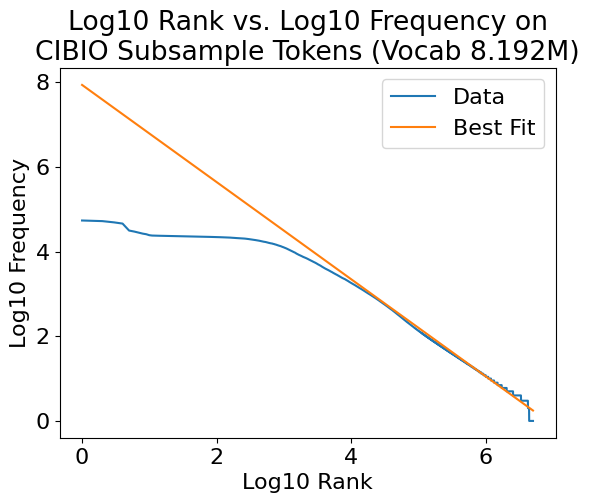

In [7]:
sorted_freq_values = []
sorted_freq_lengths = []
freq_threshold=0
print(len(sorted_freqs[0][0]))
for freq in sorted_freqs:
    sorted_freq_values.append(freq[1])
    if(freq[1]>freq_threshold):
        if(freq[0][0]=="_"):
            sorted_freq_lengths.append(len(freq[0][1:]))
        else:
            sorted_freq_lengths.append(len(freq[0]))

ranks = np.arange(1, len(sorted_freqs) + 1)
x = np.log10(ranks).reshape(len(ranks), 1)
X = np.append(x, np.ones((len(ranks), 1)), axis=1)
y = np.array(np.log10(sorted_freq_values)).reshape(len(sorted_freq_values), 1)
print(X, y)
theta = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
y_line = X.dot(theta)
plt.plot(np.log10(ranks), np.log10(sorted_freq_values))
plt.plot(x, y_line)
plt.rcParams.update({'font.size': 16})
plt.title('Log10 Rank vs. Log10 Frequency on\nCIBIO Subsample Tokens (Vocab 8.192M)')
plt.legend(['Data', 'Best Fit'])
plt.xlabel('Log10 Rank')
plt.ylabel('Log10 Frequency')

In [10]:
total = 0 
for i in range(1, len(sorted_freq_values)):
    total+= sorted_freq_values[i-1]
    if total>=sum(sorted_freq_values)/2:
        break
print("number of types to reach 50%: ", i)
print(i/len(sorted_freq_values) * 100, "% of types make up half of all tokens")

number of types to reach 50%:  20782
8.196378637828287 % of types make up half of all tokens


In [11]:
sfv_array = np.array(sorted_freq_values)
singles = sfv_array[sfv_array<=1]
print(len(singles), "types only appear once in all tokenizations")
print(len(singles)/len(sorted_freq_values) * 100, "% of all types only appear once")
print("Half of all types appear", sorted_freq_values[int(len(sorted_freq_values)/2)], "times or fewer")


193873 types only appear once in all tokenizations
76.46311787372166 % of all types only appear once
Half of all types appear 1 times or fewer


Text(0.5, 1.0, 'Log10 frequencies of log10 lengths of types (Vocab 8.192M)')

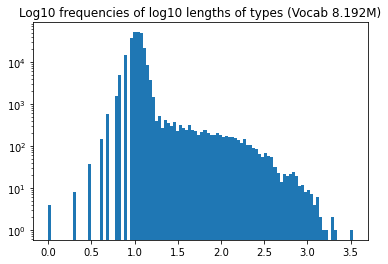

In [12]:
plt.hist(np.log10(sorted_freq_lengths), bins=100, log=True)
plt.title("Log10 frequencies of log10 lengths of types (Vocab 8.192M)")

## Testing small sample tokenizers

### Counting token frequencies

In [ ]:
model_path = "metagenome_brown_sample_8192k.model"
bpe = yttm.BPE(model=model_path)

In [9]:
%%time
import operator
freqs = {}
threshold = 0
total_len = 0
total_count = 0
with(open('sample-A0.1-1-6k.txt', 'r')) as f:
    for line in f:
        tokens= bpe.encode(line.strip(), output_type =yttm.OutputType.SUBWORD )
#         tokens = tokenize(line.strip(), length_threshold=threshold)
        total_len +=len(tokens)
        total_count +=1
        for token in tokens:
            if token not in freqs.keys():
                freqs[token] = 1
            else:
                freqs[token]+=1
sorted_freqs = sorted(freqs.items(), key=operator.itemgetter(1), reverse=True)
print(len(sorted_freqs))
print("Average tokenization length: ", total_len/total_count)



5282
Average tokenization length:  1.0
CPU times: user 1min 31s, sys: 20.8 s, total: 1min 52s
Wall time: 1min 52s


10022
[[0.         1.        ]
 [0.30103    1.        ]
 [0.47712125 1.        ]
 ...
 [3.72263392 1.        ]
 [3.72271617 1.        ]
 [3.7227984  1.        ]] [[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]


Text(0, 0.5, 'Log10 Frequency')

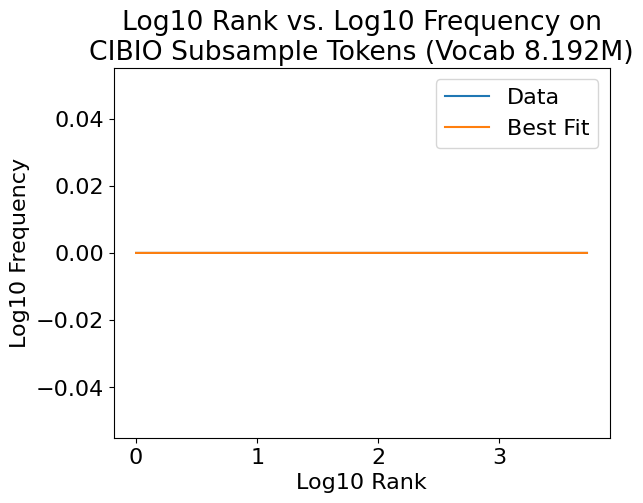

In [12]:
sorted_freq_values = []
sorted_freq_lengths = []
freq_threshold=0
print(len(sorted_freqs[0][0]))
for freq in sorted_freqs:
    sorted_freq_values.append(freq[1])
    if(freq[1]>freq_threshold):
        if(freq[0][0]=="_"):
            sorted_freq_lengths.append(len(freq[0][1:]))
        else:
            sorted_freq_lengths.append(len(freq[0]))

ranks = np.arange(1, len(sorted_freqs) + 1)
x = np.log10(ranks).reshape(len(ranks), 1)
X = np.append(x, np.ones((len(ranks), 1)), axis=1)
y = np.array(np.log10(sorted_freq_values)).reshape(len(sorted_freq_values), 1)
print(X, y)
theta = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
y_line = X.dot(theta)
plt.plot(np.log10(ranks), np.log10(sorted_freq_values))
plt.plot(x, y_line)
plt.rcParams.update({'font.size': 16})
plt.title('Log10 Rank vs. Log10 Frequency on\nCIBIO Subsample Tokens (Vocab 8.192M)')
plt.legend(['Data', 'Best Fit'])
plt.xlabel('Log10 Rank')
plt.ylabel('Log10 Frequency')

In [11]:
total = 0 
for i in range(1, len(sorted_freq_values)):
    total+= sorted_freq_values[i-1]
    if total>=sum(sorted_freq_values)/2:
        break
print("number of types to reach 50%: ", i)
print(i/len(sorted_freq_values) * 100, "% of types make up half of all tokens")

number of types to reach 50%:  2641
50.0 % of types make up half of all tokens


In [16]:
sfv_array = np.array(sorted_freq_values)
singles = sfv_array[sfv_array<=1]
print(len(singles), "types only appear once in all tokenizations")
print(len(singles)/len(sorted_freq_values) * 100, "% of all types only appear once")
print("Half of all types appear", sorted_freq_values[int(len(sorted_freq_values)/2)], "times or fewer")


5282 types only appear once in all tokenizations
100.0 % of all types only appear once
Half of all types appear 1 times or fewer


Text(0.5, 1.0, 'Log10 frequencies of log10 lengths of types (Vocab 8.192M)')

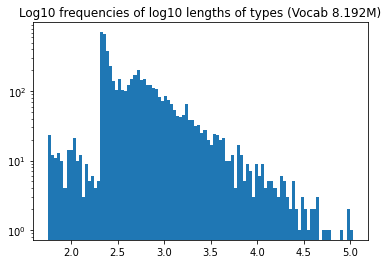

In [19]:
plt.hist(np.log10(sorted_freq_lengths), bins=100, log=True)
plt.title("Log10 frequencies of log10 lengths of types (Vocab 8.192M)")

In [18]:
print(len(sorted_freq_lengths))

5282
